# **Data Mining Course**

- **Group Project 2022/2023**
- **A2Z Insurance Company**

# **Metadata:** 
- CustID = ID
- FirstPolYear =  Year of the customer’s first policy
- BirthYear =  Customer’s Birthday Year
- EducYear = Academic Year
- MonthSal =  Gross monthly salary (€)
- GeoLivArea = Living Area
- Children = Binary variable (Y=1)
- CustMonVal = Customer Monetary Value
- ClaimsRate = ClaimsRate
- PremMotor = Premiums (€) in LOB: Motor
- PremHousehold = Premiums (€) in LOB: Household
- PremHealth = Premiums (€) in LOB: Health
- PremLife = Premiums (€) in LOB: Life
- PremWork Compensation = Premiums (€) in LOB: Work Compensation

# **1. Imports the needed libraries and some data exploration**

- **1.1) Imports**
- **1.2) Inicial Exploration**
- 1.2.1) Counting the number of lines 
- 1.2.2) Making a safety copy of the dataset
- 1.2.3) Datatypes
- **1.3) Duplicated Values**
- **1.4) Data Categorization**
- 1.4.1) Metric vs Non Metric Variables
- **1.5) Missing Values**
- 1.5.1) Initial Assessment
- 1.5.2) Apply the Mice algorithm on the metric_features
- 1.5.3) Apply the central tendency on the non_metric_features
- 1.5.3.1) Fillna (modes, inplace=True)

- **1.1) Imports**

In [1]:
# In case this was not previous installed.
# ! conda install graphviz

# Imports
import graphviz
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn as sns
import sqlite3
import pandas as pd
import time

# From Sklearn
from sklearn import linear_model
from sklearn.base import clone
from sklearn.cluster import AgglomerativeClustering, DBSCAN, estimate_bandwidth, KMeans, MeanShift, MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.impute import IterativeImputer
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples, pairwise_distances
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, export_graphviz

# From other libraries
from datetime import datetime
from itertools import product
from math import ceil
from minisom import MiniSom
from os.path import join
from pandas_profiling import ProfileReport
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Reading initial data
folder = 'a2z_insurance.sas7bdat'
df = pd.read_sas(folder)
df.head()

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   
1     2.0        1981.0     1995.0  b'2 - High School'     677.0         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork  
0     47.01     16.89  
1    194.48    106.13  
2     86.35     99.02  
3     35.34     28.34  
4     18.78     41.45

- **1.2) Inicial Exploration**

In [2]:
# Count the number of rows.
# Get sensivity on data.

len(df.axes[0]) 

10296

In [3]:
# Make a first security copy of our original dataset.

df_original = df.copy()

In [4]:
# Check dataset data types.

df.dtypes

CustID           float64
FirstPolYear     float64
BirthYear        float64
EducDeg           object
MonthSal         float64
GeoLivArea       float64
Children         float64
CustMonVal       float64
ClaimsRate       float64
PremMotor        float64
PremHousehold    float64
PremHealth       float64
PremLife         float64
PremWork         float64
dtype: object

- **1.3) Duplicate Values**

In [5]:
# Check the duplicate values on our dataset.

df.duplicated().sum()

0

- **1.4) Data Categorization**

In [6]:
# Define metric and non-metric features.

non_metric_features = ["EducDeg", "Children", "GeoLivArea"] 
metric_features = df.columns.drop(non_metric_features).to_list()
metric_features

['CustID',
 'FirstPolYear',
 'BirthYear',
 'MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork']

- **1.5) Missing Values**
- 1.5.1) Initial Assessment
- 1.5.2) Apply the Mice algorithm on the metric_features
- 1.5.3) Apply the central tendency on the non_metric_features
- 1.5.3.1) Fillna (modes, inplace=True)

In [7]:
# Check the missing values on our dataset.

df.isna().sum()

CustID             0
FirstPolYear      30
BirthYear         17
EducDeg           17
MonthSal          36
GeoLivArea         1
Children          21
CustMonVal         0
ClaimsRate         0
PremMotor         34
PremHousehold      0
PremHealth        43
PremLife         104
PremWork          86
dtype: int64

In [8]:
# Represent a missing values in pandas with a NaN value.

df.replace("", np.nan, inplace=True)

In [9]:
# Check descriptive statistics again before replacing missing values.

df.describe(include="all").T

count unique             top  freq         mean          std  \
CustID         10296.0    NaN             NaN   NaN       5148.5   2972.34352   
FirstPolYear   10266.0    NaN             NaN   NaN  1991.062634   511.267913   
BirthYear      10279.0    NaN             NaN   NaN  1968.007783    19.709476   
EducDeg          10279      4  b'3 - BSc/MSc'  4799          NaN          NaN   
MonthSal       10260.0    NaN             NaN   NaN  2506.667057  1157.449634   
GeoLivArea     10295.0    NaN             NaN   NaN     2.709859     1.266291   
Children       10275.0    NaN             NaN   NaN     0.706764     0.455268   
CustMonVal     10296.0    NaN             NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN             NaN   NaN     0.742772     2.916964   
PremMotor      10262.0    NaN             NaN   NaN   300.470252   211.914997   
PremHousehold  10296.0    NaN             NaN   NaN   210.431192   352.595984   
PremHealth     10253.0    NaN             NaN   NaN   171.580833   296.405976   
PremLife       10192.0    NaN             NaN   NaN    41.855782    47.480632   
PremWork       10210.0    NaN             NaN   NaN    41.277514    51.513572   

                     min      25%     50%       75%       max  
CustID               1.0  2574.75  5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0  1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0  1968.0    1983.0    2001.0  
EducDeg              NaN      NaN     NaN       NaN       NaN  
MonthSal           333.0   1706.0  2501.5   3290.25   55215.0  
GeoLivArea           1.0      1.0     3.0       4.0       4.0  
Children             0.0      0.0     1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44  186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39    0.72      0.98     256.2  
PremMotor          -4.11   190.59  298.61     408.3  11604.42  
PremHousehold      -75.0    49.45   132.8    290.05   25048.8  
PremHealth         -2.11    111.8  162.81    219.82   28272.0  
PremLife            -7.0     9.89   25.56     57.79     398.3  
PremWork           -12.0    10.67   25.67     56.79    1988.7

In [10]:
# Based on the following links, we considered that the dataset we are working with, is as a small dataset.
    # "(...) Thousands or lakhs of data are small data. But, millions of data are called as large data.(...)"
        # "(...) The most basic way to tell if data is big data is through how many unique entries the data has. 
    # Usually, a big dataset will have at least a million rows. 
    # A dataset might have less rows than this and still be considered big, but most have far more.(...)"

# Sources for 'small vs big data' difference:
    # https://www.researchgate.net/post/How-much-data-is-considered-to-be-small-data-Large-data-in-data-mining
    # https://www.domo.com/learn/article/4-ways-to-tell-if-your-data-is-big-data
    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

# Based on two links below we opted out to imput the missing values, using the a more complex and sofisticated algorihtm,
# when compared either to median/mode or KNN.
# After some research, we got to the conclusion that MICE is based in a much more complex algorithm than median/mode 
# or KNN imputer method.
# Normally, it is time efficient and performs well, when dealing with small data sets (which is our case).
# So, it allow us to reach more robust estimations.
    
# Imputer rationale:    
    # It takes the columns (variables) in which there is no missing values as the 'features' 
    # and the feature that has the missing value as the 'target'.
    # For each row (records), in which there is a missing value, sklearn makes a regression model in  
    # order to estimate the value for the missing values, by taking the given values from the remaining
    # columns to the 'training dataset'.
    # This imputer has multivariate, since it takes into consideration the weight correlations between the target
    # and all the remaining features in order to predict the missing value.
    
# Sources for imputer rationale:
    # https://lgreski.github.io/datasciencedepot/references/a-comparison-of-six-methods-for-missing-data-imputation-2155-6180-1000224.pdf
    # https://towardsdatascience.com/imputing-missing-data-with-simple-and-advanced-techniques-f5c7b157fb87
    # https://youtube.com/watch?v=m_qKhnaYZlc

In [11]:
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

# Apply fit_transform at the same time.
df[metric_features] = mice_imputer.fit_transform(df[metric_features])

In [12]:
# Apply fit_transform at the same time.

# knn_imputer = KNNImputer(n_neighbors=5, weights="uniform")
# df[metric_features] = knn_imputer.fit_transform(df[metric_features])

In [13]:
# Check the missing values on our dataset after applying Mice Imputer.
# The remaining missing values are only non metric features, which indicates that all metric features were correctly imputed.

df.isna().sum() 

CustID            0
FirstPolYear      0
BirthYear         0
EducDeg          17
MonthSal          0
GeoLivArea        1
Children         21
CustMonVal        0
ClaimsRate        0
PremMotor         0
PremHousehold     0
PremHealth        0
PremLife          0
PremWork          0
dtype: int64

In [14]:
# As long as there are only 39 remaining variables, we did not considered it very relevant in the universe 
# of the entire dataset.
# In this sense, we used a less sophisticated metric: mode. 

modes = df[non_metric_features].mode().loc[0]
modes

EducDeg       b'3 - BSc/MSc'
Children                 1.0
GeoLivArea               4.0
Name: 0, dtype: object

In [15]:
# Check the missing values on our dataset after applying mode imputer.

df.fillna(modes, inplace=True)
df.isna().sum() 

CustID           0
FirstPolYear     0
BirthYear        0
EducDeg          0
MonthSal         0
GeoLivArea       0
Children         0
CustMonVal       0
ClaimsRate       0
PremMotor        0
PremHousehold    0
PremHealth       0
PremLife         0
PremWork         0
dtype: int64

In [16]:
# Check descriptive statistics again after replacing missing values.

df.describe(include="all").T

count unique             top  freq         mean          std  \
CustID         10296.0    NaN             NaN   NaN       5148.5   2972.34352   
FirstPolYear   10296.0    NaN             NaN   NaN   1991.06427   510.522485   
BirthYear      10296.0    NaN             NaN   NaN  1968.005833    19.698539   
EducDeg          10296      4  b'3 - BSc/MSc'  4816          NaN          NaN   
MonthSal       10296.0    NaN             NaN   NaN  2506.645912  1156.237689   
GeoLivArea     10296.0    NaN             NaN   NaN     2.709984     1.266293   
Children       10296.0    NaN             NaN   NaN     0.707362     0.454996   
CustMonVal     10296.0    NaN             NaN   NaN   177.892605  1945.811505   
ClaimsRate     10296.0    NaN             NaN   NaN     0.742772     2.916964   
PremMotor      10296.0    NaN             NaN   NaN   300.375665   211.805964   
PremHousehold  10296.0    NaN             NaN   NaN   210.431192   352.595984   
PremHealth     10296.0    NaN             NaN   NaN   171.583737     295.7889   
PremLife       10296.0    NaN             NaN   NaN    41.721677    47.287491   
PremWork       10296.0    NaN             NaN   NaN    41.180808    51.334234   

                     min      25%      50%       75%       max  
CustID               1.0  2574.75   5148.5   7722.25   10296.0  
FirstPolYear      1974.0   1980.0   1986.0    1992.0   53784.0  
BirthYear         1028.0   1953.0   1968.0    1983.0    2001.0  
EducDeg              NaN      NaN      NaN       NaN       NaN  
MonthSal           333.0   1706.0   2502.0    3290.0   55215.0  
GeoLivArea           1.0      1.0      3.0       4.0       4.0  
Children             0.0      0.0      1.0       1.0       1.0  
CustMonVal    -165680.42    -9.44   186.87  399.7775  11875.89  
ClaimsRate           0.0     0.39     0.72      0.98     256.2  
PremMotor          -4.11   190.48  298.555    407.52  11604.42  
PremHousehold      -75.0    49.45    132.8    290.05   25048.8  
PremHealth         -2.11   111.91   162.92  218.9575   28272.0  
PremLife            -7.0     9.89    25.56     57.01     398.3  
PremWork           -12.0    10.67    25.67     56.12    1988.7

# **2. Taking a graphical look at the distributions**

- **2.1) Metric features**
- 2.1.1) Histograms
- 2.1.2) Box Plots
- **2.2) Non metric features**
- 2.2.1) Histograms

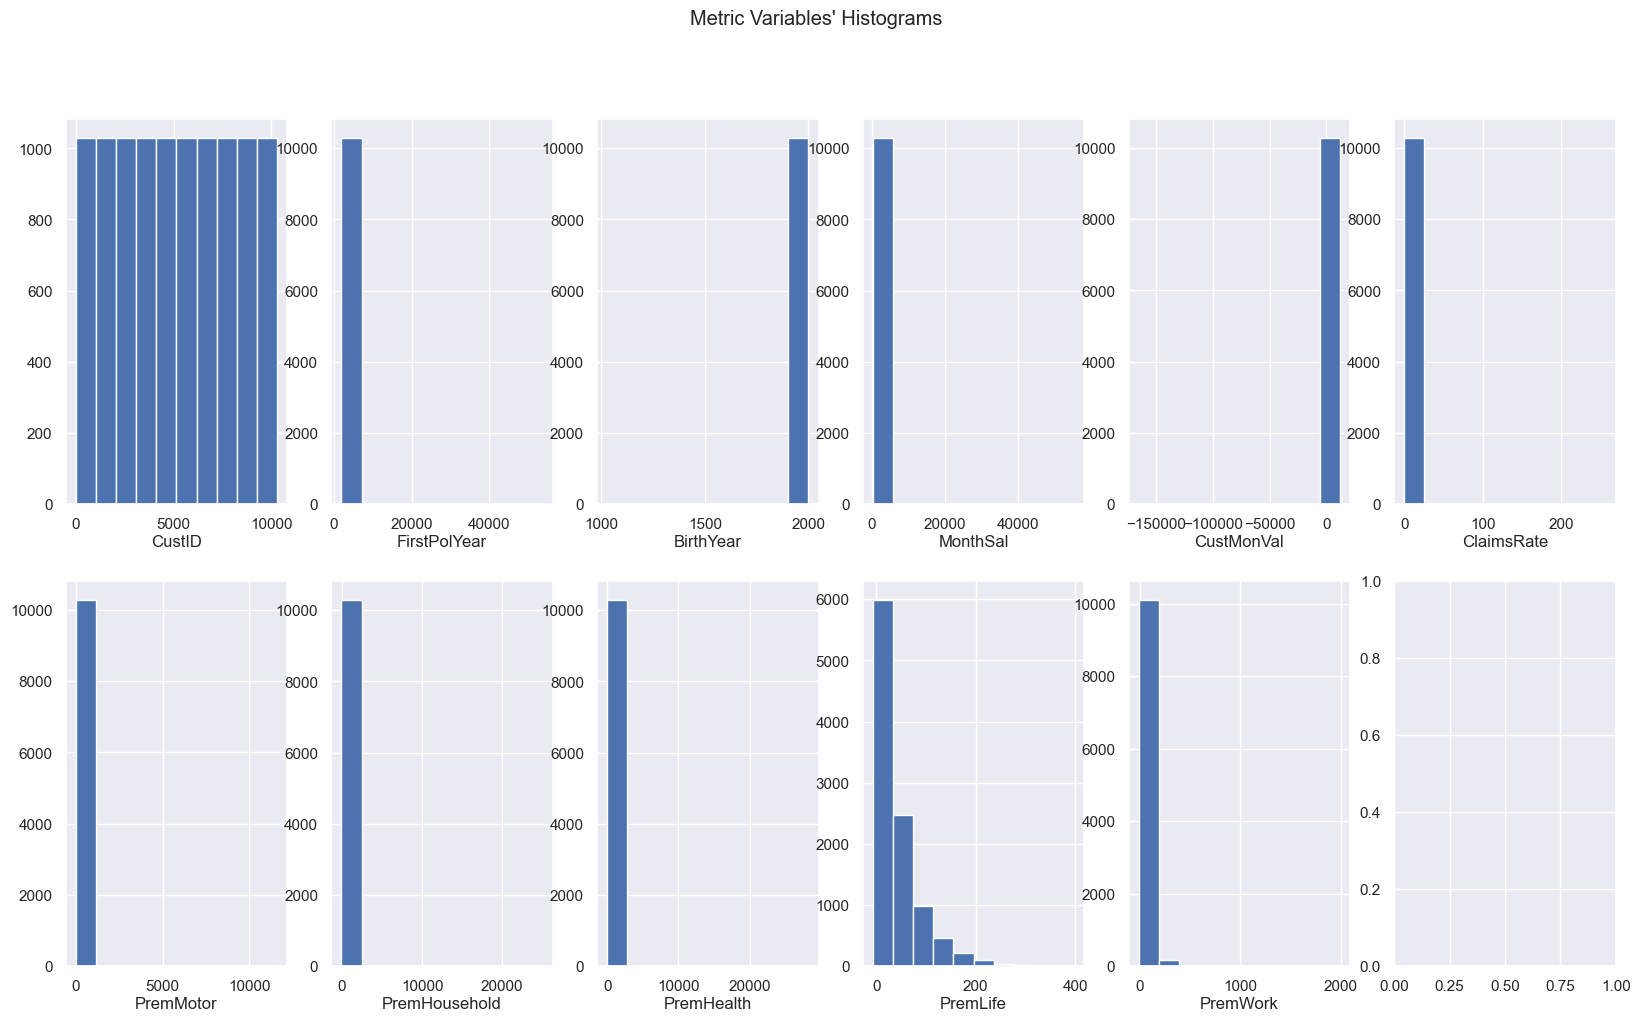

In [17]:
# Get a depper visual understanding on metric features through histograms.

# All Metric Variables' Histograms in one figure.
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed.
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features):
    ax.hist(df[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Histograms"

plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

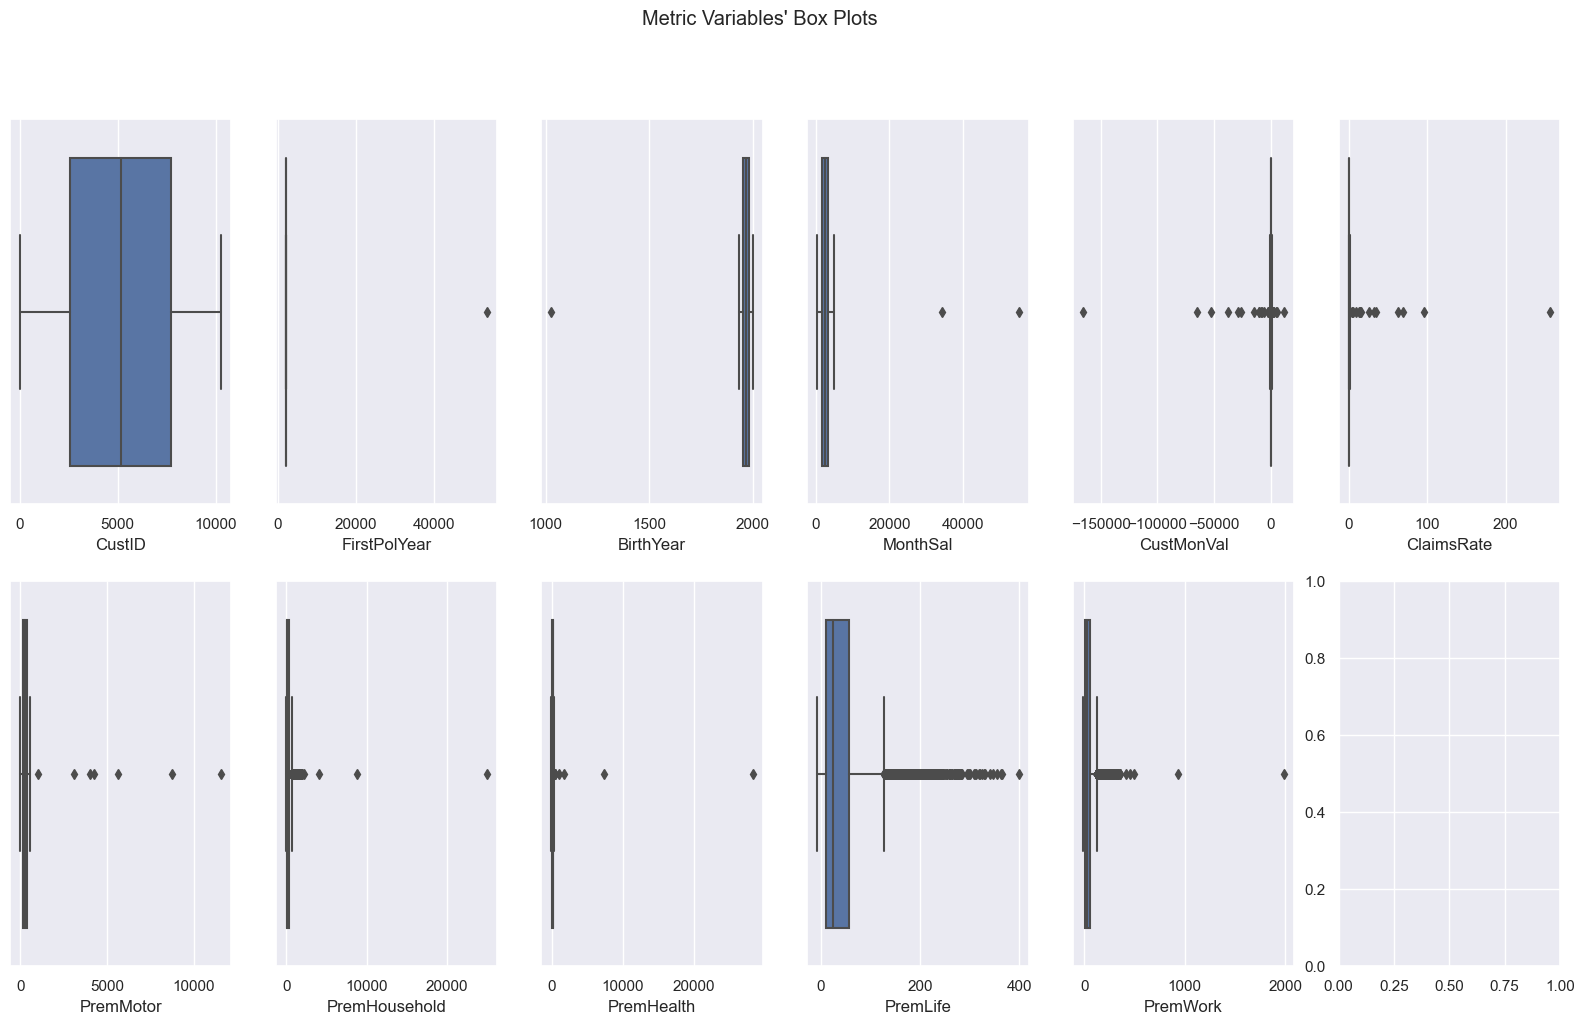

In [18]:
# Get a depper visual understanding on metric features through Box Plots. 
# With this graph, we can have an even better understanding on existing outliers.

# All Metric Variables' Box Plots in one figure.
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed.
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data.
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): 
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Box Plots"

plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()

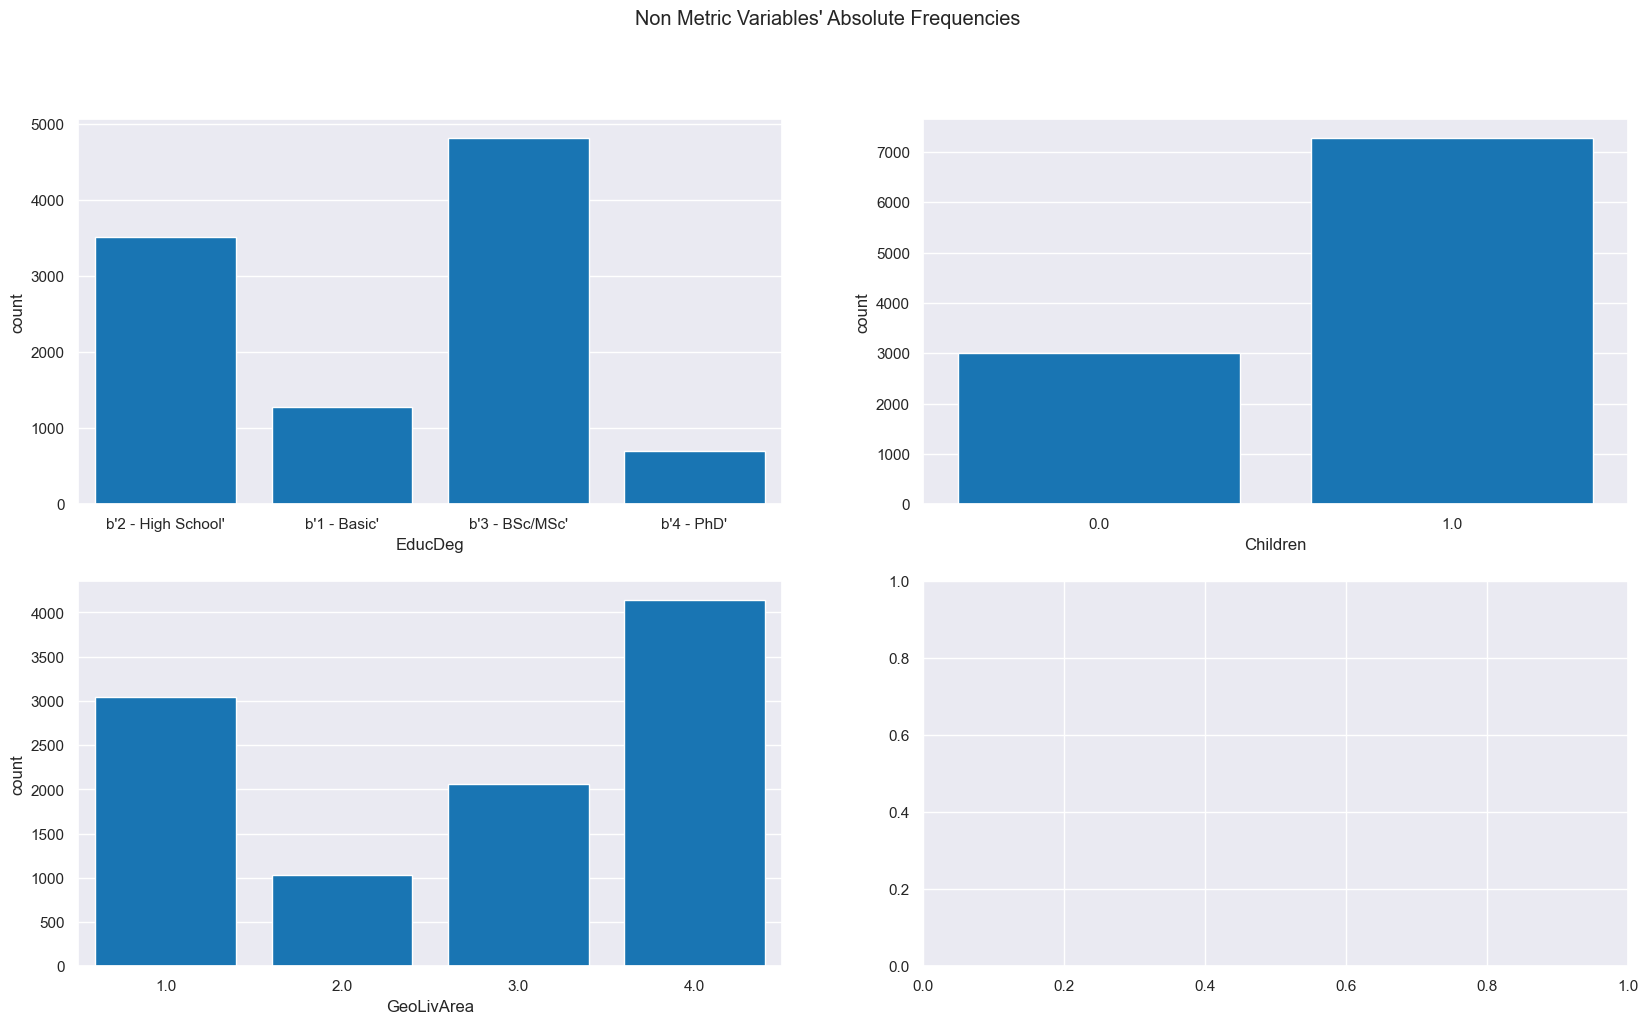

In [19]:
# Get a depper visual understanding on 'non-metric' features through histograms.

# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): 
    sns.countplot(x=df[feat].astype(object), ax=ax, color='#007acc')

title = "Non Metric Variables' Absolute Frequencies"
plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'categorical_variables_frequecies.png'), dpi=200)
plt.show()

# **3. Outliers**

- **3.1) Manual method on Outlier removal**
- 3.1.1) Check % kept
- **3.2) IQR method on Outlier removal**
- 3.2.1) Check % kept
- **3.3) Combined both previous methods on Outlier removal**
- 3.3.1) Check % kept
- **3.4) Took a final look at the graphs to understand the final positions**
- 3.4.1) Checked histrograms
- 3.4.2) Checked box plots

In [20]:
# Outlier Manual Removal (First method).
    # Here, on outliers manual remotion, we decided to look both at the histograms, at the box plots and at the 
    # descriptive statistics resume.
    # In our opinion, all these three were relevant instruments to filter each variable.
        # So, based on these elements, we mostly adopted a 'try and error aproach'.
    
    # We kept the following variables without filters:
        # CustID
        # EducDeg
        # GeoLivArea
        # Children

filters_1 = (
     (df['BirthYear']>=1900) # Mostly, by looking at the histogram.
     &
     (df['ClaimsRate']<=(1.3))  # Although there are slightly more than some residual observations (above 10, by looking at the box plot), we decided to discart them.
     &    
     (df['CustMonVal']>=(-400)) # Mostly, by looking at the histogram.
     &
     (df['CustMonVal']<=(1150)) # Mostly, by looking at the histogram.
     &
     (df['FirstPolYear']<=(2016)) # Since the current year of the database is 2016.
     &
     (df['MonthSal']<=(7000)) # Mostly, by looking at the histogram.
     &
     (df['PremHealth']<=(380)) # Mostly, by looking at the histogram.
     &
     (df['PremHousehold']<=(1100)) # Mostly, by looking at the histogram.
     &
     (df['PremLife']<=(220)) # Mostly, by looking at the box plot.
     &
     (df['PremMotor']<=(600)) # Mostly, by looking at the histogram.
     &
     (df['PremWork']<=(220)) # Mostly, by looking at the box plot.  
)

df_1 = df[filters_1]

print('Percentage of data kept after removing outliers in df_1:', np.round(df_1.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers in df_1: 0.9655


In [21]:
# Outlier IQR Method Removal (Second method).

q25 = df.quantile(.25)
q75 = df.quantile(.75)
iqr = (q75 - q25)

upper_lim = q75 + 1.5 * iqr
lower_lim = q25 - 1.5 * iqr

filters_2 = []
for metric in metric_features:
    llim = lower_lim[metric]
    ulim = upper_lim[metric]
    filters_2.append(df[metric].between(llim, ulim, inclusive='both'))


filters_2 = pd.Series(np.all(filters_2, 0))
df_2 = df[filters_2]
print('Percentage of data kept after removing outliers in df_2:', np.round(df_2.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers in df_2: 0.8541


In [22]:
# Outlier Removal Using both previous methods (Third method).
    # As long as IQR removes a lot of records, we opted for combinning both previous methods, for a more conservative approach.

df_3 = df[(filters_1 | filters_2)]
print('Percentage of data kept after removing outliers in df_3:', np.round(df_3.shape[0] / df_original.shape[0], 4))

Percentage of data kept after removing outliers in df_3: 0.9662


In [23]:
# Confirm the number of records removed under the third method.

len(df_original.axes[0]) # Counting the original number of rows.
len(df_1.axes[0]) # Counting the number of rows under method 1.
len(df_2.axes[0]) # Counting the number of rows under method 2.
len(df_3.axes[0]) # Counting the number of rows under method 3.
len(df_original.axes[0]) - len(df_3.axes[0]) 

348

In [24]:
# Get the combined filtering version.

df = df_3.copy()

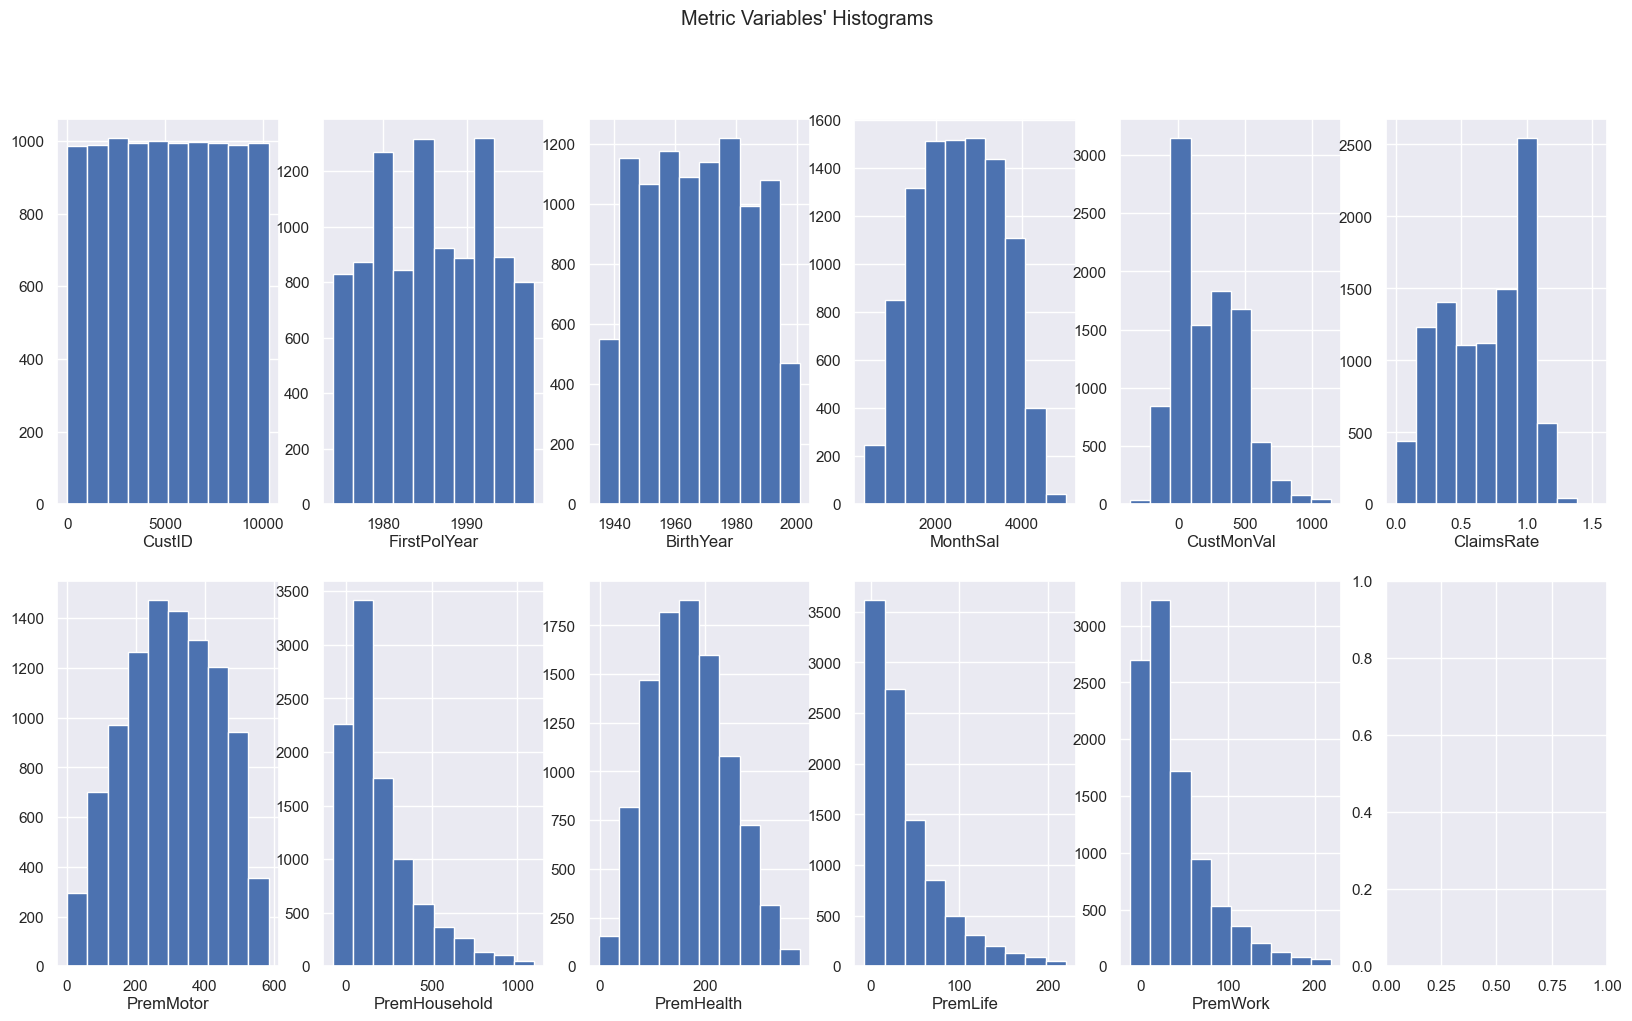

In [25]:
# Check all the histograms from our metric features after outlier removal.

# All Metric Variables' Histograms in one figure.
sns.set()

# Prepare figure. Create individual axes where each histogram will be placed.
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data.
# Iterate across axes objects and associate each histogram (hint: use the ax.hist() instead of plt.hist()):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    ax.hist(df_3[feat])
    ax.set_title(feat, y=-0.13)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Histograms"

plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_histograms.png'), dpi=200)
plt.show()

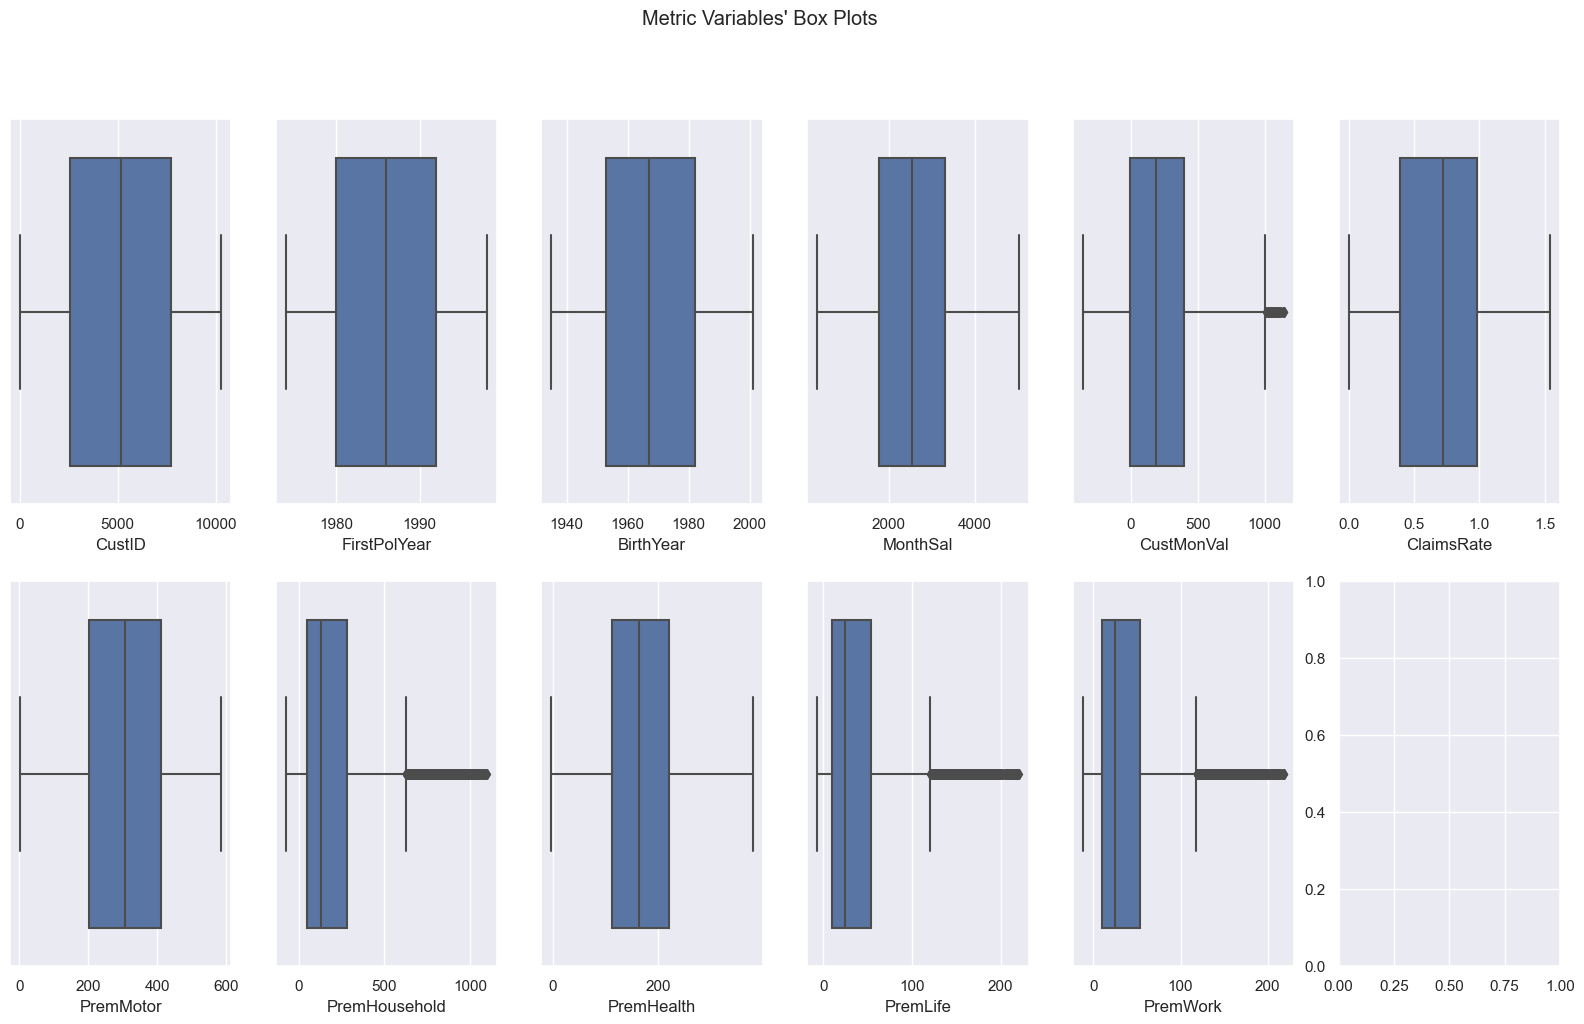

In [26]:
# Check all the box-plots from our metric features after outlier removal.

# All Metric Variables' Box Plots in one figure
sns.set()

# Prepare figure. Create individual axes where each box plot will be placed
fig, axes = plt.subplots(2, ceil(len(metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each box plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), metric_features): # Notice the zip() function and flatten() method
    sns.boxplot(x=df[feat], ax=ax)
    
# Layout
# Add a centered title to the figure:
title = "Metric Variables' Box Plots"

plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'numeric_variables_boxplots.png'), dpi=200)
plt.show()

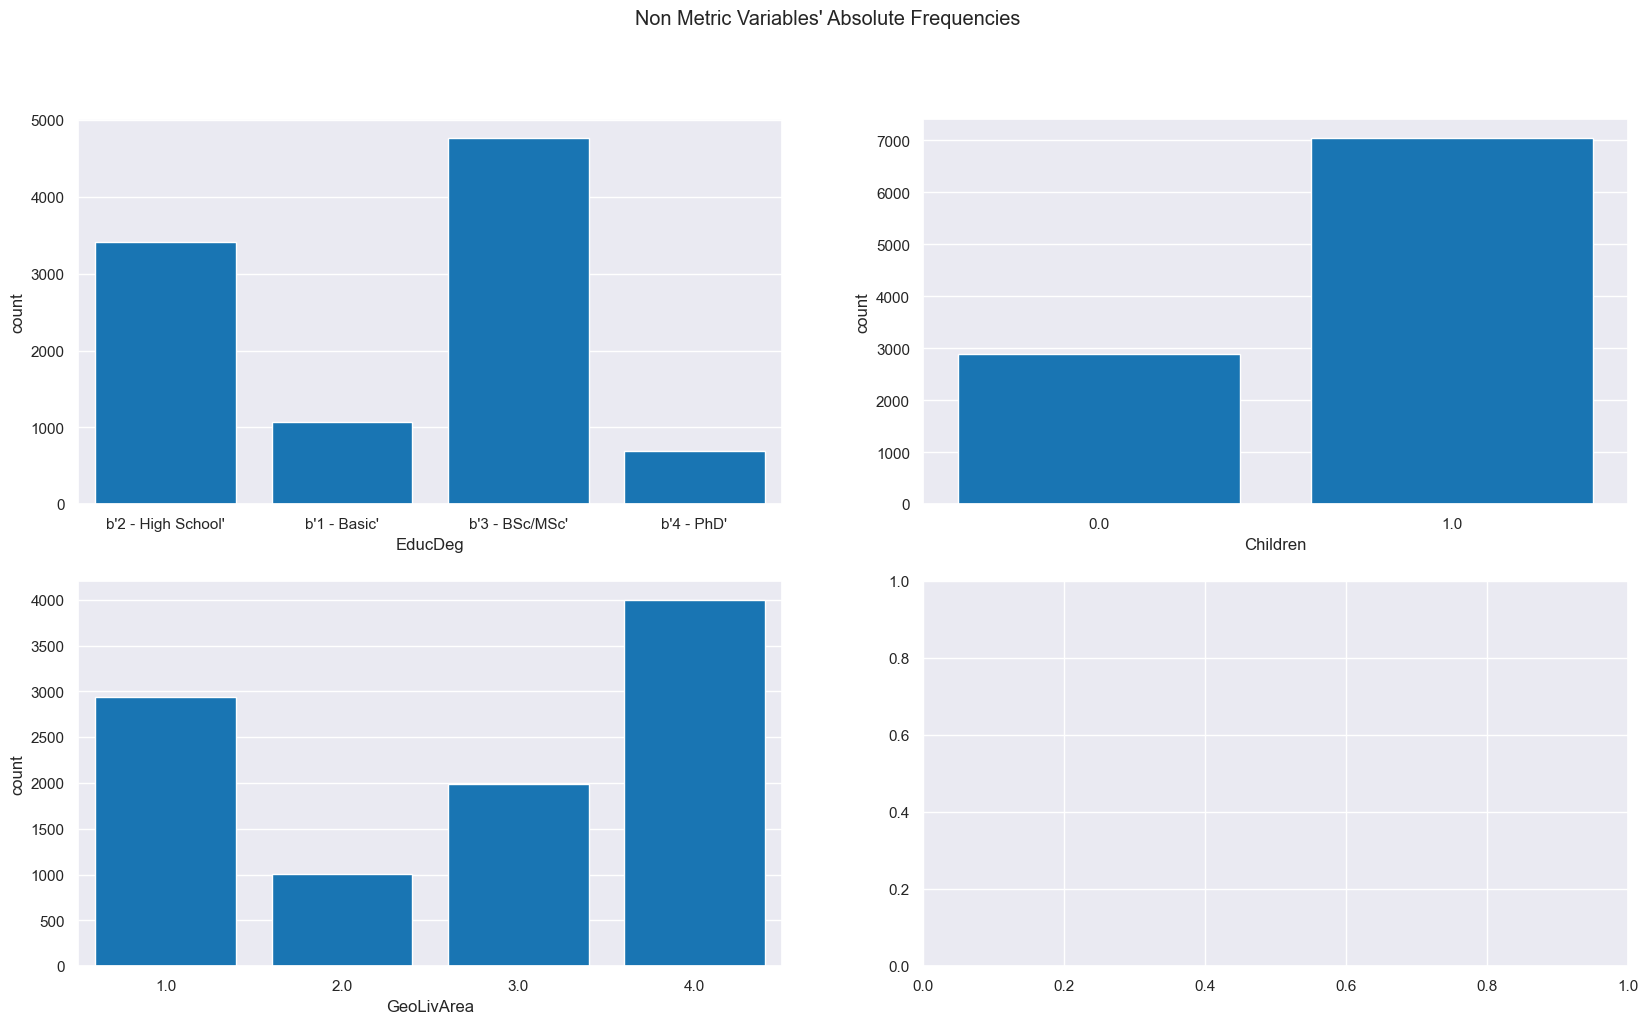

In [27]:
# Check all the histograms from our 'non_metric' features after outlier removal.

# All Non-Metric Variables' Absolute Frequencies
sns.set()

# Prepare figure. Create individual axes where each bar plot will be placed
fig, axes = plt.subplots(2, ceil(len(non_metric_features) / 2), figsize=(20, 11))

# Plot data
# Iterate across axes objects and associate each bar plot (hint: use the ax argument):
for ax, feat in zip(axes.flatten(), non_metric_features): # Notice the zip() function and flatten() method
    sns.countplot(x=df[feat].astype(object), ax=ax, color='#007acc')

title = "Non Metric Variables' Absolute Frequencies"
plt.suptitle(title)

# plt.savefig(os.path.join('..', 'figures', 'categorical_variables_frequecies.png'), dpi=200)
plt.show()

# **4. Feature Engineering**

- **4.1) Variable selection: Redundancy vs Relevancy**
- **4.1.1) Redundancy**
- 4.1.1.1) Feature Creation
- 4.1.1.2) Metric Variables Correlation Matrix
- **4.1.2) Relevancy**
- **4.2) One Hot Enconding**
- **4.3) Data Normalization**

In [28]:
# Redundancy:
    # "(...) An attribute (column or feature of data set) is called redundant if it can be derived from 
    # any other attribute or set of attributes.(...)"
# We have added the following 2 variables: 'Age' and 'PolicyAge'.
# Create relevant features after our group reflection.

df['Age'] = 2016 - df['BirthYear']
df['PolicyAge'] = 2016 - df['FirstPolYear'] 

df.head(10)

CustID  FirstPolYear  BirthYear             EducDeg  MonthSal  GeoLivArea  \
0     1.0        1985.0     1982.0  b'2 - High School'    2177.0         1.0   
1     2.0        1981.0     1995.0  b'2 - High School'     677.0         4.0   
2     3.0        1991.0     1970.0        b'1 - Basic'    2277.0         3.0   
3     4.0        1990.0     1981.0      b'3 - BSc/MSc'    1099.0         4.0   
4     5.0        1986.0     1973.0      b'3 - BSc/MSc'    1763.0         4.0   
5     6.0        1986.0     1956.0  b'2 - High School'    2566.0         4.0   
6     7.0        1979.0     1943.0  b'2 - High School'    4103.0         4.0   
7     8.0        1988.0     1974.0  b'2 - High School'    1743.0         4.0   
8     9.0        1981.0     1978.0      b'3 - BSc/MSc'    1862.0         1.0   
9    10.0        1976.0     1948.0      b'3 - BSc/MSc'    3842.0         1.0   

   Children  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0       1.0      380.97        0.39     375.85          79.45      146.36   
1       1.0     -131.13        1.12      77.46         416.20      116.69   
2       0.0      504.67        0.28     206.15         224.50      124.58   
3       1.0      -16.99        0.99     182.48          43.35      311.17   
4       1.0       35.23        0.90     338.62          47.80      182.59   
5       1.0      -24.33        1.00     440.75          18.90      114.80   
6       0.0      -66.01        1.05     156.92         295.60      317.95   
7       1.0     -144.91        1.13     248.27         397.30      144.36   
8       1.0      356.53        0.36     344.51          18.35      210.04   
9       0.0     -119.35        1.12     209.26         182.25      271.94   

   PremLife  PremWork   Age  PolicyAge  
0     47.01     16.89  34.0       31.0  
1    194.48    106.13  21.0       35.0  
2     86.35     99.02  46.0       25.0  
3     35.34     28.34  35.0       26.0  
4     18.78     41.45  43.0       30.0  
5      7.00      7.67  60.0       30.0  
6     14.67     26.34  73.0       37.0  
7     66.68     53.23  42.0       28.0  
8      8.78      9.89  38.0       35.0  
9     39.23     55.12  68.0       40.0

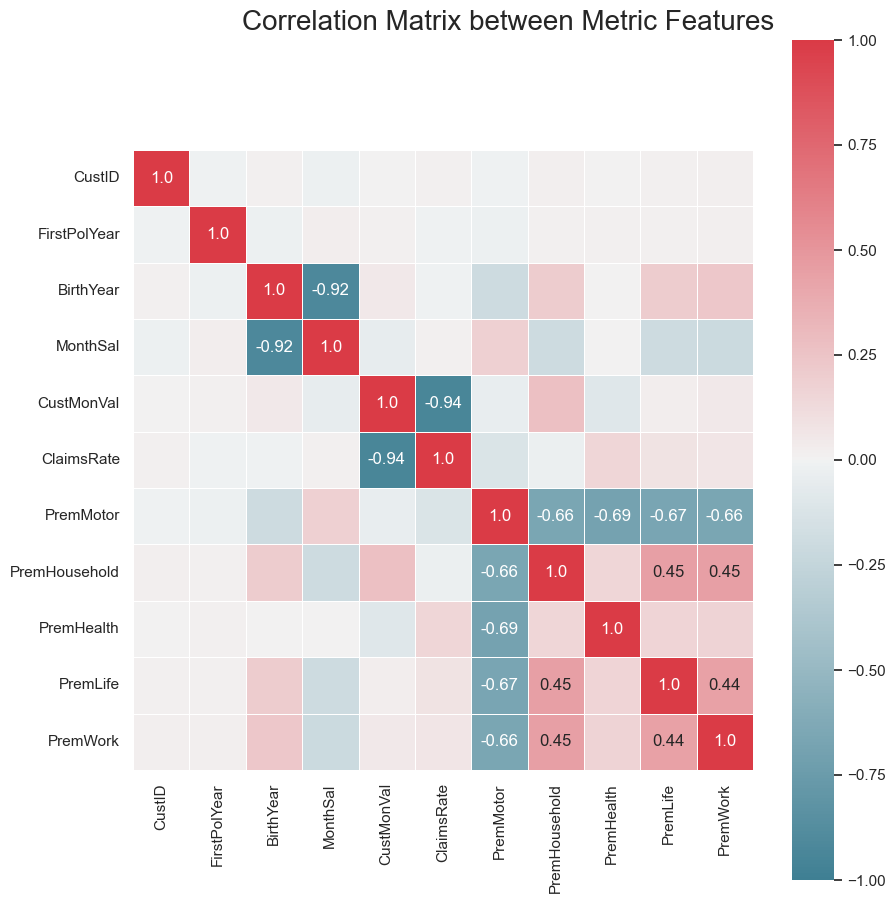

In [29]:
# Check the correlation matrix among the metric features.

# Prepare figure.
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot).
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does.

# Plot heatmap of the correlation matrix
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix between Metric Features", fontsize=20)

# plt.savefig(os.path.join('..', 'figures', 'correlation_matrix.png'), dpi=200)

plt.show()

In [30]:
# Select variables according to their correlations.

df.drop(columns=['BirthYear', 'FirstPolYear', 'CustID'], inplace=True) 

In [31]:
# Update metric_features.

metric_features.remove("BirthYear") # Represented by variable 'Age'.
metric_features.remove("FirstPolYear") # Represented by variable 'PolicyAge'
metric_features.append("Age")
metric_features.append("PolicyAge")

- **4.1) Variable selection: Redundancy vs Relevancy**
- 4.1.2) Relevancy

In [32]:
# Select variables based on the relevancy of each one to the task. 
# We could have removed variables based on two lines of reasoning:
    # Variables that aren't correlated with any other variable;
    # Under our personal judgement, remove based on its significancy.
# We adopted a conservative approach, without removing any variable besides "CustID".

metric_features.remove("CustID") # Not necessary to include in correlation matrix. Does not bring relevant information.

metric_features

['MonthSal',
 'CustMonVal',
 'ClaimsRate',
 'PremMotor',
 'PremHousehold',
 'PremHealth',
 'PremLife',
 'PremWork',
 'Age',
 'PolicyAge']

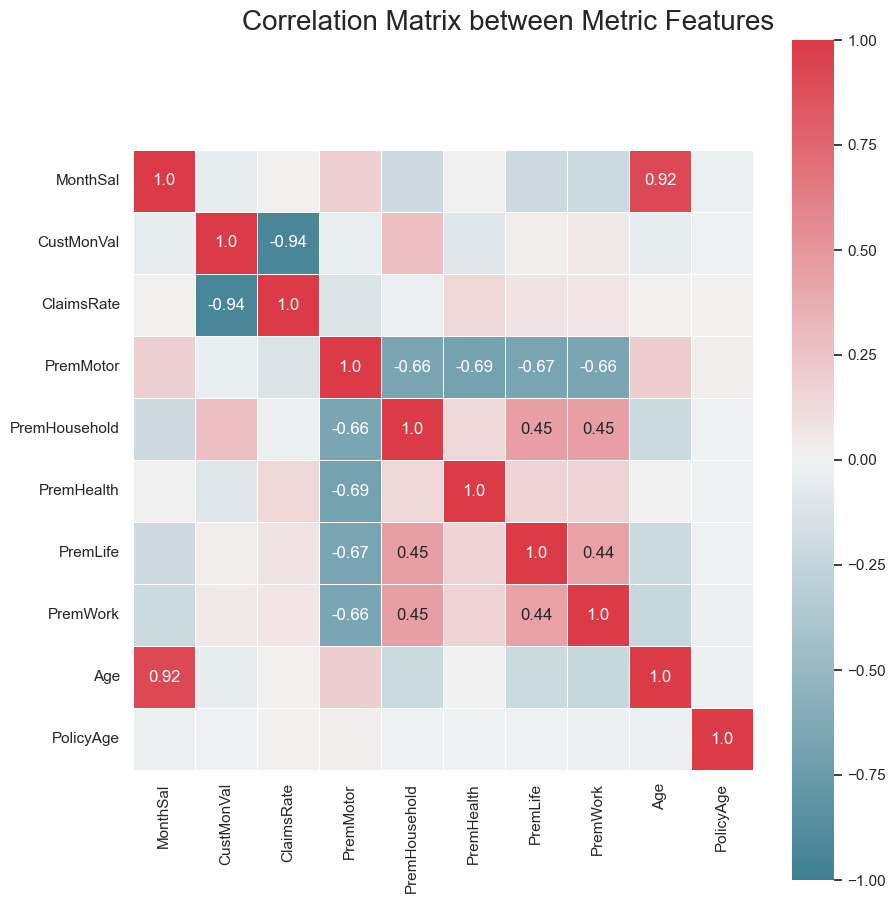

In [33]:
# Check the correlation matrix again after updating metric features.

# Prepare figure.
fig = plt.figure(figsize=(10, 10))

# Obtain correlation matrix. Round the values to 2 decimal cases. Use the DataFrame corr() and round() method.
corr = np.round(df[metric_features].corr(method="pearson"), decimals=2)

# Build annotation matrix (values above |0.5| will appear annotated in the plot).
mask_annot = np.absolute(corr.values) >= 0.3
annot = np.where(mask_annot, corr.values, np.full(corr.shape,"")) # Try to understand what this np.where() does.

# Plot heatmap of the correlation matrix.
sns.heatmap(data=corr, annot=annot, cmap=sns.diverging_palette(220, 10, as_cmap=True), 
            fmt='s', vmin=-1, vmax=1, center=0, square=True, linewidths=.5)

# Layout
fig.subplots_adjust(top=0.95)
fig.suptitle("Correlation Matrix between Metric Features", fontsize=20)

# plt.savefig(os.path.join('..', 'figures', 'correlation_matrix.png'), dpi=200)

plt.show()

- **4.2) One Hot Enconding**

In [34]:
# Create a safety copy of our dataset before applyng one hot encoding.

df_ohc = df.copy()

In [35]:
# Use 'OneHotEncoder' to encode the categorical features. 
# Get feature names and create a DataFrame by 'OneHotEncoding' categorical features (pass feature names).

ohc = OneHotEncoder(sparse=False)
ohc_feat = ohc.fit_transform(df_ohc[non_metric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=df_ohc.index, columns=ohc_feat_names) 
ohc_df

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


x0_b'1 - Basic'  x0_b'2 - High School'  x0_b'3 - BSc/MSc'  \
0                  0.0                    1.0                0.0   
1                  0.0                    1.0                0.0   
2                  1.0                    0.0                0.0   
3                  0.0                    0.0                1.0   
4                  0.0                    0.0                1.0   
...                ...                    ...                ...   
10290              1.0                    0.0                0.0   
10291              0.0                    0.0                0.0   
10293              0.0                    0.0                1.0   
10294              1.0                    0.0                0.0   
10295              0.0                    0.0                0.0   

       x0_b'4 - PhD'  x1_0.0  x1_1.0  x2_1.0  x2_2.0  x2_3.0  x2_4.0  
0                0.0     0.0     1.0     1.0     0.0     0.0     0.0  
1                0.0     0.0     1.0     0.0     0.0     0.0     1.0  
2                0.0     1.0     0.0     0.0     0.0     1.0     0.0  
3                0.0     0.0     1.0     0.0     0.0     0.0     1.0  
4                0.0     0.0     1.0     0.0     0.0     0.0     1.0  
...              ...     ...     ...     ...     ...     ...     ...  
10290            0.0     0.0     1.0     0.0     0.0     1.0     0.0  
10291            1.0     1.0     0.0     0.0     1.0     0.0     0.0  
10293            0.0     0.0     1.0     1.0     0.0     0.0     0.0  
10294            0.0     0.0     1.0     0.0     1.0     0.0     0.0  
10295            1.0     0.0     1.0     1.0     0.0     0.0     0.0  

[9948 rows x 10 columns]

In [36]:
# Reassign df to contain ohc variables.

df_ohc = pd.concat([df_ohc.drop(columns=non_metric_features), ohc_df], axis=1)
df_ohc.head()

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0    2177.0      380.97        0.39     375.85          79.45      146.36   
1     677.0     -131.13        1.12      77.46         416.20      116.69   
2    2277.0      504.67        0.28     206.15         224.50      124.58   
3    1099.0      -16.99        0.99     182.48          43.35      311.17   
4    1763.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork   Age  PolicyAge  x0_b'1 - Basic'  \
0     47.01     16.89  34.0       31.0              0.0   
1    194.48    106.13  21.0       35.0              0.0   
2     86.35     99.02  46.0       25.0              1.0   
3     35.34     28.34  35.0       26.0              0.0   
4     18.78     41.45  43.0       30.0              0.0   

   x0_b'2 - High School'  x0_b'3 - BSc/MSc'  x0_b'4 - PhD'  x1_0.0  x1_1.0  \
0                    1.0                0.0            0.0     0.0     1.0   
1                    1.0                0.0            0.0     0.0     1.0   
2                    0.0                0.0            0.0     1.0     0.0   
3                    0.0                1.0            0.0     0.0     1.0   
4                    0.0                1.0            0.0     0.0     1.0   

   x2_1.0  x2_2.0  x2_3.0  x2_4.0  
0     1.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     1.0  
2     0.0     0.0     1.0     0.0  
3     0.0     0.0     0.0     1.0  
4     0.0     0.0     0.0     1.0

In [37]:
# Retake the original dataset for a cleaner interpretation.

df = df_ohc.copy()
df.head()

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0    2177.0      380.97        0.39     375.85          79.45      146.36   
1     677.0     -131.13        1.12      77.46         416.20      116.69   
2    2277.0      504.67        0.28     206.15         224.50      124.58   
3    1099.0      -16.99        0.99     182.48          43.35      311.17   
4    1763.0       35.23        0.90     338.62          47.80      182.59   

   PremLife  PremWork   Age  PolicyAge  x0_b'1 - Basic'  \
0     47.01     16.89  34.0       31.0              0.0   
1    194.48    106.13  21.0       35.0              0.0   
2     86.35     99.02  46.0       25.0              1.0   
3     35.34     28.34  35.0       26.0              0.0   
4     18.78     41.45  43.0       30.0              0.0   

   x0_b'2 - High School'  x0_b'3 - BSc/MSc'  x0_b'4 - PhD'  x1_0.0  x1_1.0  \
0                    1.0                0.0            0.0     0.0     1.0   
1                    1.0                0.0            0.0     0.0     1.0   
2                    0.0                0.0            0.0     1.0     0.0   
3                    0.0                1.0            0.0     0.0     1.0   
4                    0.0                1.0            0.0     0.0     1.0   

   x2_1.0  x2_2.0  x2_3.0  x2_4.0  
0     1.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     1.0  
2     0.0     0.0     1.0     0.0  
3     0.0     0.0     0.0     1.0  
4     0.0     0.0     0.0     1.0

- **4.3) Data Normalization**

In [38]:
# Make a second security copy of our dataset before normalization.

df_before_scaling = df.copy(deep=True)

In [39]:
# Use 'StandardScaler' to scale the data. Altough we also tried 'MinMax' scaler, we have obtained better results with
# 'StandardScaler'.

scaler_SS = StandardScaler()
scaled_feat_SS = scaler_SS.fit_transform(df[metric_features])
scaled_feat_SS

array([[-0.36573482,  0.68374754, -0.91595895, ..., -0.52163325,
        -0.85355121,  0.15632936],
       [-1.91718332, -1.41823673,  1.39822576, ...,  1.66843945,
        -1.61727419,  0.76193936],
       [-0.26230492,  1.19149106, -1.26467172, ...,  1.49395025,
        -0.14857615, -0.75208565],
       ...,
       [ 0.40068074,  1.27124414, -1.48657984, ..., -0.81612981,
        -0.50106368, -1.20629315],
       [-0.57880042,  0.14636856, -0.09172878, ...,  1.83483001,
        -0.5598116 ,  0.76193936],
       [ 0.29414794,  1.02352934, -1.29637288, ..., -0.61979877,
        -0.79480329, -0.60068315]])

In [40]:
# Updat our dataframe.

df[metric_features] = scaled_feat_SS
df.head()

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0 -0.365735    0.683748   -0.915959   0.536907      -0.544527   -0.305702   
1 -1.917183   -1.418237    1.398226  -1.694840       1.054968   -0.710036   
2 -0.262305    1.191491   -1.264672  -0.732329       0.144432   -0.602513   
3 -1.480709   -0.949734    0.986111  -0.909364      -0.715995    1.940278   
4 -0.793935   -0.735389    0.700800   0.258453      -0.694858    0.188029   

   PremLife  PremWork       Age  PolicyAge  x0_b'1 - Basic'  \
0  0.198950 -0.521633 -0.853551   0.156329              0.0   
1  3.777013  1.668439 -1.617274   0.761939              0.0   
2  1.153456  1.493950 -0.148576  -0.752086              1.0   
3 -0.084199 -0.240634 -0.794803  -0.600683              0.0   
4 -0.485994  0.081103 -0.324820   0.004927              0.0   

   x0_b'2 - High School'  x0_b'3 - BSc/MSc'  x0_b'4 - PhD'  x1_0.0  x1_1.0  \
0                    1.0                0.0            0.0     0.0     1.0   
1                    1.0                0.0            0.0     0.0     1.0   
2                    0.0                0.0            0.0     1.0     0.0   
3                    0.0                1.0            0.0     0.0     1.0   
4                    0.0                1.0            0.0     0.0     1.0   

   x2_1.0  x2_2.0  x2_3.0  x2_4.0  
0     1.0     0.0     0.0     0.0  
1     0.0     0.0     0.0     1.0  
2     0.0     0.0     1.0     0.0  
3     0.0     0.0     0.0     1.0  
4     0.0     0.0     0.0     1.0

In [41]:
# Check descriptive statistics again after normalization (rounded to 3 decimal places).

df[metric_features].describe().T.round(3)

count  mean  std    min    25%    50%    75%    max
MonthSal       9948.0   0.0  1.0 -2.273 -0.794  0.006  0.799  2.576
CustMonVal     9948.0  -0.0  1.0 -2.361 -0.914 -0.112  0.751  3.829
ClaimsRate     9948.0  -0.0  1.0 -2.152 -0.916  0.130  0.954  2.730
PremMotor      9948.0  -0.0  1.0 -2.261 -0.761  0.016  0.795  2.103
PremHousehold  9948.0   0.0  1.0 -1.278 -0.690 -0.310  0.406  4.296
PremHealth     9948.0  -0.0  1.0 -2.329 -0.762 -0.065  0.697  2.876
PremLife       9948.0   0.0  1.0 -1.111 -0.702 -0.343  0.371  4.395
PremWork       9948.0   0.0  1.0 -1.231 -0.691 -0.314  0.370  4.439
Age            9948.0   0.0  1.0 -1.970 -0.854  0.028  0.850  1.908
PolicyAge      9948.0  -0.0  1.0 -1.822 -0.903  0.005  0.913  1.822

# **5. K-Means Clustering**

- **5.1) Defining the number of clusters**
- 5.1.1) Inertia
- 5.1.2) Sillhouete Coefficient
- **5.2) Final Clustering Solution**
- **5.3) Key Conclusions**
- **5.4) Assessing using R2**
- **5.5) Cluster Visualization using Tsne**

- **5.1) Defining the number of clusters**

- 5.1.1) Inertia

In [42]:
# Define the range of our clustering analysis.

range_clusters = range(1, 11)

In [43]:
# For loop for inertia. 
# Inertia measures how well a dataset was clustered. Lower values of inertia means better results.

inertia = []
for n_clus in range_clusters:  # Iterate over desired ncluster range (defined in the cell above).
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_)

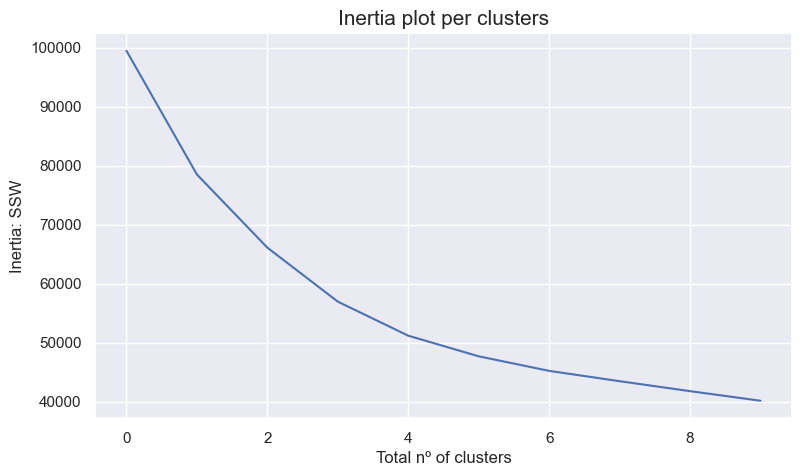

In [44]:
# By observing the elbow method, we should opt for a value between 3 and 5 clusters.
# We opted for defined the number of clusters as 4.
    
# The inertia plot
plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSW")
plt.xlabel("Total nº of clusters")
plt.title("Inertia plot per clusters", size=15)
plt.show()

- 5.1.2) Sillhouete Coefficient

For n_clusters = 2, the average silhouette_score is : 0.23261252475644884
For n_clusters = 3, the average silhouette_score is : 0.19877546694547624
For n_clusters = 4, the average silhouette_score is : 0.21195155880242553
For n_clusters = 5, the average silhouette_score is : 0.21342810301676918
For n_clusters = 6, the average silhouette_score is : 0.2195888958448201
For n_clusters = 7, the average silhouette_score is : 0.20633036767103524
For n_clusters = 8, the average silhouette_score is : 0.19730341623053796
For n_clusters = 9, the average silhouette_score is : 0.18599081537954468
For n_clusters = 10, the average silhouette_score is : 0.16797537720049327


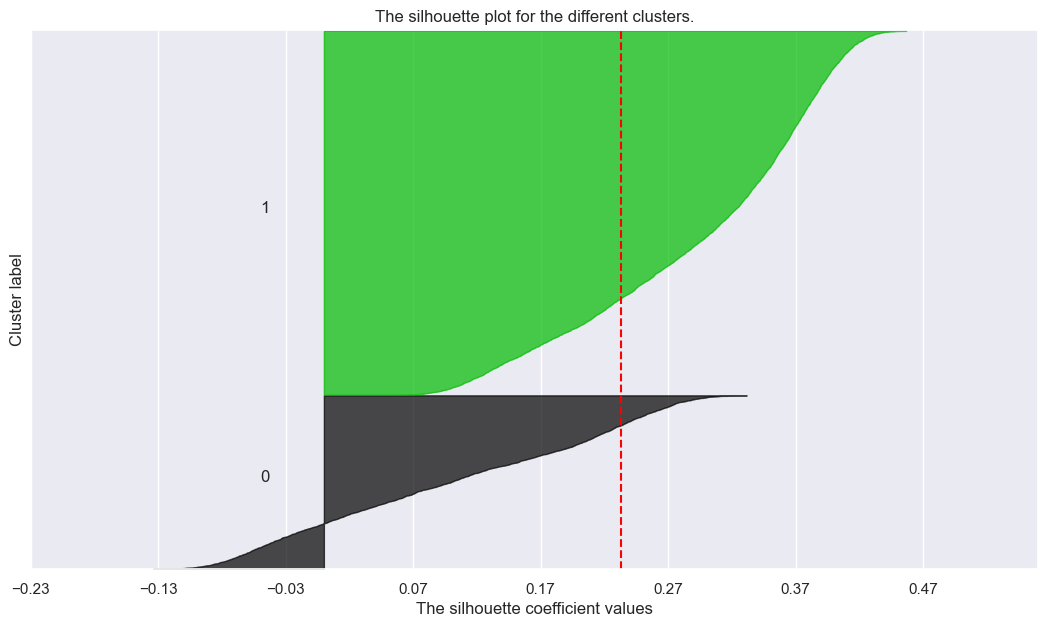

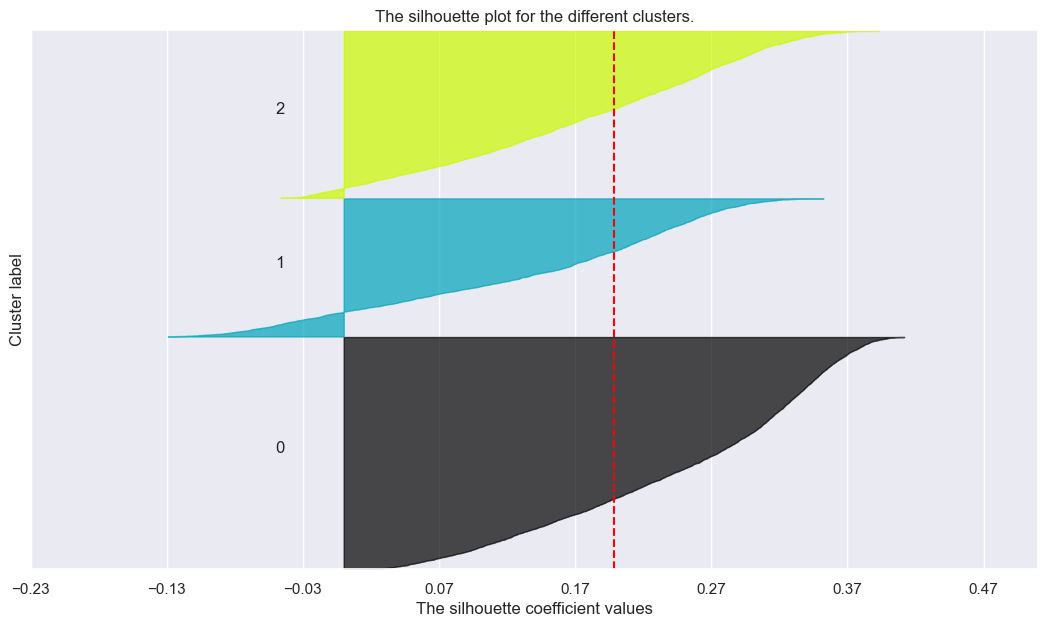

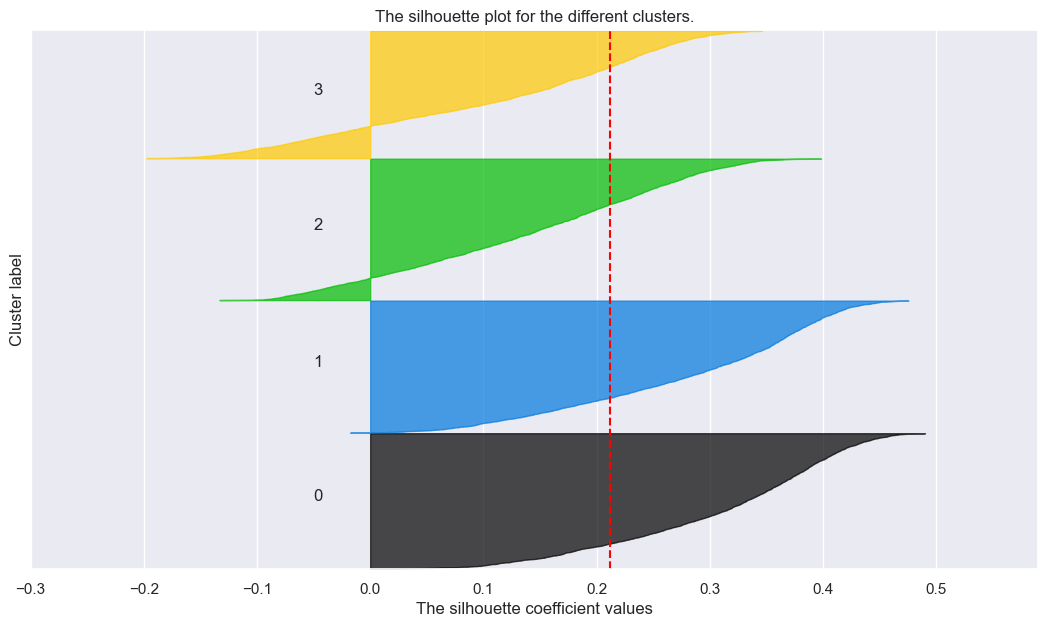

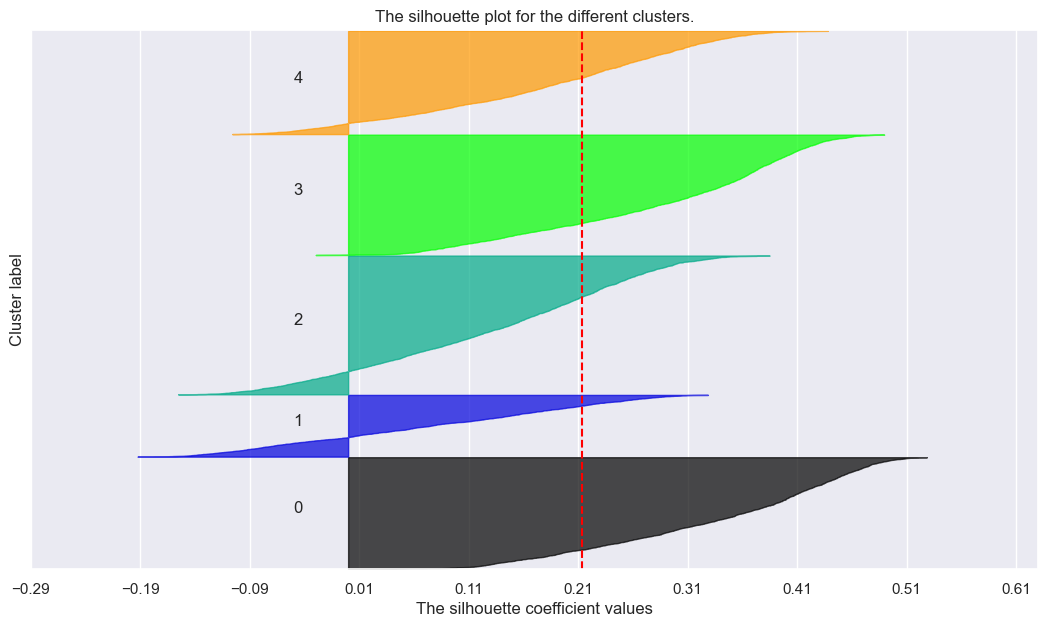

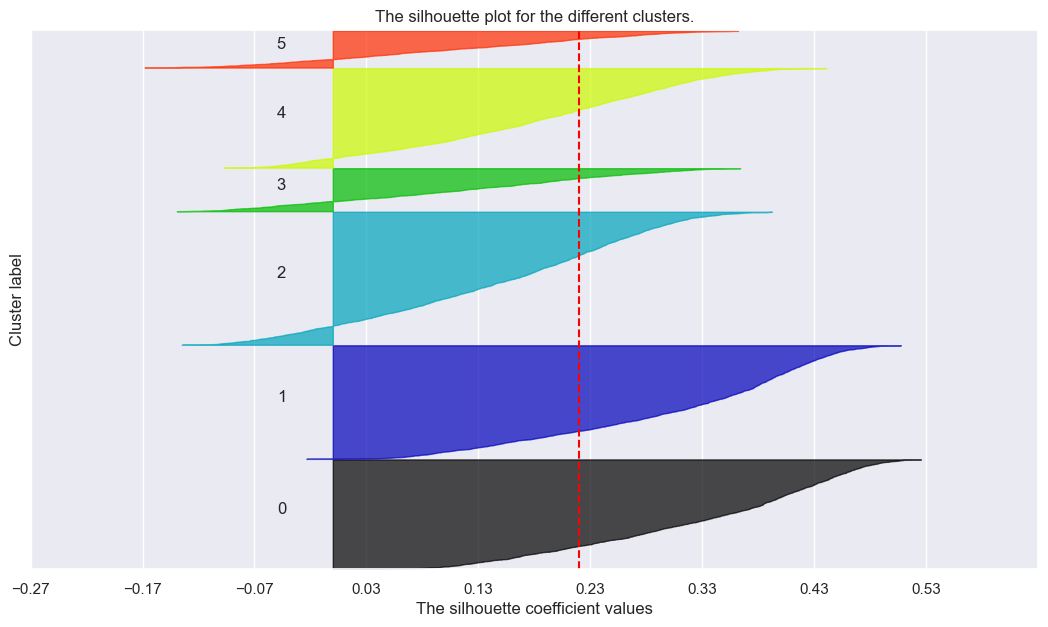

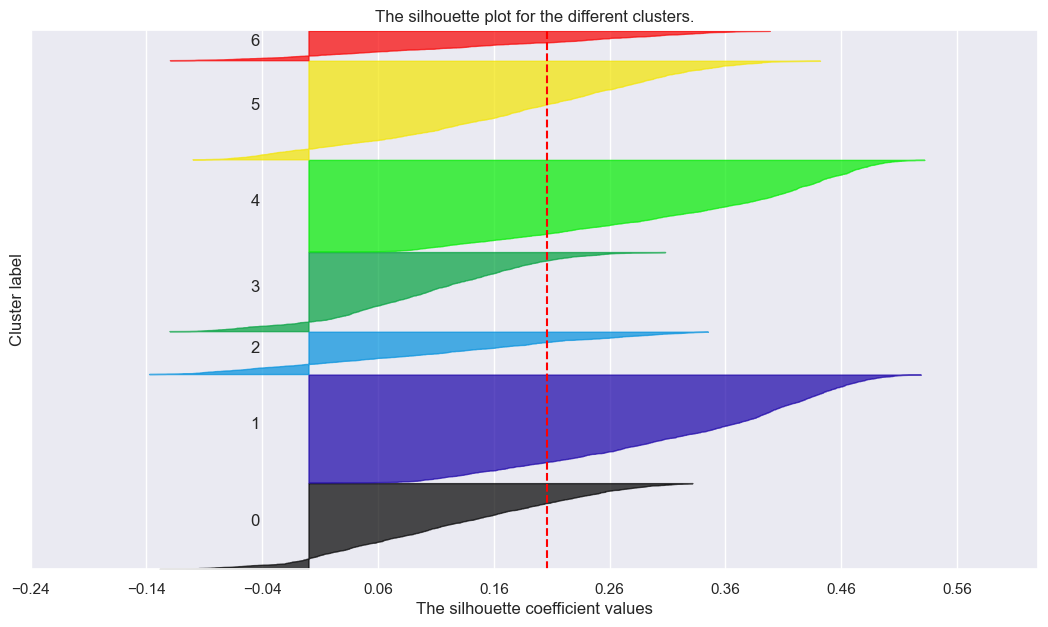

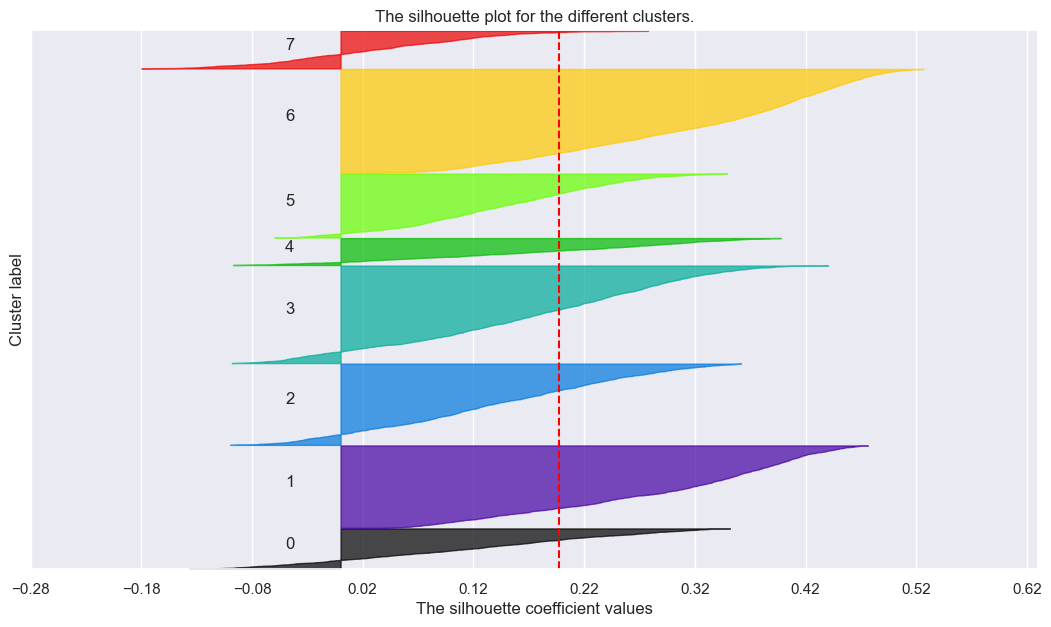

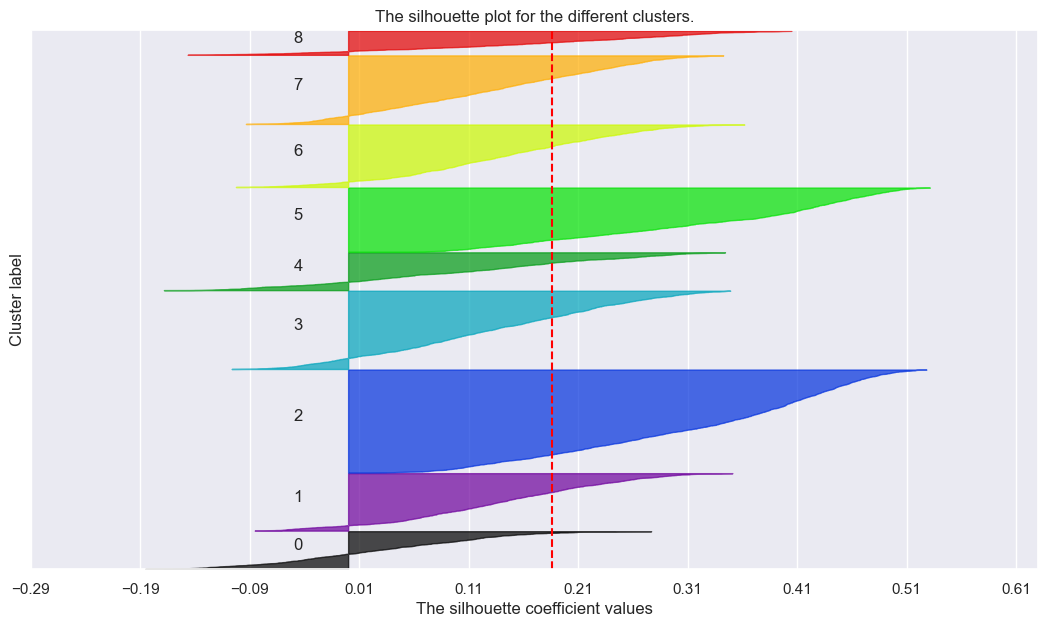

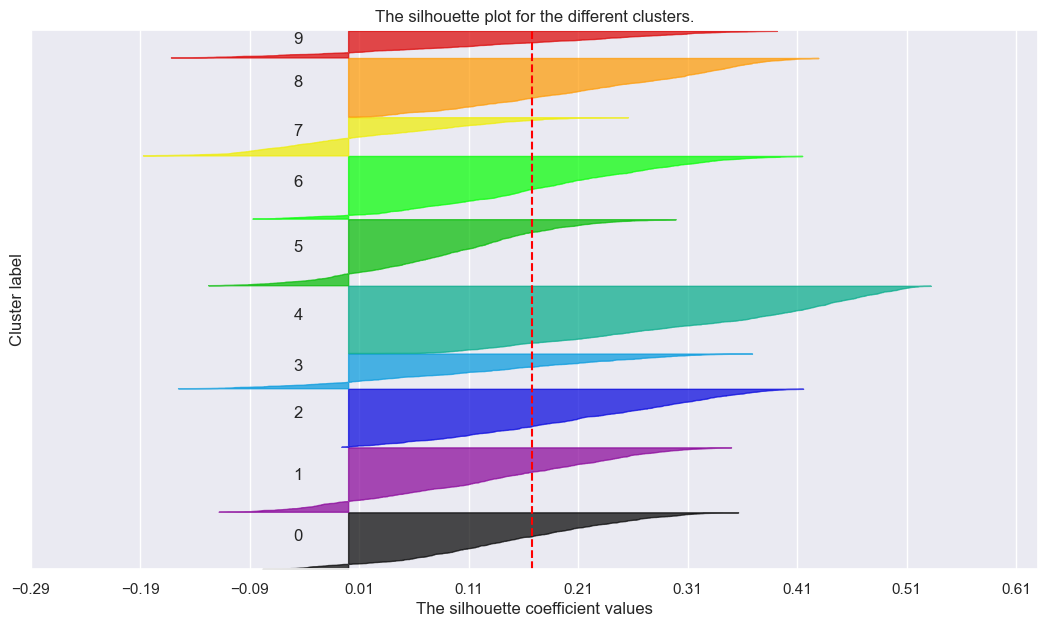

In [45]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Store average silhouette metric.
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the different clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

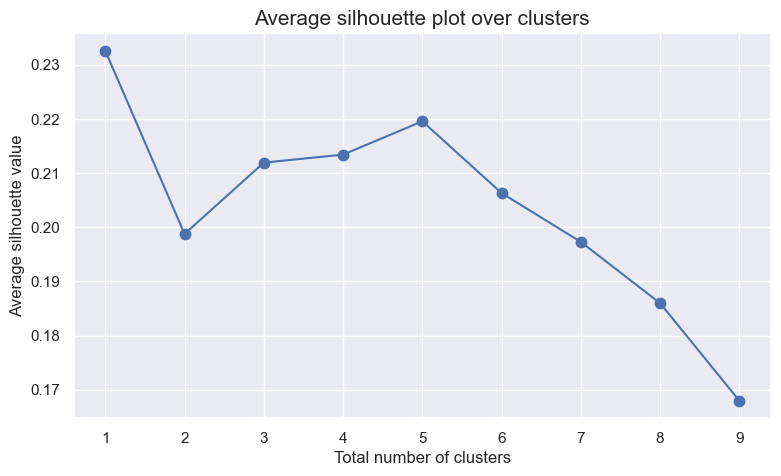

In [46]:
# Draw the average silhouette plot.

plt.figure(figsize=(9,5))
plt.plot(range(1,10), avg_silhouette, marker=".", markersize=15)
plt.ylabel("Average silhouette value")
plt.xlabel("Total number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

- **Observations from Inertia:**
    - By analyzing Inertia graphing, under "Elbow Method", we get to the conclusion that the ideal number of clusters is 4, as long as it presents the lower SSW.
    
    
- **Observations from Silhouette:**    
    - Silhouette tends to start with the highest value, with 1 cluster;
    - Then, it decreases until at 2 clusters and increases again from 2 to 5 clusters, meaning that on average, our observations are better representated with this number of clusters, than the other.
    
    
- **Inertia vs Silhouette:**
    - Our goal is to achieve a small inertia value and a high silhouete value.
    - After discussing, we opted to follow Inertia conclusions, adopting 4 clusters as our final solution.

- **5.2) Final Clustering Solution**
- 5.2.1 Defining the number of clusters and respective labels
- 5.2.2 Getting the final means per variable before and after scaling 

In [47]:
# Our Final cluster solution.

number_clusters = 4
kmclust = KMeans(n_clusters=number_clusters, init='k-means++', n_init=15, random_state=42)
df_km_labels = kmclust.fit_predict(df[metric_features])
df_km_n_clusters = len(np.unique(df_km_labels))
print("Number of estimated kmeans clusters : %d" % df_km_n_clusters)

Number of estimated kmeans clusters : 4


In [48]:
# Characterize the final clusters (after Scalling).

df_kmeans = pd.concat((df, pd.Series(df_km_labels, index=df.index, name='df_km_labels')), axis=1)
df_kmeans_mean = df_kmeans.groupby('df_km_labels').mean()

In [49]:
# Characterize the final clusters (before Scalling).

df_before_scaling_kmeans = pd.concat((df_before_scaling, pd.Series(df_km_labels, index=df_before_scaling.index, name='df_km_labels')), axis=1)
df_before_scaling_kmeans_mean = df_before_scaling_kmeans.groupby('df_km_labels').mean()
df_before_scaling_kmeans_mean

MonthSal  CustMonVal  ClaimsRate   PremMotor  PremHousehold  \
df_km_labels                                                                   
0             3555.281265  188.455131    0.729832  230.356393     237.381543   
1             1427.770087  247.197160    0.700354  159.503005     375.357228   
2             2497.376482   -7.112938    0.977137  412.865467      74.473171   
3             2522.610814  439.516133    0.295929  409.135895      97.650470   

              PremHealth   PremLife   PremWork        Age  PolicyAge  \
df_km_labels                                                           
0             216.339634  48.231102  46.378901  67.173089  29.634554   
1             206.525007  74.051393  73.908822  28.240665  29.885091   
2             126.983136  16.783381  16.566695  47.989893  30.189687   
3             124.872999  17.714202  17.358519  48.528699  30.173669   

              x0_b'1 - Basic'  x0_b'2 - High School'  x0_b'3 - BSc/MSc'  \
df_km_labels                                                              
0                    0.107048               0.409143           0.440381   
1                    0.235394               0.443497           0.303625   
2                    0.047450               0.268090           0.580071   
3                    0.049408               0.252348           0.585953   

              x0_b'4 - PhD'    x1_0.0    x1_1.0    x2_1.0    x2_2.0    x2_3.0  \
df_km_labels                                                                    
0                  0.043429  0.704000  0.296000  0.280381  0.106667  0.191238   
1                  0.017484  0.163326  0.836674  0.306183  0.095949  0.200426   
2                  0.104389  0.125346  0.874654  0.294187  0.106366  0.208383   
3                  0.112291  0.140874  0.859126  0.303797  0.096366  0.202123   

                x2_4.0  
df_km_labels            
0             0.421714  
1             0.397441  
2             0.391064  
3             0.397713

- **5.3) Key Conclusions**

In [50]:
# Compute the transpose (after scalling for the sake of an easier interpretation).

df_kmeans_meanT = df_kmeans_mean.T
df_kmeans_meanT

df_km_labels                  0         1         2         3
MonthSal               1.059820 -1.140663 -0.034370 -0.008270
CustMonVal            -0.106456  0.134659 -0.909192  0.924058
ClaimsRate             0.161349  0.067899  0.945334 -1.214175
PremMotor             -0.551283 -1.081216  0.813757  0.785863
PremHousehold          0.205616  0.860973 -0.568166 -0.458078
PremHealth             0.647959  0.514208 -0.569764 -0.598521
PremLife               0.228578  0.855055 -0.534438 -0.511853
PremWork               0.202065  0.877687 -0.529568 -0.510135
Age                    1.095299 -1.191900 -0.031674 -0.000020
PolicyAge             -0.050403 -0.012471  0.033646  0.031221
x0_b'1 - Basic'        0.107048  0.235394  0.047450  0.049408
x0_b'2 - High School'  0.409143  0.443497  0.268090  0.252348
x0_b'3 - BSc/MSc'      0.440381  0.303625  0.580071  0.585953
x0_b'4 - PhD'          0.043429  0.017484  0.104389  0.112291
x1_0.0                 0.704000  0.163326  0.125346  0.140874
x1_1.0                 0.296000  0.836674  0.874654  0.859126
x2_1.0                 0.280381  0.306183  0.294187  0.303797
x2_2.0                 0.106667  0.095949  0.106366  0.096366
x2_3.0                 0.191238  0.200426  0.208383  0.202123
x2_4.0                 0.421714  0.397441  0.391064  0.397713

In [51]:
# Compute the transpose (before scalling for the sake of an easier interpretation).

df_before_scaling_kmeansT = df_before_scaling_kmeans_mean.T
df_before_scaling_kmeansT

df_km_labels                     0            1            2            3
MonthSal               3555.281265  1427.770087  2497.376482  2522.610814
CustMonVal              188.455131   247.197160    -7.112938   439.516133
ClaimsRate                0.729832     0.700354     0.977137     0.295929
PremMotor               230.356393   159.503005   412.865467   409.135895
PremHousehold           237.381543   375.357228    74.473171    97.650470
PremHealth              216.339634   206.525007   126.983136   124.872999
PremLife                 48.231102    74.051393    16.783381    17.714202
PremWork                 46.378901    73.908822    16.566695    17.358519
Age                      67.173089    28.240665    47.989893    48.528699
PolicyAge                29.634554    29.885091    30.189687    30.173669
x0_b'1 - Basic'           0.107048     0.235394     0.047450     0.049408
x0_b'2 - High School'     0.409143     0.443497     0.268090     0.252348
x0_b'3 - BSc/MSc'         0.440381     0.303625     0.580071     0.585953
x0_b'4 - PhD'             0.043429     0.017484     0.104389     0.112291
x1_0.0                    0.704000     0.163326     0.125346     0.140874
x1_1.0                    0.296000     0.836674     0.874654     0.859126
x2_1.0                    0.280381     0.306183     0.294187     0.303797
x2_2.0                    0.106667     0.095949     0.106366     0.096366
x2_3.0                    0.191238     0.200426     0.208383     0.202123
x2_4.0                    0.421714     0.397441     0.391064     0.397713

- **Cluster 0**: 
    - The mean of ages is equal to 67.
    - The highest PremHousehold
    - There is not a tendency for having children.
    
- **Cluster 1**: 
    - The mean of ages is equal to 28.
    - The highest PremHousehold
    - The lowest PremMotor
    - High tendency for having children.
    
- **Cluster 2**: 
    - The mean of ages is equal to 47.
    - The lowest customer monetary value.
    - The highest claims rate.
    - The lowest PremHousehold
    - High tendency for having children.

- **Cluster 3**: 
    - The mean of ages is equal to 48.
    - The highest value of customer monetary value.
    - The highest claims rate
    - The highest PremMotor
    - The lowest PremHousehold
    - High tendency for having children.

- **5.4) Assessing using R2**

- 5.4.1) Defining SS functions

In [52]:
def get_ss(df):
    """Computes the sum of squares for all variables given a dataset
    """
    ss = np.sum(df.var()*(df.count() - 1))
    return ss  # Return sum of sum of squares of each df variable.

In [53]:
def get_ss_feature(df):
    """Get the SS for each variable
    """
    ss_vars = df.var()*(df.count() - 1)
    return ss_vars

- 5.4.2) Defining r2 functions

In [54]:
def get_r2(df, labels):
    sst = get_ss(df) # Get total sum of squares.
    ssw_labels = df.groupby(by=labels).apply(get_ss)  # Compute ssw for each cluster labels
    ssb = sst - np.sum(ssw_labels)  # Remember: SST = SSW + SSB.
    r2 = ssb / sst
    return r2

In [55]:
def get_r2_feature(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_feature(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_feature))
    return 1 - ssw_vars/sst_vars

In [56]:
# First, we are assessing our clustering solution by using R²:

df_kmeans_r2 =  get_r2(df_kmeans, "df_km_labels")
print("Kmeans Cluster final solution with R² of %0.4f" % df_kmeans_r2);

# Second, we are essentially decomposing the R² into the R² per variable:

get_r2_feature(df_kmeans[metric_features + ['df_km_labels']], 'df_km_labels').drop('df_km_labels').sort_values(axis=0, ascending=False)

Kmeans Cluster final solution with R² of 0.4373


PremMotor        0.676146
Age              0.651695
MonthSal         0.603409
ClaimsRate       0.598067
CustMonVal       0.427621
PremHealth       0.343832
PremWork         0.327722
PremLife         0.323240
PremHousehold    0.319617
PolicyAge        0.001235
dtype: float64

- **From the table above, we can conclude that:**: 
    - The final R2 value for our final cluster solution is 0.4373.
    - The three variables that mostly contribute to the this R2 value are: PremMotor, Age and MonthSal, all above 0.6.

- **5.5) Cluster Visualization using Tsne**

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


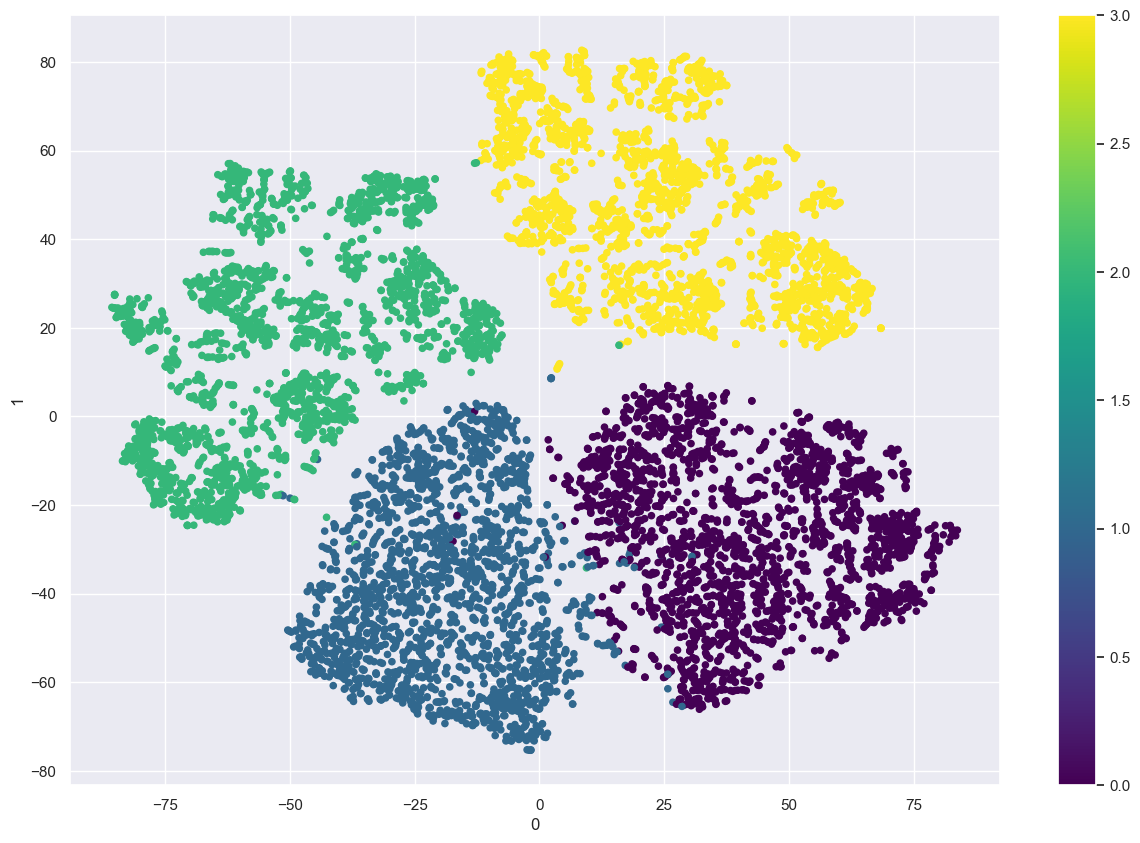

In [57]:
df_kmeans_tsne = TSNE(perplexity=30, random_state=42).fit_transform(df_kmeans)
pd.DataFrame(df_kmeans_tsne).plot.scatter(x=0, y=1, c = df_kmeans['df_km_labels'], colormap='viridis', figsize=(15,10))
plt.show()

#  **6. MiniBatchMeans**

- **6.1) Defining the number of clusters**
- 6.1.1) Inertia
- 6.1.2) Sillhouete Coefficient
- **6.2) Final Clustering Solution**
- **6.3) Key Conclusions**
- **6.4) Assessing using R2**
- **6.5) Cluster Visualization using Tsne**

- **6.1) Defining the number of clusters**
- 6.1.1) Inertia

In [58]:
# Define the range of our clustering analysis.

range_clusters = range(2, 11)

In [59]:
# For loop for inertia. 
# Inertia measures how well a dataset was clustered. Lower values of inertia means better results.

inertia = []  
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = MiniBatchKMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state= 1)
    kmclust.fit(df[metric_features])
    inertia.append(kmclust.inertia_) 
    #n_init = 10, #random_state =15

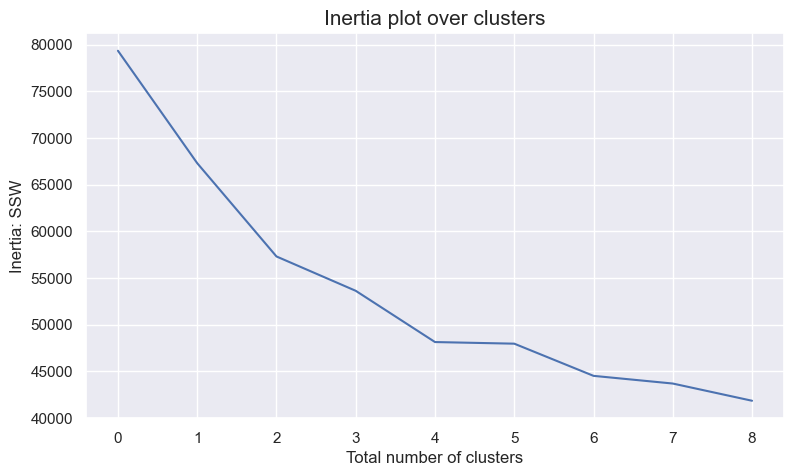

In [60]:
# Draw inertia plot.

plt.figure(figsize=(9,5))
plt.plot(inertia)
plt.ylabel("Inertia: SSW")
plt.xlabel("Total number of clusters")
plt.title("Inertia plot over clusters", size=15)
plt.show()

- **6.1) Defining the number of clusters**
- 6.1.2) Sillhouete Coefficient

For n_clusters = 2, the average silhouette_score is : 0.23261252475644884
For n_clusters = 3, the average silhouette_score is : 0.19877546694547624
For n_clusters = 4, the average silhouette_score is : 0.21195155880242553
For n_clusters = 5, the average silhouette_score is : 0.21342810301676918
For n_clusters = 6, the average silhouette_score is : 0.2195888958448201
For n_clusters = 7, the average silhouette_score is : 0.20633036767103524
For n_clusters = 8, the average silhouette_score is : 0.19730341623053796
For n_clusters = 9, the average silhouette_score is : 0.18599081537954468
For n_clusters = 10, the average silhouette_score is : 0.16797537720049327


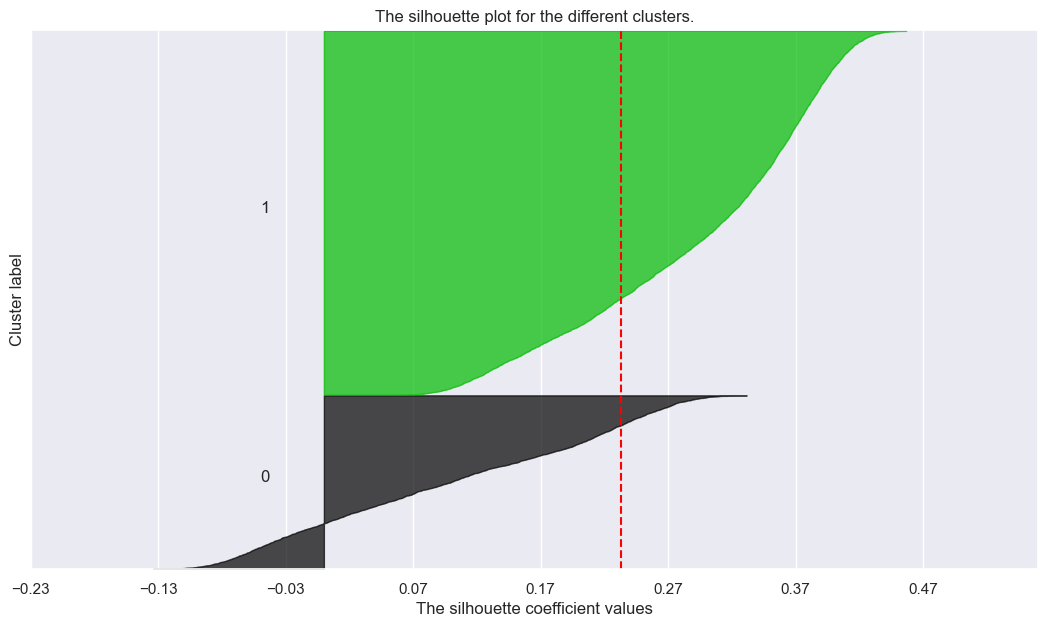

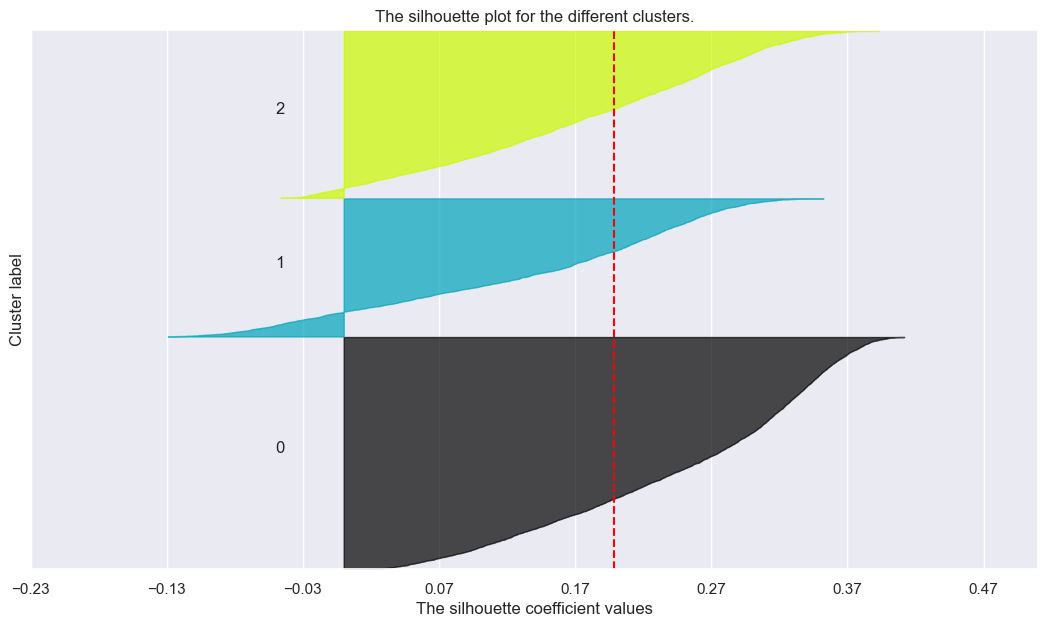

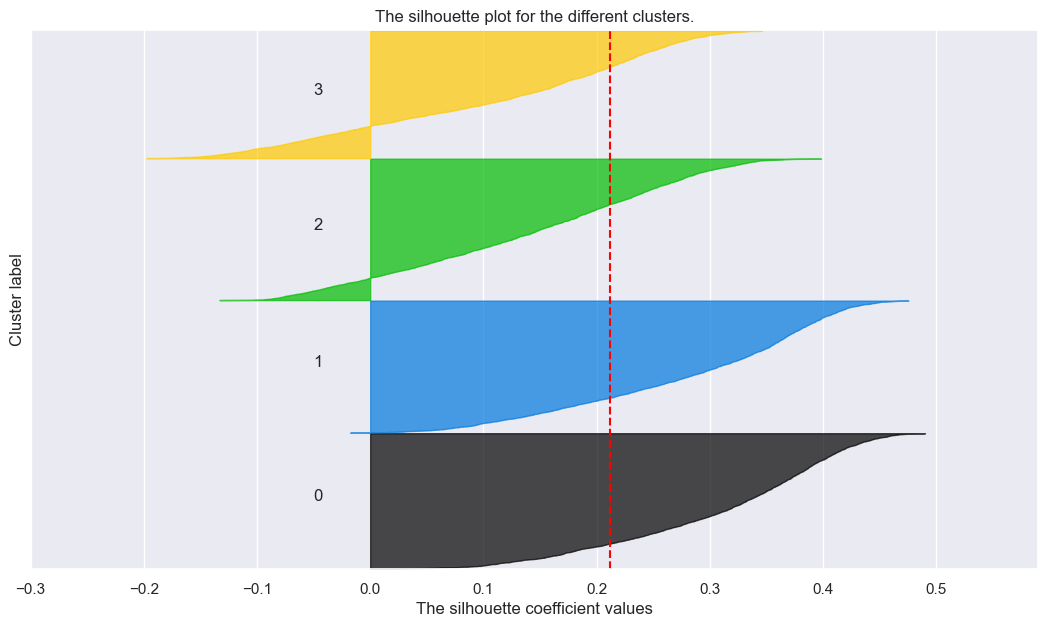

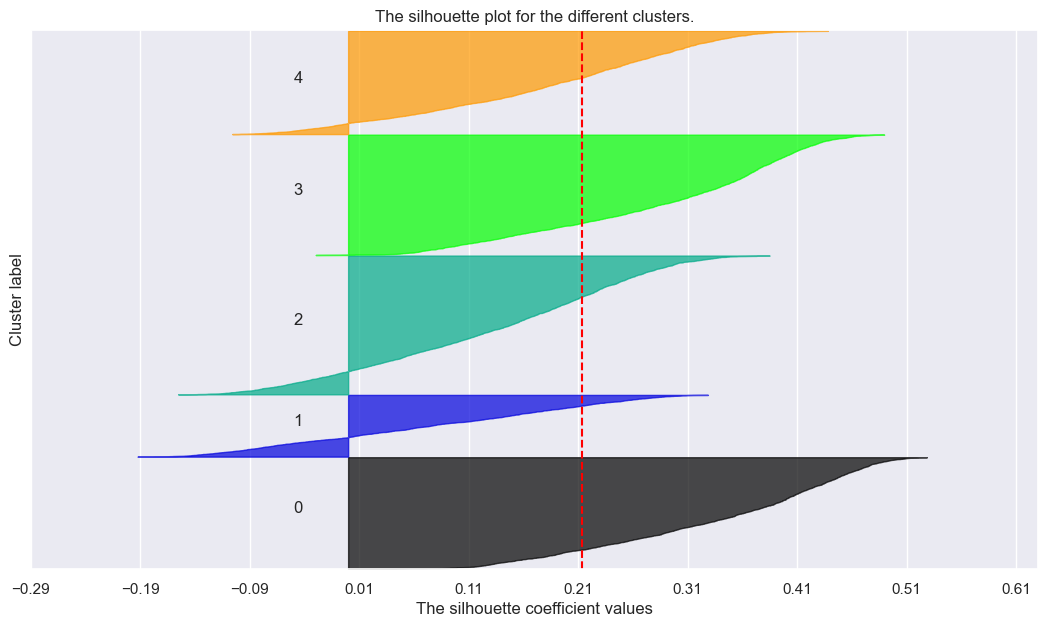

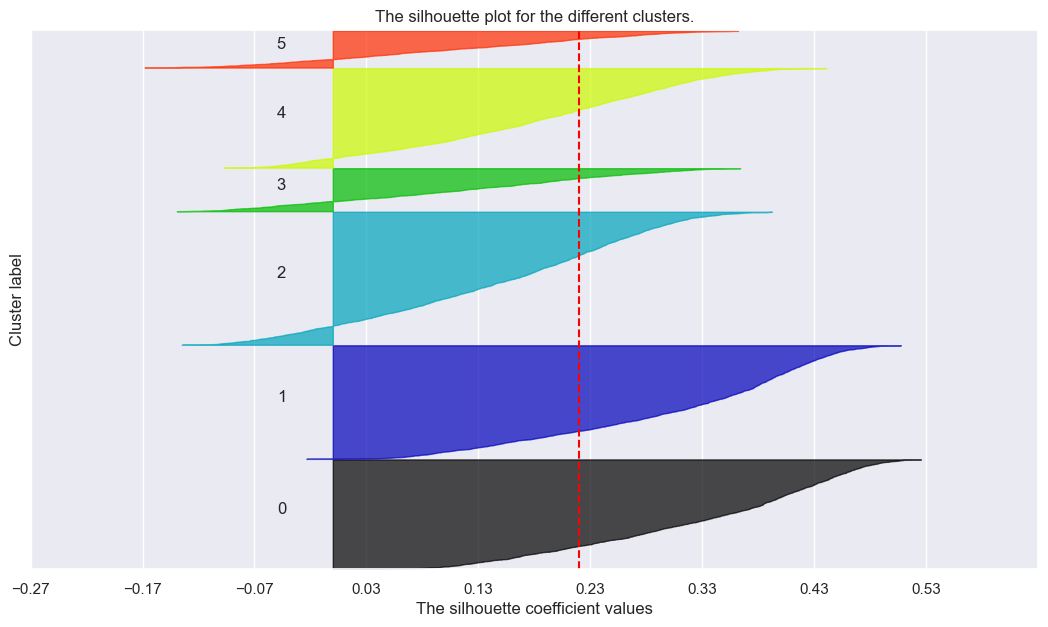

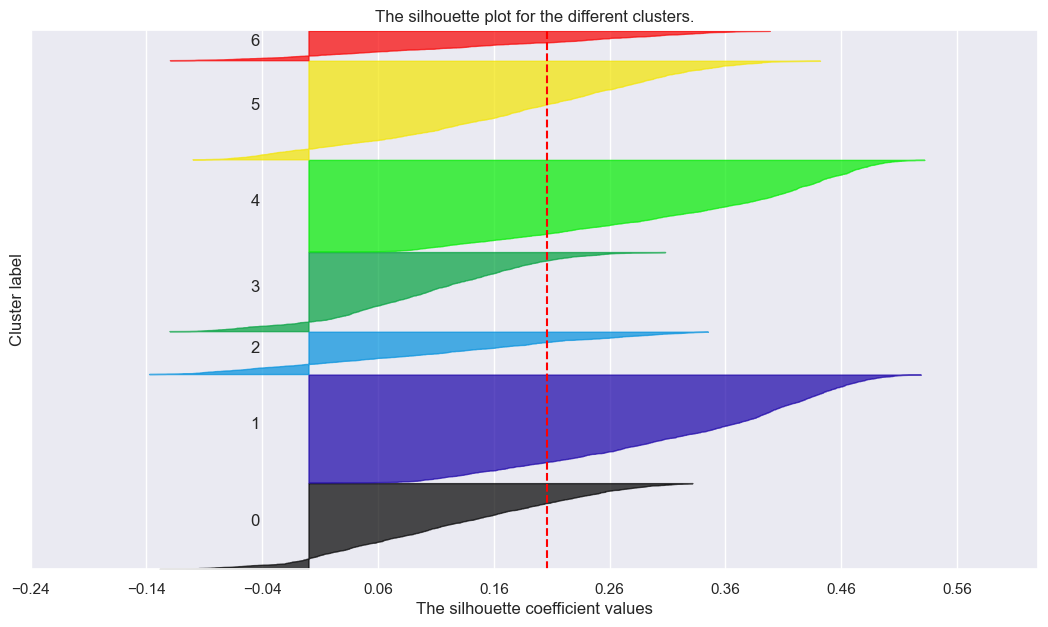

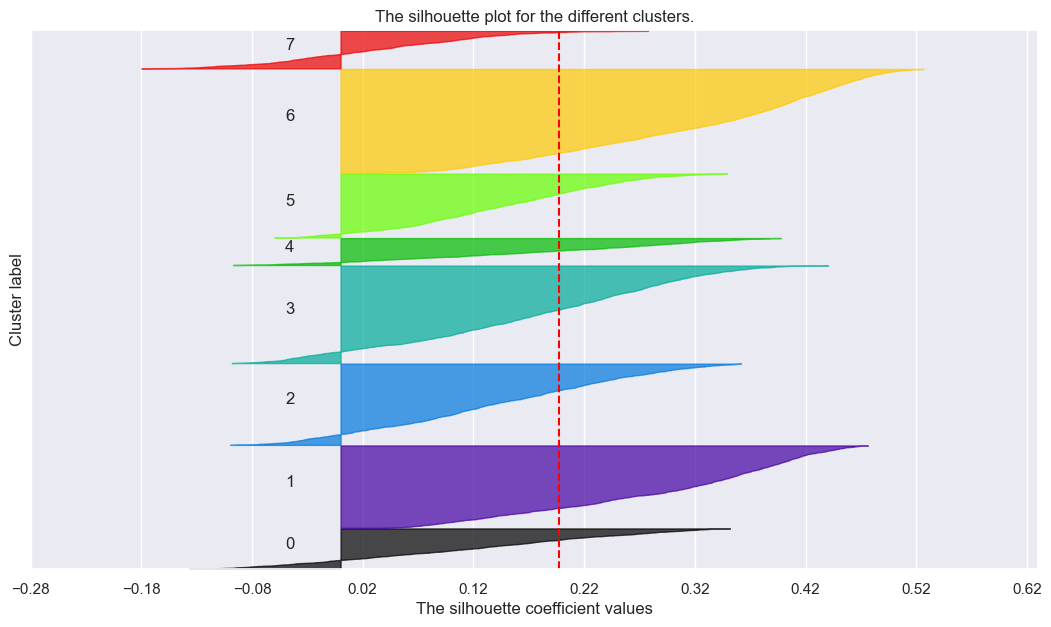

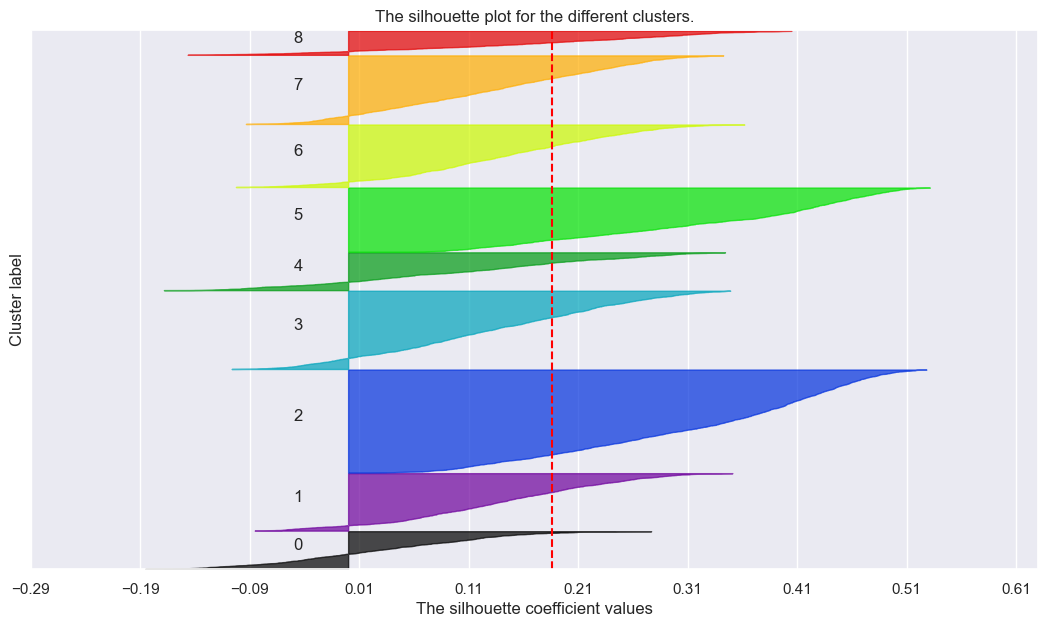

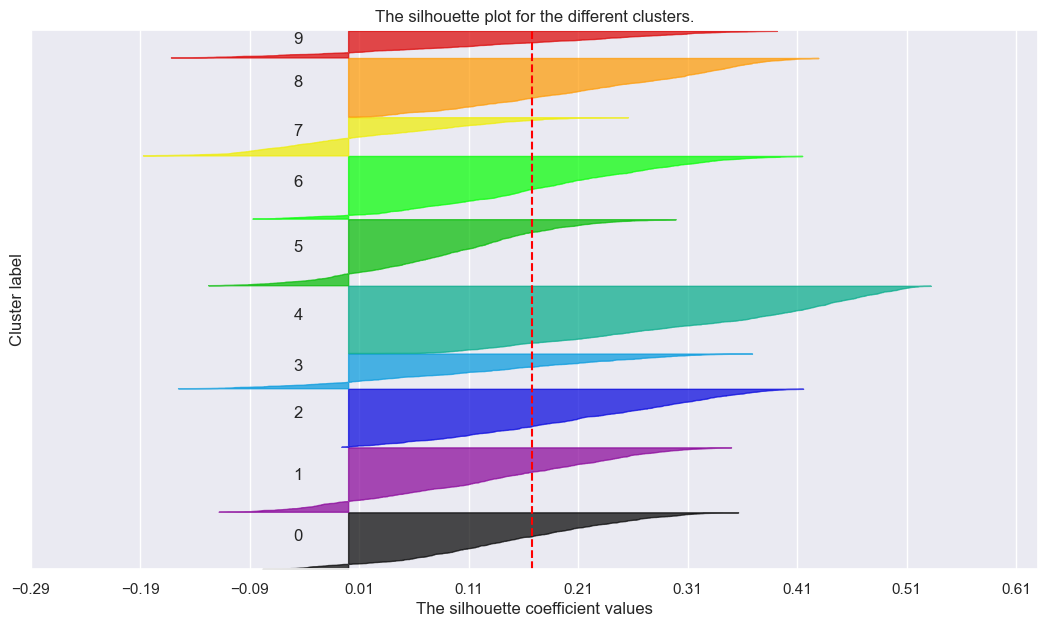

In [61]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py

# Storing average silhouette metric
avg_silhouette = []
for nclus in range_clusters:
    # Skip nclus == 1
    if nclus == 1:
        continue
    
    # Create a figure
    fig = plt.figure(figsize=(13, 7))

    # Initialize the KMeans object with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df[metric_features])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(df[metric_features], cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[metric_features], cluster_labels)

    y_lower = 10
    for i in range(nclus):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        # Get y_upper to demarcate silhouette y range size
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        # Filling the silhouette
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the different clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    # The silhouette coefficient can range from -1, 1
    xmin, xmax = np.round(sample_silhouette_values.min() -0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    # The (nclus+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    plt.ylim([0, len(df[metric_features]) + (nclus + 1) * 10])

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks(np.arange(xmin, xmax, 0.1))

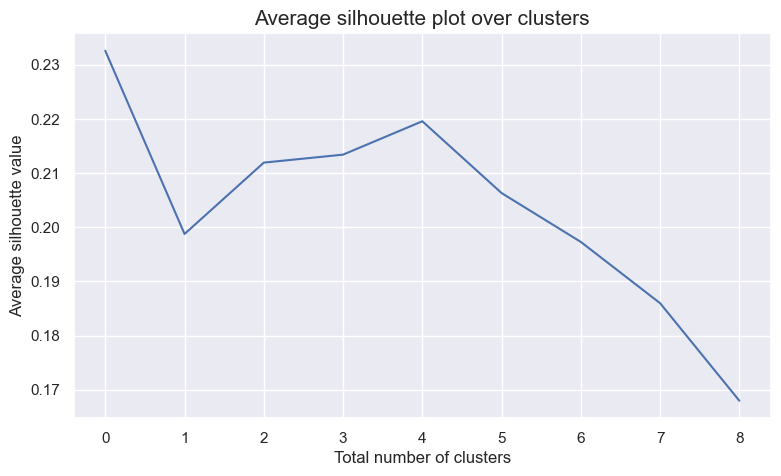

In [62]:
# Draw the average silhouette plot.

plt.figure(figsize=(9,5))
plt.plot(avg_silhouette)
plt.ylabel("Average silhouette value")
plt.xlabel("Total number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.show()

- **Observations from Inertia:**
    - By analyzing Inertia graphing, under "Elbow Method", we get to the conclusion that the ideal number of clusters is 6, as long as it presents the lower SSW.
    
    
- **Observations from Silhouette:**    
    - Silhouette tends to start with the highest value, with 1 cluster;
    - Then, it decreases until at 2 clusters and increases again from 2 to 4 clusters, meaning that on average, our observations are better representated with this number of clusters, than the other.
    
    
- **Inertia vs Silhouette:**
    - Our goal is to achieve a small inertia value and a high silhouete value.
    - After discussing, we opted to follow Inertia conclusions, along as we did in K-Means, adopting 6 clusters as our final solution.

- **6.2) Final Clustering Solution**

In [63]:
# Our final solution.

batchKmeans = MiniBatchKMeans(n_clusters=6, init='k-means++', max_iter=100, batch_size=1024, compute_labels=True, random_state=None, tol=0.0, init_size=None, n_init=3)
df_bkm_labels = batchKmeans.fit_predict(df[metric_features])
df_bkm_labels
df_bkm_n_clusters = len(np.unique(df_bkm_labels))
print("Number of estimated batch kmeans clusters : %d" % df_bkm_n_clusters)

Number of estimated batch kmeans clusters : 6


- **6.3) Key Conclusions**

In [64]:
# Characterize the final clusters (after Scalling).

df_bkm = pd.concat((df, pd.Series(df_bkm_labels,index= df.index, name='bkmlabels')), axis=1)
df_bkm_mean = df_bkm.groupby('bkmlabels').mean()
df_bkm_meanT = df_bkm_mean.T
df_bkm_meanT

bkmlabels                     0         1         2         3         4  \
MonthSal              -1.372841  0.046102 -0.979877  0.001406  1.075395   
CustMonVal             0.303107  0.910136 -0.132138 -0.924873 -0.442117   
ClaimsRate             0.073761 -1.249581  0.157984  0.964442  0.426335   
PremMotor             -1.547404  0.890559 -0.614774  0.958595 -0.437335   
PremHousehold          1.631353 -0.547901  0.148660 -0.605283 -0.049380   
PremHealth            -0.092709 -0.686323  0.876809 -0.759085  0.725343   
PremLife               1.766733 -0.558380  0.134769 -0.582586  0.091138   
PremWork               1.817526 -0.556595  0.132558 -0.574595  0.078266   
Age                   -1.457910  0.056298 -1.017659  0.014540  1.111848   
PolicyAge              0.073635  0.032387 -0.041200  0.029148  0.006110   
x0_b'1 - Basic'        0.434932  0.043399  0.102328  0.041199  0.081297   
x0_b'2 - High School'  0.440639  0.237095  0.408230  0.261236  0.373120   
x0_b'3 - BSc/MSc'      0.122146  0.602558  0.448295  0.584738  0.495301   
x0_b'4 - PhD'          0.002283  0.116948  0.041148  0.112828  0.050282   
x1_0.0                 0.248858  0.150297  0.088793  0.117978  0.701128   
x1_1.0                 0.751142  0.849703  0.911207  0.882022  0.298872   
x2_1.0                 0.296804  0.297853  0.314023  0.294007  0.280075   
x2_2.0                 0.086758  0.096848  0.099080  0.106742  0.106673   
x2_3.0                 0.207763  0.210142  0.198701  0.203184  0.191729   
x2_4.0                 0.408676  0.395158  0.388197  0.396067  0.421523   

bkmlabels                     5  
MonthSal               0.803213  
CustMonVal             1.169176  
ClaimsRate            -0.762134  
PremMotor             -0.745246  
PremHousehold          1.157615  
PremHealth             0.054385  
PremLife               0.616812  
PremWork               0.572775  
Age                    0.824405  
PolicyAge             -0.174309  
x0_b'1 - Basic'        0.191710  
x0_b'2 - High School'  0.516839  
x0_b'3 - BSc/MSc'      0.275907  
x0_b'4 - PhD'          0.015544  
x1_0.0                 0.567358  
x1_1.0                 0.432642  
x2_1.0                 0.292746  
x2_2.0                 0.108808  
x2_3.0                 0.185233  
x2_4.0                 0.413212

In [121]:
# Characterize the final clusters (before Scalling).

df_before_scaling_bkmeans = pd.concat((df_before_scaling, pd.Series(df_bkm_labels, index=df_before_scaling.index, name='bkm_labels')), axis=1)
df_before_scaling_bkmeans_mean = df_before_scaling_bkmeans.groupby('bkm_labels').mean()
df_before_scaling_bkmeans_mean.T

bkm_labels                       0            1            2            3  \
MonthSal               1203.291446  2575.180084  1583.223758  2531.965558   
CustMonVal              288.235639   436.124312   182.198289   -10.933333   
ClaimsRate                0.702203     0.284760     0.728771     0.983165   
PremMotor                97.172545   423.134098   221.867391   432.230669   
PremHousehold           537.549201    78.739676   225.390336    66.658778   
PremHealth              161.989464   118.430051   233.132614   113.090773   
PremLife                111.626210    15.796619    44.364745    14.798946   
PremWork                112.204917    15.465403    43.546671    14.731941   
Age                      23.712675    49.487339    31.206583    48.776535   
PolicyAge                30.453811    30.181373    29.695339    30.159981   
x0_b'1 - Basic'           0.434932     0.043399     0.102328     0.041199   
x0_b'2 - High School'     0.440639     0.237095     0.408230     0.261236   
x0_b'3 - BSc/MSc'         0.122146     0.602558     0.448295     0.584738   
x0_b'4 - PhD'             0.002283     0.116948     0.041148     0.112828   
x1_0.0                    0.248858     0.150297     0.088793     0.117978   
x1_1.0                    0.751142     0.849703     0.911207     0.882022   
x2_1.0                    0.296804     0.297853     0.314023     0.294007   
x2_2.0                    0.086758     0.096848     0.099080     0.106742   
x2_3.0                    0.207763     0.210142     0.198701     0.203184   
x2_4.0                    0.408676     0.395158     0.388197     0.396067   

bkm_labels                       4            5  
MonthSal               3570.339238  3307.184015  
CustMonVal              106.679102   499.233342  
ClaimsRate                0.813421     0.438523  
PremMotor               245.591467   204.422979  
PremHousehold           183.695771   437.810816  
PremHealth              222.018044   172.783198  
PremLife                 42.566521    64.232204  
PremWork                 41.334406    61.484417  
Age                      67.454783    62.561966  
PolicyAge                30.007814    28.816160  
x0_b'1 - Basic'           0.081297     0.191710  
x0_b'2 - High School'     0.373120     0.516839  
x0_b'3 - BSc/MSc'         0.495301     0.275907  
x0_b'4 - PhD'             0.050282     0.015544  
x1_0.0                    0.701128     0.567358  
x1_1.0                    0.298872     0.432642  
x2_1.0                    0.280075     0.292746  
x2_2.0                    0.106673     0.108808  
x2_3.0                    0.191729     0.185233  
x2_4.0                    0.421523     0.413212

- **Cluster 0**: 
    - The mean of ages is equal to 23.
    - The highest value of customer monetary value.
    - The lowest Monthly Salary.
    - Regarding premiums, it has the highest premium for household and life.
    - This cluster represents, on average, individuals with low education levels.
    
- **Cluster 1**: 
    - The mean of ages is equal to 49.
    - The second highest customer monetary value.
    - The lowest claims rate.
    - Regarding premiums, it has the second lowest premium for household and life.
    - This cluster represents, on average, the individuals with the higher education levels.
    - Around 84% of the individuals have children. 
    
- **Cluster 2**: 
    - The mean of ages is equal to 31.
    - The second lowest monthly salary.
    - Regarding premiums, it has the highest Premium Household.
    - This cluster represents, on average, individuals with low education levels.
    - Around 91% of the individuals have children. 

- **Cluster 3**: 
    - The mean of ages is equal to 48.
    - The lowest customer Monetary Value.
    - The highest claims rate.
    
- **Cluster 4**: 
    - The mean of ages is equal to 67, which means the older people.
    - This cluster represents, on average, the individuals with the higher education levels.
    - Around 70% of the individuals does not have children. 
    
- **Cluster 5**: 
    - The mean of ages is equal to 62.
    - The highest customer monetary value.

- **6.4) Assessing using R2**

In [66]:
# First, we are assessing our clustering solution by using R²:

df_bkm_r2 =  get_r2(df_bkm, "bkmlabels")
print("Batch K-Means Cluster solution with R^2 of %0.4f" % df_bkm_r2)

# Second, we are essentially decomposing the R² into the R² per variable:

get_r2_feature(df_bkm[metric_features + ['bkmlabels']], 'bkmlabels').drop('bkmlabels').sort_values(axis=0, ascending=False)

Batch K-Means Cluster solution with R^2 of 0.5335


PremMotor        0.736857
Age              0.697373
MonthSal         0.642148
ClaimsRate       0.632377
CustMonVal       0.525166
PremHousehold    0.487690
PremHealth       0.483640
PremWork         0.459983
PremLife         0.451016
PolicyAge        0.003572
dtype: float64

- **From the table above, we can conclude that:**: 
    - The final R2 value for our final cluster solution is 0.533.
    - The three variables that mostly contribute to the this R2 value are: PremMotor, Age and MonthlySal.

- **6.5) Cluster Visualization using Tsne**

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


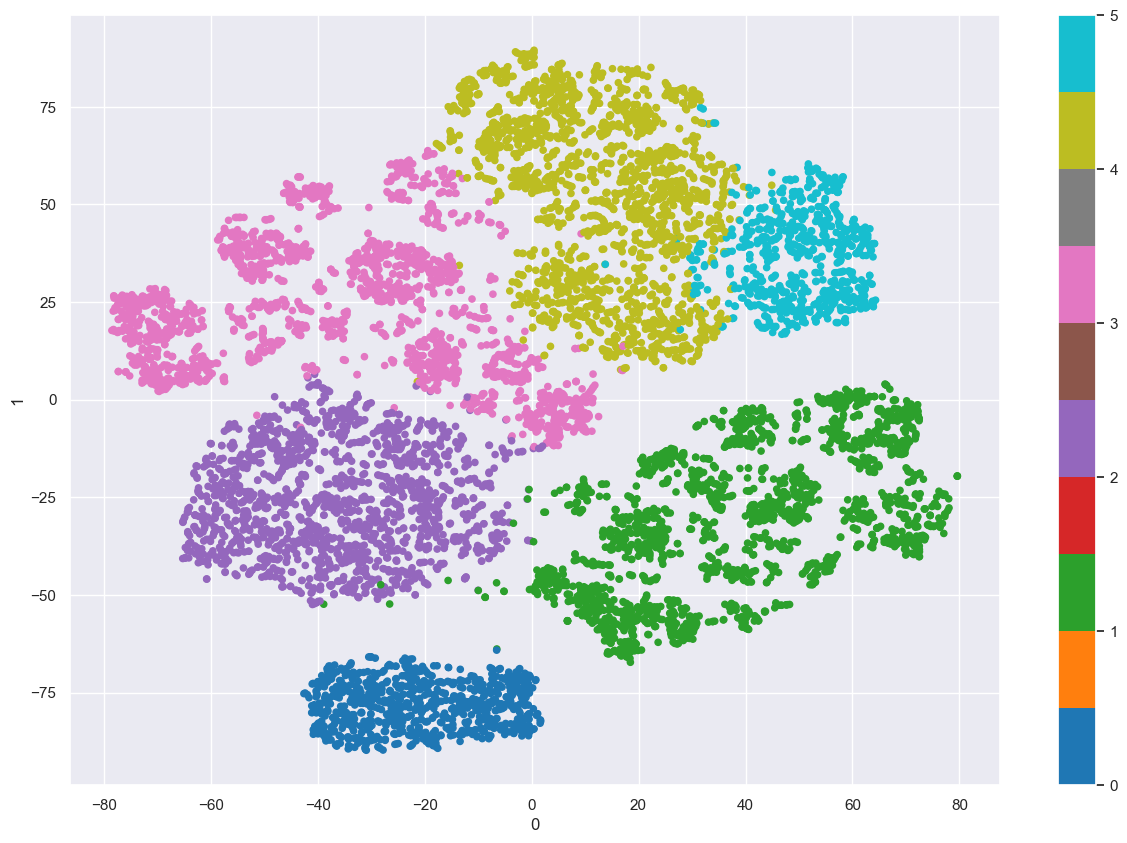

In [67]:
df_bkm_tsne = TSNE(random_state=42).fit_transform(df_bkm)
pd.DataFrame(df_bkm_tsne).plot.scatter(x=0, y=1, c=df_bkm['bkmlabels'], colormap='tab10', figsize=(15,10))
plt.show()

# **7. Hierarquical Clustering**

- **7.1) Defining the linkage method to choose**
- **7.2) Defining the number of clusters**
- **7.3) Final Clustering Solution**
- **7.4) Key Conclusions**
- **7.5) Assessing using R2**
- **7.6) Cluster Visualization using Tsne**

- **7.1) Defining the linkage method to choose**

In [68]:
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, dist="euclidean"):
    """This function computes the R2 for a set of cluster solutions given by the application of a hierarchical method.
    The R2 is a measure of the homogenity of a cluster solution. It is based on SSt = SSw + SSb and R2 = SSb/SSt. 
    
    Parameters:
    df (DataFrame): Dataset to apply clustering
    link_method (str): either "ward", "complete", "average", "single"
    max_nclus (int): maximum number of clusters to compare the methods
    min_nclus (int): minimum number of clusters to compare the methods. Defaults to 1.
    dist (str): distance to use to compute the clustering solution. Must be a valid distance. Defaults to "euclidean".
    
    Returns:
    ndarray: R2 values for the range of cluster solutions
    """
    def get_ss(df):
        # Since its a sample, we loose one degree of freedom.
        ss = np.sum(df.var() * (df.count() - 1))
        return ss  # Return sum of sum of squares of each df variable
    
    sst = get_ss(df)  # Get total sum of squares
    r2 = []  # Where we will store the R2 metrics for each cluster solution
    
    for i in range(min_nclus, max_nclus+1):  # Iterate over desired ncluster range
        cluster = AgglomerativeClustering(n_clusters=i, affinity=dist, linkage=link_method)
        hclabels = cluster.fit_predict(df) # Get cluster labels
        df_concat = pd.concat((df, pd.Series(hclabels, name='labels')), axis=1)  # concat df with labels
        ssw_labels = df_concat.groupby(by='labels').apply(get_ss)  # compute ssw for each cluster labels        
        ssb = sst - np.sum(ssw_labels)  # Remember: SST = SSW + SSB   
        r2.append(ssb / sst)  # Save the R2 of the given cluster solution
        
    return np.array(r2)

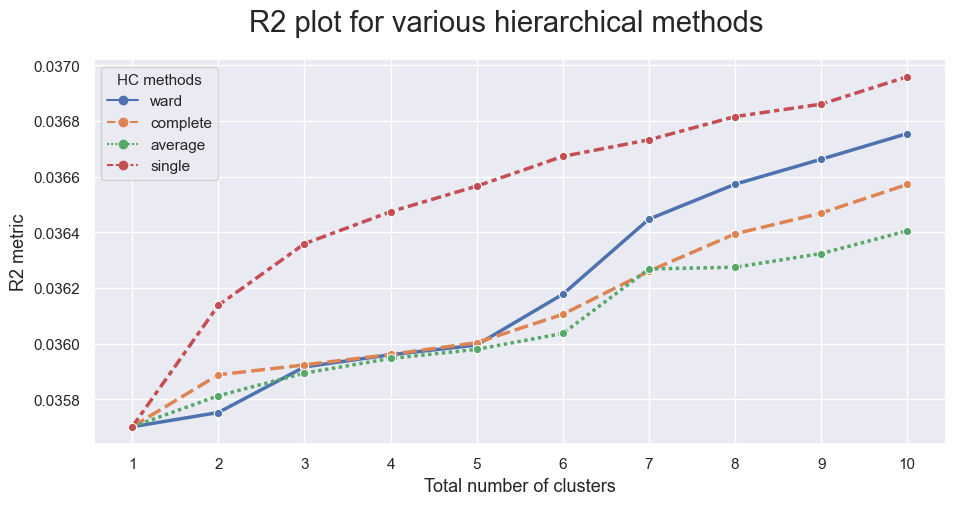

In [69]:
# Understand the preferable linkage method to adopt.

hc_methods = ["ward", "complete", "average", "single"]
# Call function defined above to obtain the R2 statistic for each hc_method
max_nclus = 10
r2_hc_methods = np.vstack(
    [
        get_r2_hc(df=df[metric_features], link_method=link, max_nclus=max_nclus) 
        for link in hc_methods
    ]
).T
r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

sns.set()
# Plot data
fig = plt.figure(figsize=(11,5))
sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)

# Finalize the plot
fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
plt.legend(title="HC methods", title_fontsize=11)
plt.xticks(range(1, max_nclus + 1))
plt.xlabel("Total number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)

plt.show()

- **Key Takeaway**: 
    - Ward performs best.
    - Complete performs worse.
    - The difference between clusters is not significant.

In [70]:
# Set 'distance_threshold=0' and 'n_clusters=None' ensuring we compute the full tree.

linkage = 'ward'
distance = 'euclidean'
hclust = AgglomerativeClustering(linkage=linkage, affinity=distance, distance_threshold=0, n_clusters=None)
hclust.fit_predict(df[metric_features])

array([7727, 9313, 5661, ...,    2,    1,    0], dtype=int64)

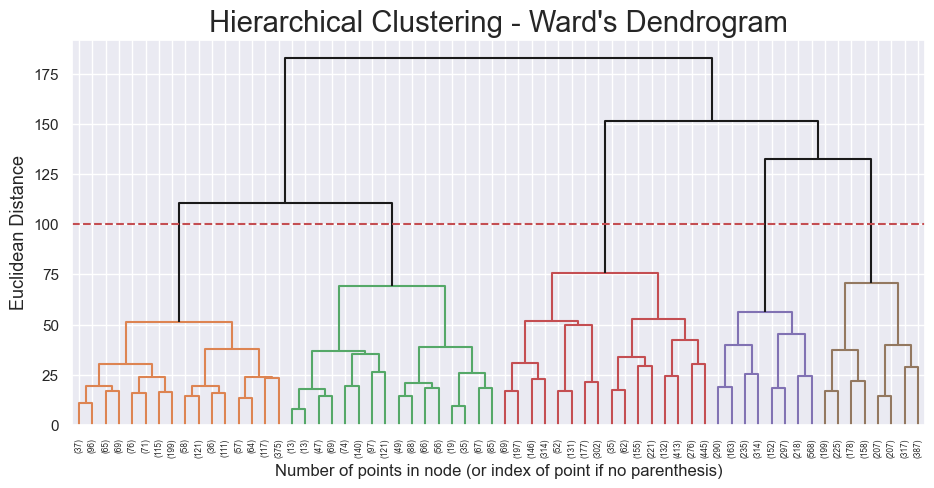

In [71]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

# create the counts of samples under each node (number of points being merged)
counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

# hclust.children_ contains the observation ids that are being merged together
# At the i-th iteration, children[i][0] and children[i][1] are merged to form node n_samples + i
for i, merge in enumerate(hclust.children_):
    # track the number of observations in the current cluster being formed
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            # If this is True, then we are merging an observation
            current_count += 1  # leaf node
        else:
            # Otherwise, we are merging a previously formed cluster
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

# the hclust.children_ is used to indicate the two points/clusters being merged (dendrogram's u-joins)
# the hclust.distances_ indicates the distance between the two points/clusters (height of the u-joins)
# the counts indicate the number of points being merged (dendrogram's x-axis)
linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

# Plot the corresponding dendrogram
sns.set()
fig = plt.figure(figsize=(11,5))
# The Dendrogram parameters need to be tuned
y_threshold = 100
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering - {linkage.title()}\'s Dendrogram', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

- **7.2) Defining the number of clusters**

In [72]:
# Our final solution.

linkage = 'ward'
distance = 'euclidean'
hc4lust = AgglomerativeClustering(linkage=linkage, affinity=distance, n_clusters=4)
df_hc_labels = hc4lust.fit_predict(df[metric_features])
df_hc_n_clusters = len(np.unique(df_hc_labels))
print("Number of estimated hierarquical clustering clusters : %d" % df_hc_n_clusters)

Number of estimated hierarquical clustering clusters : 4


- **7.3) Final Clustering Solution**

In [73]:
# Characterize the final clusters (after scalling).

df_hc = pd.concat((df, pd.Series(df_hc_labels,index =df.index,  name='df_hc_labels')), axis=1)
df_hc.groupby('df_hc_labels').mean()

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
df_hc_labels                                                               
0            -1.061337   -0.027949    0.160135  -0.843395       0.590628   
1            -0.216545    0.928875   -1.254459   0.828560      -0.504363   
2             0.927136    0.120813   -0.065157  -0.421101       0.216087   
3             0.169646   -0.914878    0.950512   0.913266      -0.593092   

              PremHealth  PremLife  PremWork       Age  PolicyAge  \
df_hc_labels                                                        
0               0.508201  0.595927  0.633963 -1.113057  -0.170054   
1              -0.643355 -0.511288 -0.522636 -0.216894   0.144420   
2               0.434874  0.217350  0.174114  0.966292   0.043647   
3              -0.682530 -0.595454 -0.571501  0.177766   0.023452   

              x0_b'1 - Basic'  x0_b'2 - High School'  x0_b'3 - BSc/MSc'  \
df_hc_labels                                                              
0                    0.206578               0.407982           0.358093   
1                    0.046326               0.253994           0.582535   
2                    0.109690               0.401983           0.441318   
3                    0.037997               0.255700           0.593205   

              x0_b'4 - PhD'    x1_0.0    x1_1.0    x2_1.0    x2_2.0    x2_3.0  \
df_hc_labels                                                                    
0                  0.027347  0.143755  0.856245  0.305987  0.096083  0.200296   
1                  0.117146  0.097977  0.902023  0.306177  0.095314  0.207668   
2                  0.047010  0.613367  0.386633  0.287496  0.103294  0.193476   
3                  0.113098  0.179705  0.820295  0.286097  0.110863  0.204291   

                x2_4.0  
df_hc_labels            
0             0.397635  
1             0.390841  
2             0.415734  
3             0.398748

- **7.4) Key Conclusions**

In [74]:
# Characterize the final clusters (before scalling).

df_before_scaling_hc = pd.concat((df_before_scaling, pd.Series(df_hc_labels, index=df_before_scaling.index, name='df_hc_labels')), axis=1)
df_before_scaling_hc_mean = df_before_scaling_hc.groupby('df_hc_labels').mean()
df_before_scaling_hc_mean.T

df_hc_labels                     0            1            2            3
MonthSal               1504.464666  2321.242385  3426.996888  2694.626431
CustMonVal              207.581663   440.689766   243.824065    -8.498328
ClaimsRate                0.729449     0.283222     0.658382     0.978771
PremMotor               191.300238   414.844675   247.761963   426.169981
PremHousehold           318.440004    87.905831   239.585929    69.225257
PremHealth              206.084185   121.583022   200.703447   118.708363
PremLife                 63.371407    17.737482    47.768326    14.268590
PremWork                 63.977678    16.849123    45.239965    14.858009
Age                      29.582728    44.837110    64.977150    51.554957
PolicyAge                28.844266    30.921338    30.255741    30.122360
x0_b'1 - Basic'           0.206578     0.046326     0.109690     0.037997
x0_b'2 - High School'     0.407982     0.253994     0.401983     0.255700
x0_b'3 - BSc/MSc'         0.358093     0.582535     0.441318     0.593205
x0_b'4 - PhD'             0.027347     0.117146     0.047010     0.113098
x1_0.0                    0.143755     0.097977     0.613367     0.179705
x1_1.0                    0.856245     0.902023     0.386633     0.820295
x2_1.0                    0.305987     0.306177     0.287496     0.286097
x2_2.0                    0.096083     0.095314     0.103294     0.110863
x2_3.0                    0.200296     0.207668     0.193476     0.204291
x2_4.0                    0.397635     0.390841     0.415734     0.398748

- **7.5) Assessing using R2**
- 7.5.1 Clusters = 4

In [75]:
# First, we are assessing our clustering solution by using R²:

df_hc_r2 =  get_r2(df_hc, "df_hc_labels")
print("Hierarchical Clustering solution with R^2 of %0.4f" % df_hc_r2)

# Second, we are essentially decomposing the R² into the R² per variable:

get_r2_feature(df_hc[metric_features + ['df_hc_labels']], 'df_hc_labels').drop('df_hc_labels')

Hierarchical Clustering solution with R^2 of 0.3908


MonthSal         0.591927
CustMonVal       0.355899
ClaimsRate       0.508553
PremMotor        0.566382
PremHousehold    0.236690
PremHealth       0.312591
PremLife         0.240531
PremWork         0.243865
Age              0.646485
PolicyAge        0.012526
dtype: float64

- **From the table above, we can conclude that:**: 
    - The final R2 value for our final cluster solution is 0.3908.
    - The three variables that mostly contribute to the this R2 value are: MonthSal, CustMonVal and ClaimsRate.

- **7.6) Cluster Visualization using Tsne**

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


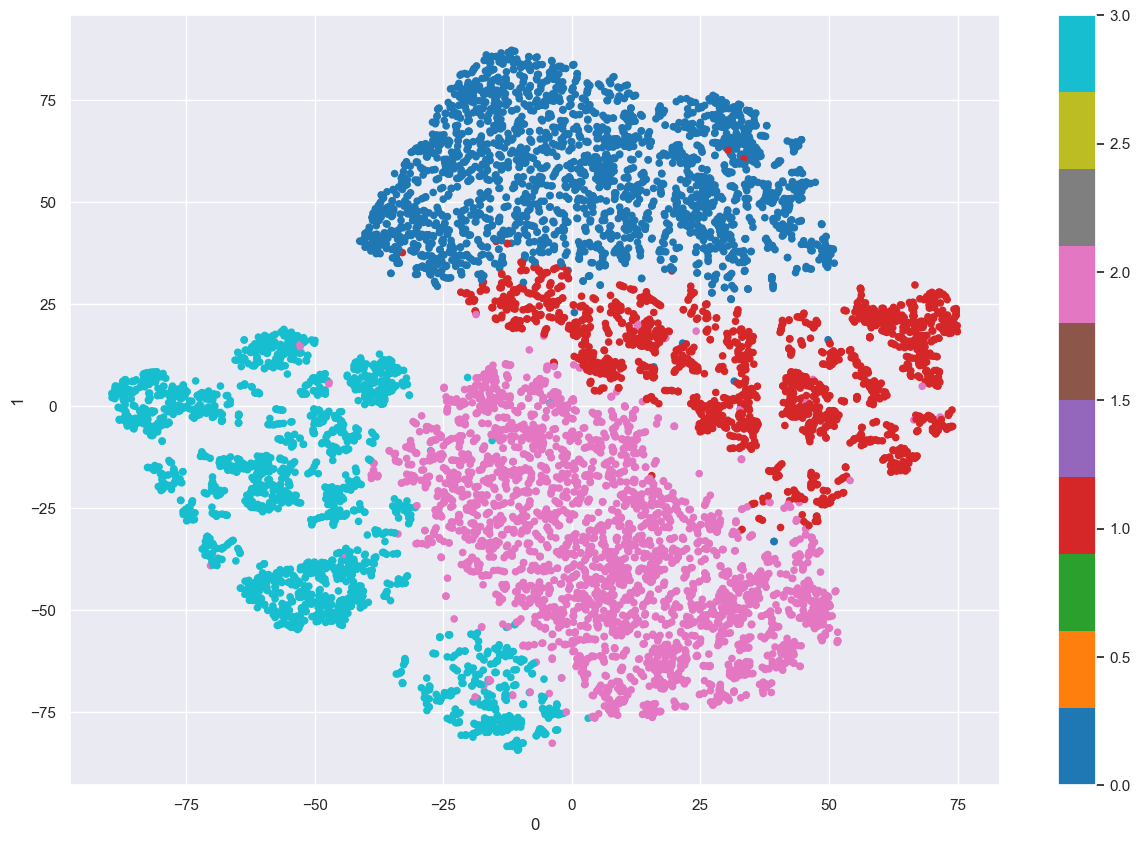

In [76]:
df_hc_tsne = TSNE(random_state=42).fit_transform(df_hc)
pd.DataFrame(df_hc_tsne).plot.scatter(x=0, y=1, c=df_hc['df_hc_labels'], colormap='tab10', figsize=(15,10))
plt.show()

# **8. Clustering using different perspectives**

- **8.1) Perspectives Division**
- **8.2) Testing on K-means and Hierarchical clustering**
- 8.2.1) Finding the optimal clusterer on value_demographic variables
- 8.2.1.1) Key Takeaways on Demographic Variables
- 8.2.2) Finding the optimal clusterer on Premium variables
- 8.2.2.1) Key Takeaways on Premium Variables
- **8.3) Merging both Perspectives**
- 8.3.1) Manual Merging
- 8.3.2) Merging using Hierarchical Clustering
- **8.4) Key Conclusions**
- **8.5) Cluster Analysis**
- **8.6) Assessing Perspetive**
- 8.6.1) Assessing using R2
- 8.6.2) Assessing using Decision Tree
- **8.7) Cluster Visualization using Tsne**

- **8.1) Perspectives Division**

In [77]:
# Split variables into perspectives (requires critical thinking, discussion within the team members and some research).
Value_demographic_features = [
    'Age',
    'ClaimsRate',
    'CustMonVal',
    'MonthSal',
    'PolicyAge', 
]

Prem_features = [
    'PremHealth',
    'PremHousehold',
    'PremLife',
    'PremMotor',
    'PremWork', 
]

df_perspective = df.copy()
df_value_dem = df_perspective[Value_demographic_features].copy()
df_premium = df_perspective[Prem_features].copy()

- **8.2) Testing on K-means and Hierarchical clustering**

In [78]:
def r2(df, labels):
    sst = get_ss(df)
    ssw = np.sum(df.groupby(labels).apply(get_ss))
    return 1 - ssw/sst
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    """
    Loop over different values of k. To be used with sklearn clusterers.
    """
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = r2(df, labels)
    return r2_clust


# Set up the clusterers.
kmeans = KMeans(init='k-means++', n_init=20, random_state=42) 
hierarchical = AgglomerativeClustering(affinity='euclidean')

- 8.2.1) Finding the optimal clusterer on value_demographic variables

In [79]:
# Obtain the R² scores for each cluster solution on 'value_demographic' variables.

r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_value_dem, kmeans)

for link in ['average', 'complete', 'single', 'ward']:
    r2_scores[link] = get_r2_scores(df_value_dem, hierarchical.set_params(linkage=link))

pd.DataFrame(r2_scores)

kmeans   average  complete    single      ward
2  0.299134  0.000627  0.274599  0.000627  0.261696
3  0.493974  0.281640  0.394440  0.001874  0.436303
4  0.583960  0.282763  0.407338  0.001919  0.533376
5  0.633331  0.426756  0.543036  0.002143  0.581062
6  0.673445  0.429254  0.584083  0.002175  0.619688
7  0.707648  0.448004  0.621374  0.002233  0.648860
8  0.733913  0.563664  0.633753  0.002244  0.676719
9  0.752550  0.563901  0.651873  0.002510  0.696445

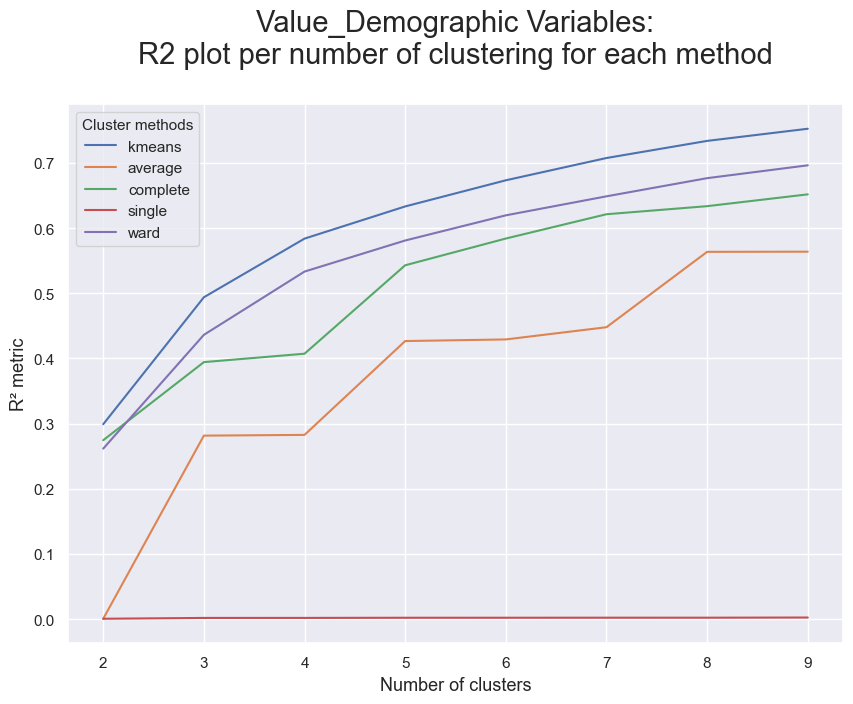

In [80]:
# Visualize the R² scores for each cluster solution on 'value_demographic' variables.

pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Value_Demographic Variables:\nR2 plot per number of clustering for each method\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show();

- **8.2.1.1) Key Takeaways on Demographic Variables**
- 'Kmeans' clustering performs better.
- 'Ward' clustering performs the 2nd best.
- 'Single' clustering performs the worse.

- The best solution is somewhere between 3 and 4 clusters. We defined the number of clusters as 3.

- 8.2.2) Finding the optimal clusterer on premium variables

In [81]:
# Obtaine the R² scores for each cluster solution on premium variables.

r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_premium, kmeans)

for link in ['average', 'complete', 'single', 'ward']:
    r2_scores[link] = get_r2_scores(
        df_premium, hierarchical.set_params(linkage=link)
    )

pd.DataFrame(r2_scores)

kmeans   average  complete    single      ward
2  0.396723  0.157935  0.160634  0.000429  0.363482
3  0.550371  0.174862  0.228603  0.000942  0.514910
4  0.605471  0.183742  0.495545  0.001458  0.557866
5  0.651433  0.406435  0.511279  0.002024  0.595659
6  0.683840  0.439775  0.551863  0.002473  0.629494
7  0.709942  0.462263  0.568970  0.002955  0.660474
8  0.730113  0.468785  0.576681  0.003793  0.679103
9  0.746343  0.474867  0.615263  0.004491  0.696401

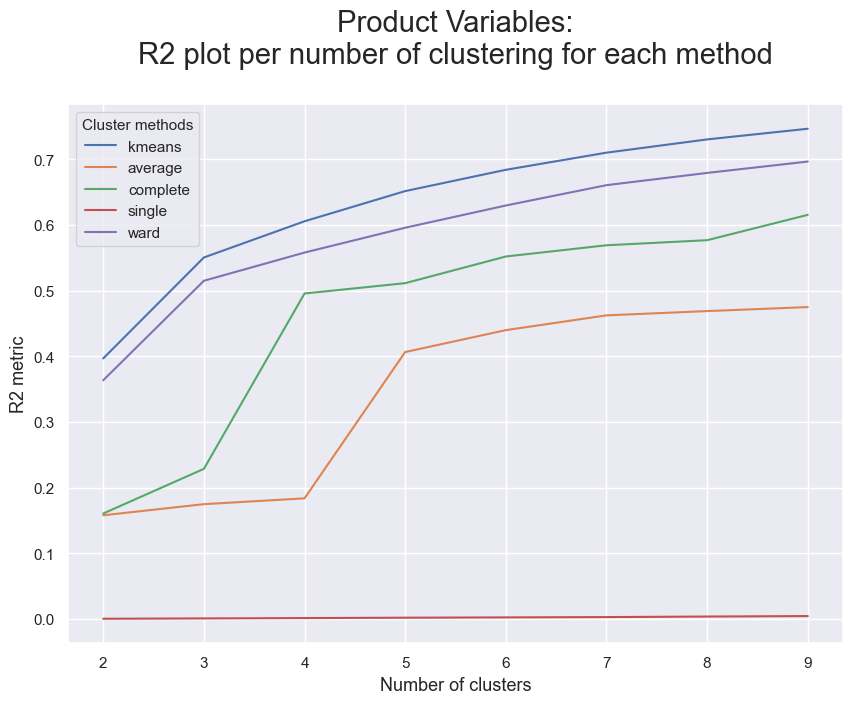

In [82]:
# Visualize the R² scores for each cluster solution on product variables.

pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("Product Variables:\nR2 plot per number of clustering for each method\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R2 metric", fontsize=13)
plt.show()

- **8.2.2) Key Takeaways on Product Variables**
- 'Kmeans' clustering performs better.
- 'Ward' clustering performs the 2nd best.
- 'Single' clustering performs the worse.
- The best solution is somewhere between 3 and 4 clusters. We defined the number of clusters as 3.

- **8.3) Merging both Perspectives**
- 8.3.1) Manual Merging

In [83]:
# Apply the right clustering (algorithm and number of clusters) for each perspective.

kmeans_num_dem = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)
value_dem_labels = kmeans_num_dem.fit_predict(df_value_dem)

kmeans_premium = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)
premium_labels = kmeans_premium.fit_predict(df_premium)


# Storing in a different Dataframe.
df_value_dem['value_dem_labels'] = value_dem_labels
df_premium['premium_labels'] = premium_labels

df_perspective["value_dem_labels"] = value_dem_labels
df_perspective["premium_labels"] = premium_labels

In [84]:
# Count label frequencies (contigency table).

df_perspective.groupby(['premium_labels', 'value_dem_labels'])\
    .size().to_frame().reset_index().pivot('value_dem_labels', 'premium_labels', 0)

premium_labels       0    1     2
value_dem_labels                 
0                 1174  441  1845
1                 1153  770  1308
2                 1756  629   872

- **Take Aways**:
    - The cluster labels with more costumers its the label 1 for 'premium' and the label 2 for 'value_demographic'.

- **8.3) Merging both Perspectives**
- 8.3.2) Merging using Hierarchical Clustering

In [85]:
# Centroids of the concatenated cluster labels.

df_perspective_centroids = df_perspective.groupby(['value_dem_labels', 'premium_labels'])[metric_features].mean()
df_perspective_centroids

MonthSal  CustMonVal  ClaimsRate  PremMotor  \
value_dem_labels premium_labels                                                
0                0               0.804684   -0.615767    0.604320   0.871123   
                 1               0.992096   -0.338306    0.455673  -1.022048   
                 2               1.082304   -0.311407    0.299682  -0.435009   
1                0              -0.422728   -0.909722    0.953090   1.040054   
                 1              -1.288448   -0.614317    0.692690  -1.405707   
                 2              -0.892551   -0.536859    0.543361  -0.471366   
2                0              -0.036304    0.965197   -1.332930   1.029361   
                 1              -0.634588    1.882334   -1.078497  -1.273936   
                 2              -0.308705    0.908167   -0.902908  -0.316374   

                                 PremHousehold  PremHealth  PremLife  \
value_dem_labels premium_labels                                        
0                0                   -0.509296   -0.720846 -0.512458   
                 1                    1.005684    0.057668  1.175752   
                 2                   -0.089544    0.838640 -0.003480   
1                0                   -0.635810   -0.827897 -0.634082   
                 1                    1.269951    0.082358  1.601275   
                 2                   -0.120147    0.920956 -0.007644   
2                0                   -0.588945   -0.867913 -0.597459   
                 1                    1.806951   -0.044486  1.187508   
                 2                    0.148635    0.587302 -0.114853   

                                 PremWork       Age  PolicyAge  
value_dem_labels premium_labels                                 
0                0              -0.521932  0.783992  -0.007537  
                 1               1.076512  1.013460  -0.090515  
                 2              -0.004832  1.135354  -0.027604  
1                0              -0.633942 -0.376296   0.054680  
                 1               1.548279 -1.350444  -0.000694  
                 2               0.021334 -0.933543   0.020322  
2                0              -0.599033 -0.022488   0.000898  
                 1               1.231756 -0.702540  -0.039814  
                 2              -0.074650 -0.327865   0.039070

In [86]:
# Use Hierarchical clustering to merge the concatenated cluster centroids.

hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', distance_threshold=0, n_clusters=None)
hclust_labels = hclust.fit_predict(df_perspective_centroids)
df_merged_n_clusters = len(np.unique(hclust_labels))
print("Number of estimated perspectives clustering clusters : %d" % df_merged_n_clusters)

Number of estimated perspectives clustering clusters : 9


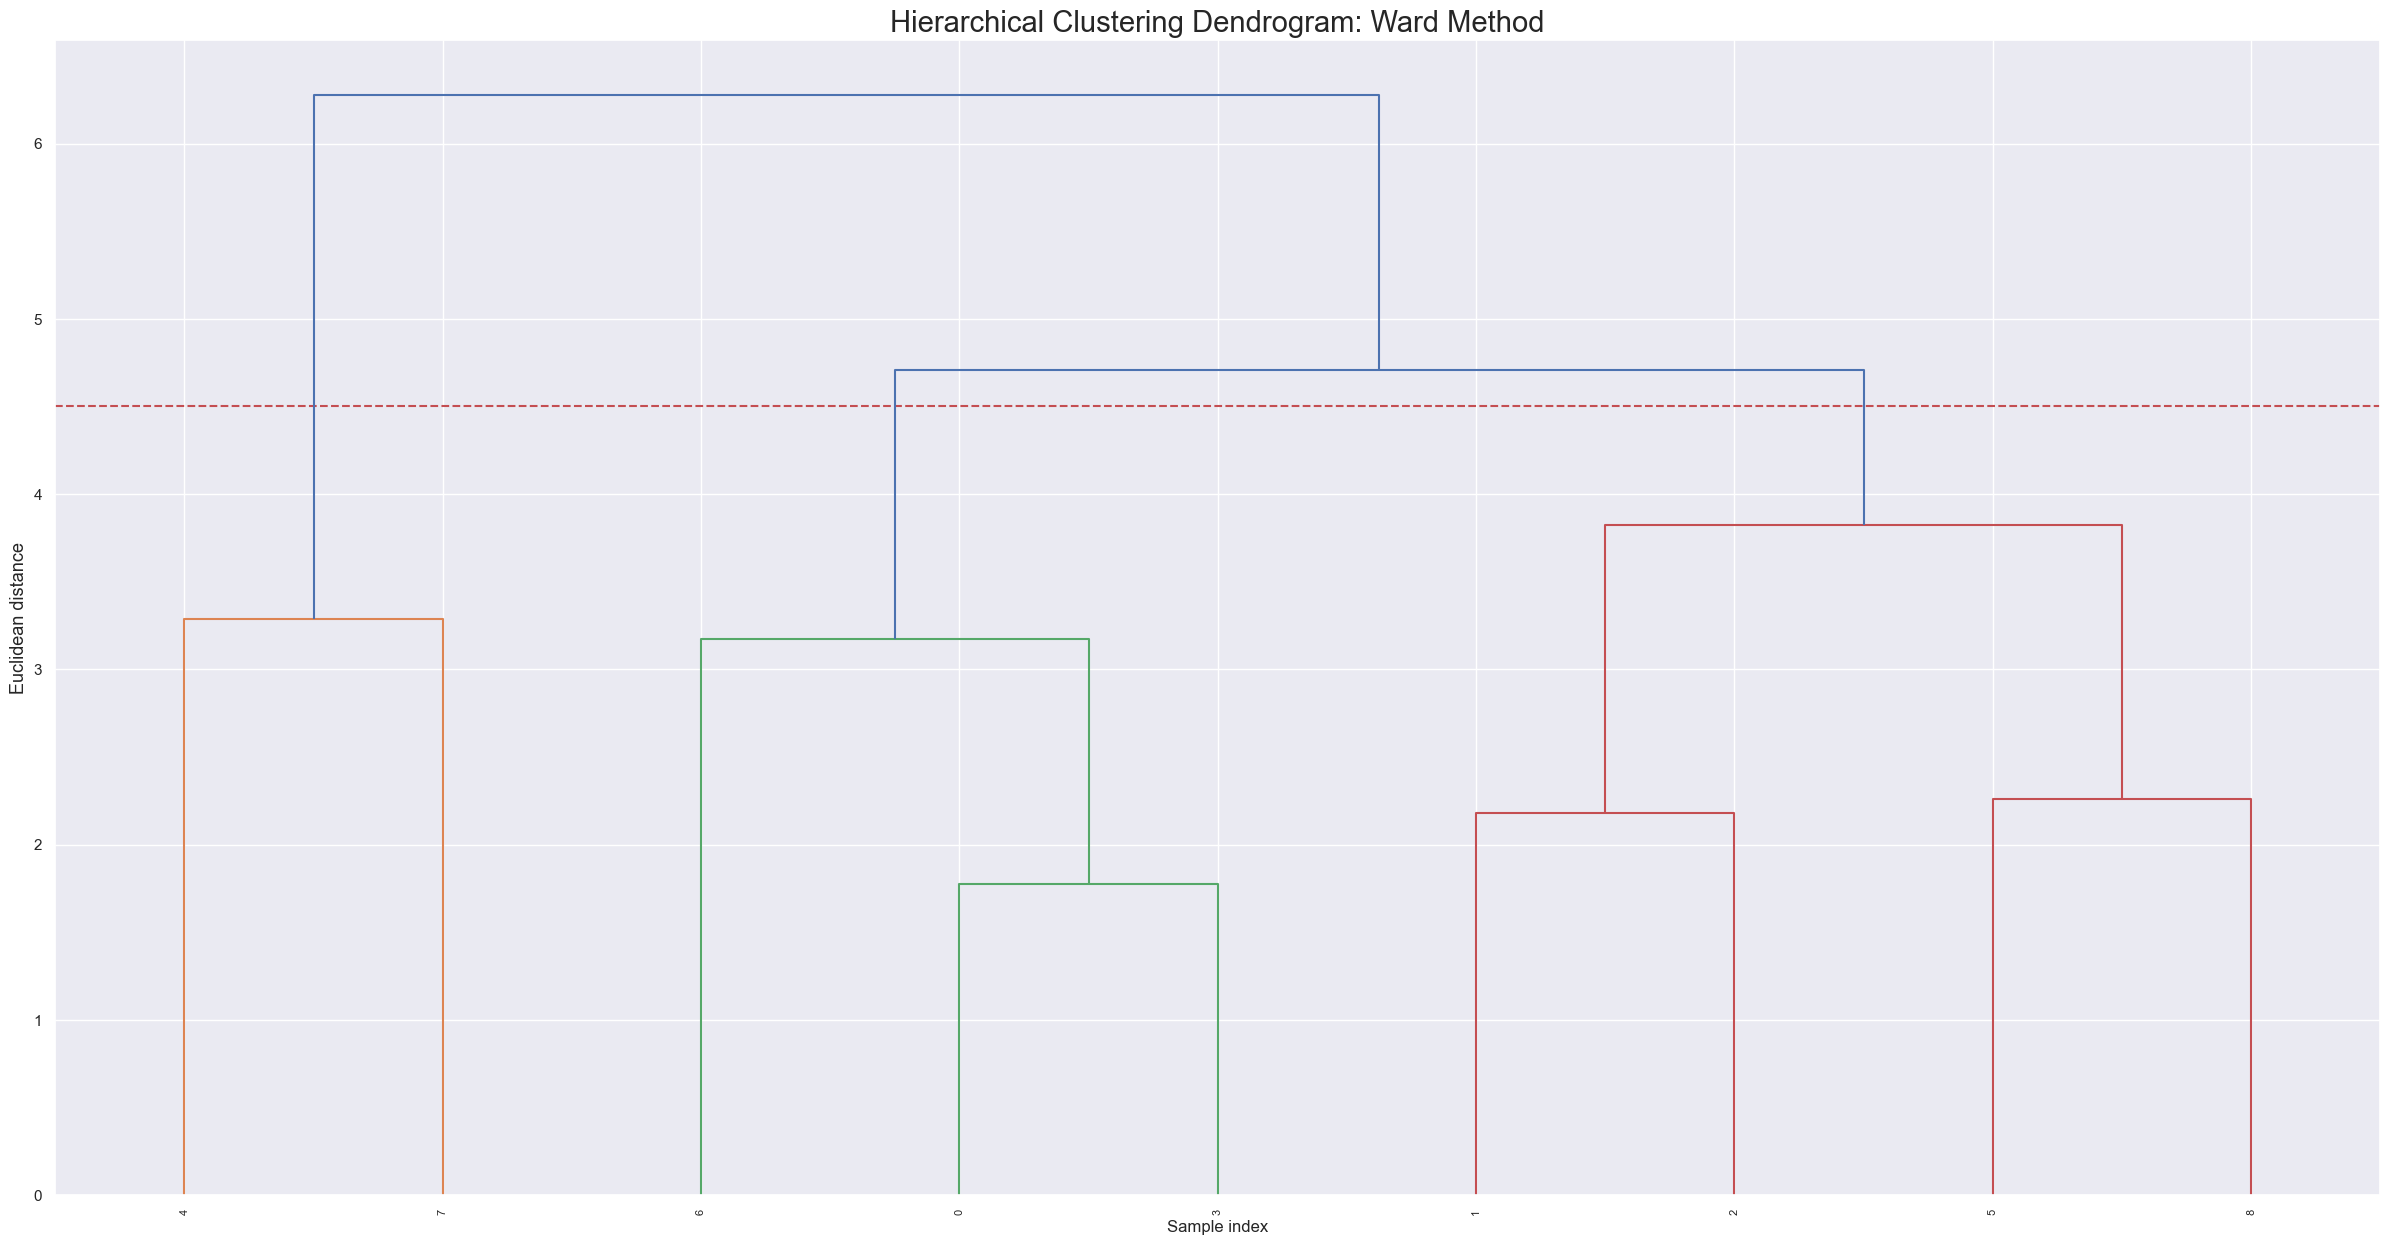

In [87]:
# Adapted from:
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html#sphx-glr-auto-examples-cluster-plot-agglomerative-dendrogram-py

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
linked = linkage(df_perspective_centroids, method="ward", metric="euclidean")

# Calculate full dendrogram
plt.figure(figsize=(30, 15))
plt.hlines(4.5, 0, 1000, colors="r", linestyles="dashed")
plt.title('Hierarchical Clustering Dendrogram: Ward Method', fontsize=21)
plt.xlabel('Sample index')
plt.ylabel('Euclidean distance', fontsize=13)
dendrogram(
    linked,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [88]:
# Re-run the Hierarchical clustering based on the correct number of clusters.

nclust=3

hclust = AgglomerativeClustering(linkage='ward', affinity='euclidean', n_clusters=nclust)

hclust_labels = hclust.fit_predict(df_perspective_centroids)
df_perspective_centroids['hclust_labels'] = hclust_labels

df_perspective_centroids  # centroid's cluster labels

MonthSal  CustMonVal  ClaimsRate  PremMotor  \
value_dem_labels premium_labels                                                
0                0               0.804684   -0.615767    0.604320   0.871123   
                 1               0.992096   -0.338306    0.455673  -1.022048   
                 2               1.082304   -0.311407    0.299682  -0.435009   
1                0              -0.422728   -0.909722    0.953090   1.040054   
                 1              -1.288448   -0.614317    0.692690  -1.405707   
                 2              -0.892551   -0.536859    0.543361  -0.471366   
2                0              -0.036304    0.965197   -1.332930   1.029361   
                 1              -0.634588    1.882334   -1.078497  -1.273936   
                 2              -0.308705    0.908167   -0.902908  -0.316374   

                                 PremHousehold  PremHealth  PremLife  \
value_dem_labels premium_labels                                        
0                0                   -0.509296   -0.720846 -0.512458   
                 1                    1.005684    0.057668  1.175752   
                 2                   -0.089544    0.838640 -0.003480   
1                0                   -0.635810   -0.827897 -0.634082   
                 1                    1.269951    0.082358  1.601275   
                 2                   -0.120147    0.920956 -0.007644   
2                0                   -0.588945   -0.867913 -0.597459   
                 1                    1.806951   -0.044486  1.187508   
                 2                    0.148635    0.587302 -0.114853   

                                 PremWork       Age  PolicyAge  hclust_labels  
value_dem_labels premium_labels                                                
0                0              -0.521932  0.783992  -0.007537              2  
                 1               1.076512  1.013460  -0.090515              0  
                 2              -0.004832  1.135354  -0.027604              0  
1                0              -0.633942 -0.376296   0.054680              2  
                 1               1.548279 -1.350444  -0.000694              1  
                 2               0.021334 -0.933543   0.020322              0  
2                0              -0.599033 -0.022488   0.000898              2  
                 1               1.231756 -0.702540  -0.039814              1  
                 2              -0.074650 -0.327865   0.039070              0

In [89]:
# Once again, making a safety copy of the current dataset.

df_ = df_perspective.copy()

# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_perspective_centroids['hclust_labels'].to_dict()

# Until now, we just applied to the centroids, not to the customers.
# Mapping the hierarchical clusters on the centroids to the observations
df_['merged_labels'] = df_.apply(lambda row: cluster_mapper[(row['value_dem_labels'], row['premium_labels'])], axis=1)


# Merged cluster centroids
df_.groupby('merged_labels').mean()[metric_features]

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  \
merged_labels                                                               
0              0.223403   -0.141968    0.151645  -0.480461       0.056147   
1             -0.994468    0.508194   -0.103648  -1.346462       1.511390   
2              0.096386   -0.018843   -0.130356   0.986882      -0.579277   

               PremHealth  PremLife  PremWork       Age  PolicyAge  
merged_labels                                                       
0                0.736556  0.089999  0.095978  0.231682  -0.006762  
1                0.025328  1.415242  1.405968 -1.059142  -0.018283  
2               -0.814326 -0.583360 -0.586722  0.109490   0.013660

In [90]:
# Merge cluster contigency table.
# Getting size of each final cluster.

df_counts = df_.groupby('merged_labels').size().to_frame()

# Get the product and behavior labels.
df_counts = df_counts.rename({v:k for k, v in cluster_mapper.items()}).reset_index()

df_counts['value_dem_labels'] = df_counts['merged_labels'].apply(lambda x: x[0])
df_counts['premium_labels'] = df_counts['merged_labels'].apply(lambda x: x[1])
df_counts.pivot('value_dem_labels', 'premium_labels', 0)

premium_labels       0     1     2
value_dem_labels                  
2                 4083  1399  4466

In [91]:
# Set 'df' to have the final premium, value_demographic and merged clusters.

df = df_.copy()

In [92]:
# Apply the same reasoning the the dataset before scalling.

df_before_scaling_merged = df_before_scaling.copy()
df_before_scaling_merged['merged_labels'] = df_['merged_labels']

- **8.4) Key Conclusions**

In [93]:
# Merged cluster centroids:

df_before_scaling_merged.groupby('merged_labels').mean().T

merged_labels                    0            1            2
MonthSal               2746.601078  1569.116556  2623.795911
CustMonVal              179.803455   338.200472   209.800088
ClaimsRate                0.726771     0.646240     0.637815
PremMotor               239.825396   124.039077   436.012678
PremHousehold           205.913077   512.292816    72.133835
PremHealth              222.840893   170.650994   109.037189
PremLife                 42.519568    97.139523    14.767041
PremWork                 42.056103    95.434948    14.237800
Age                      52.472709    30.500458    50.392770
PolicyAge                29.922799    29.846704    30.057683
x0_b'1 - Basic'           0.091357     0.353109     0.042126
x0_b'2 - High School'     0.393417     0.468906     0.244183
x0_b'3 - BSc/MSc'         0.469324     0.172981     0.595640
x0_b'4 - PhD'             0.045902     0.005004     0.118050
x1_0.0                    0.419839     0.277341     0.154298
x1_1.0                    0.580161     0.722659     0.845702
x2_1.0                    0.292880     0.306648     0.295126
x2_2.0                    0.103672     0.092209     0.102376
x2_3.0                    0.194133     0.197999     0.208180
x2_4.0                    0.409315     0.403145     0.394318

- **Cluster 0**: 
    - The mean of age is equal to 52.
    - The highest monthly salary
    - The lower customer monetary value
    - The highest PremHealth
    
- **Cluster 1**: 
    - The mean of age is equal to 30.
    - The lowest monthly salary
    - The highest customer monetary value
    - The highest PremHousehold, PremLife, PremWork
    - The individuals with lower education level

- **Cluster 2**: 
    - The mean of age is equal to 50.
    - The highest PremMotor
    - The individuals with high education level
    - Indivuals which tend to have children

- **8.5) Cluster Analysis**

In [94]:
def cluster_profiles(df, label_columns, figsize, compar_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    if compar_titles == None:
        compar_titles = [""]*len(label_columns)
        
    sns.set()
    fig, axes = plt.subplots(nrows=len(label_columns), ncols=2, figsize=figsize, squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compar_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, label, color=sns.color_palette(), ax=ax[0])
        sns.barplot(x=label, y="counts", data=counts, ax=ax[1])

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].legend(handles, cluster_labels) # Adaptable to number of clusters
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=-20)
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
    
    plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profilling", fontsize=23)
    plt.show()

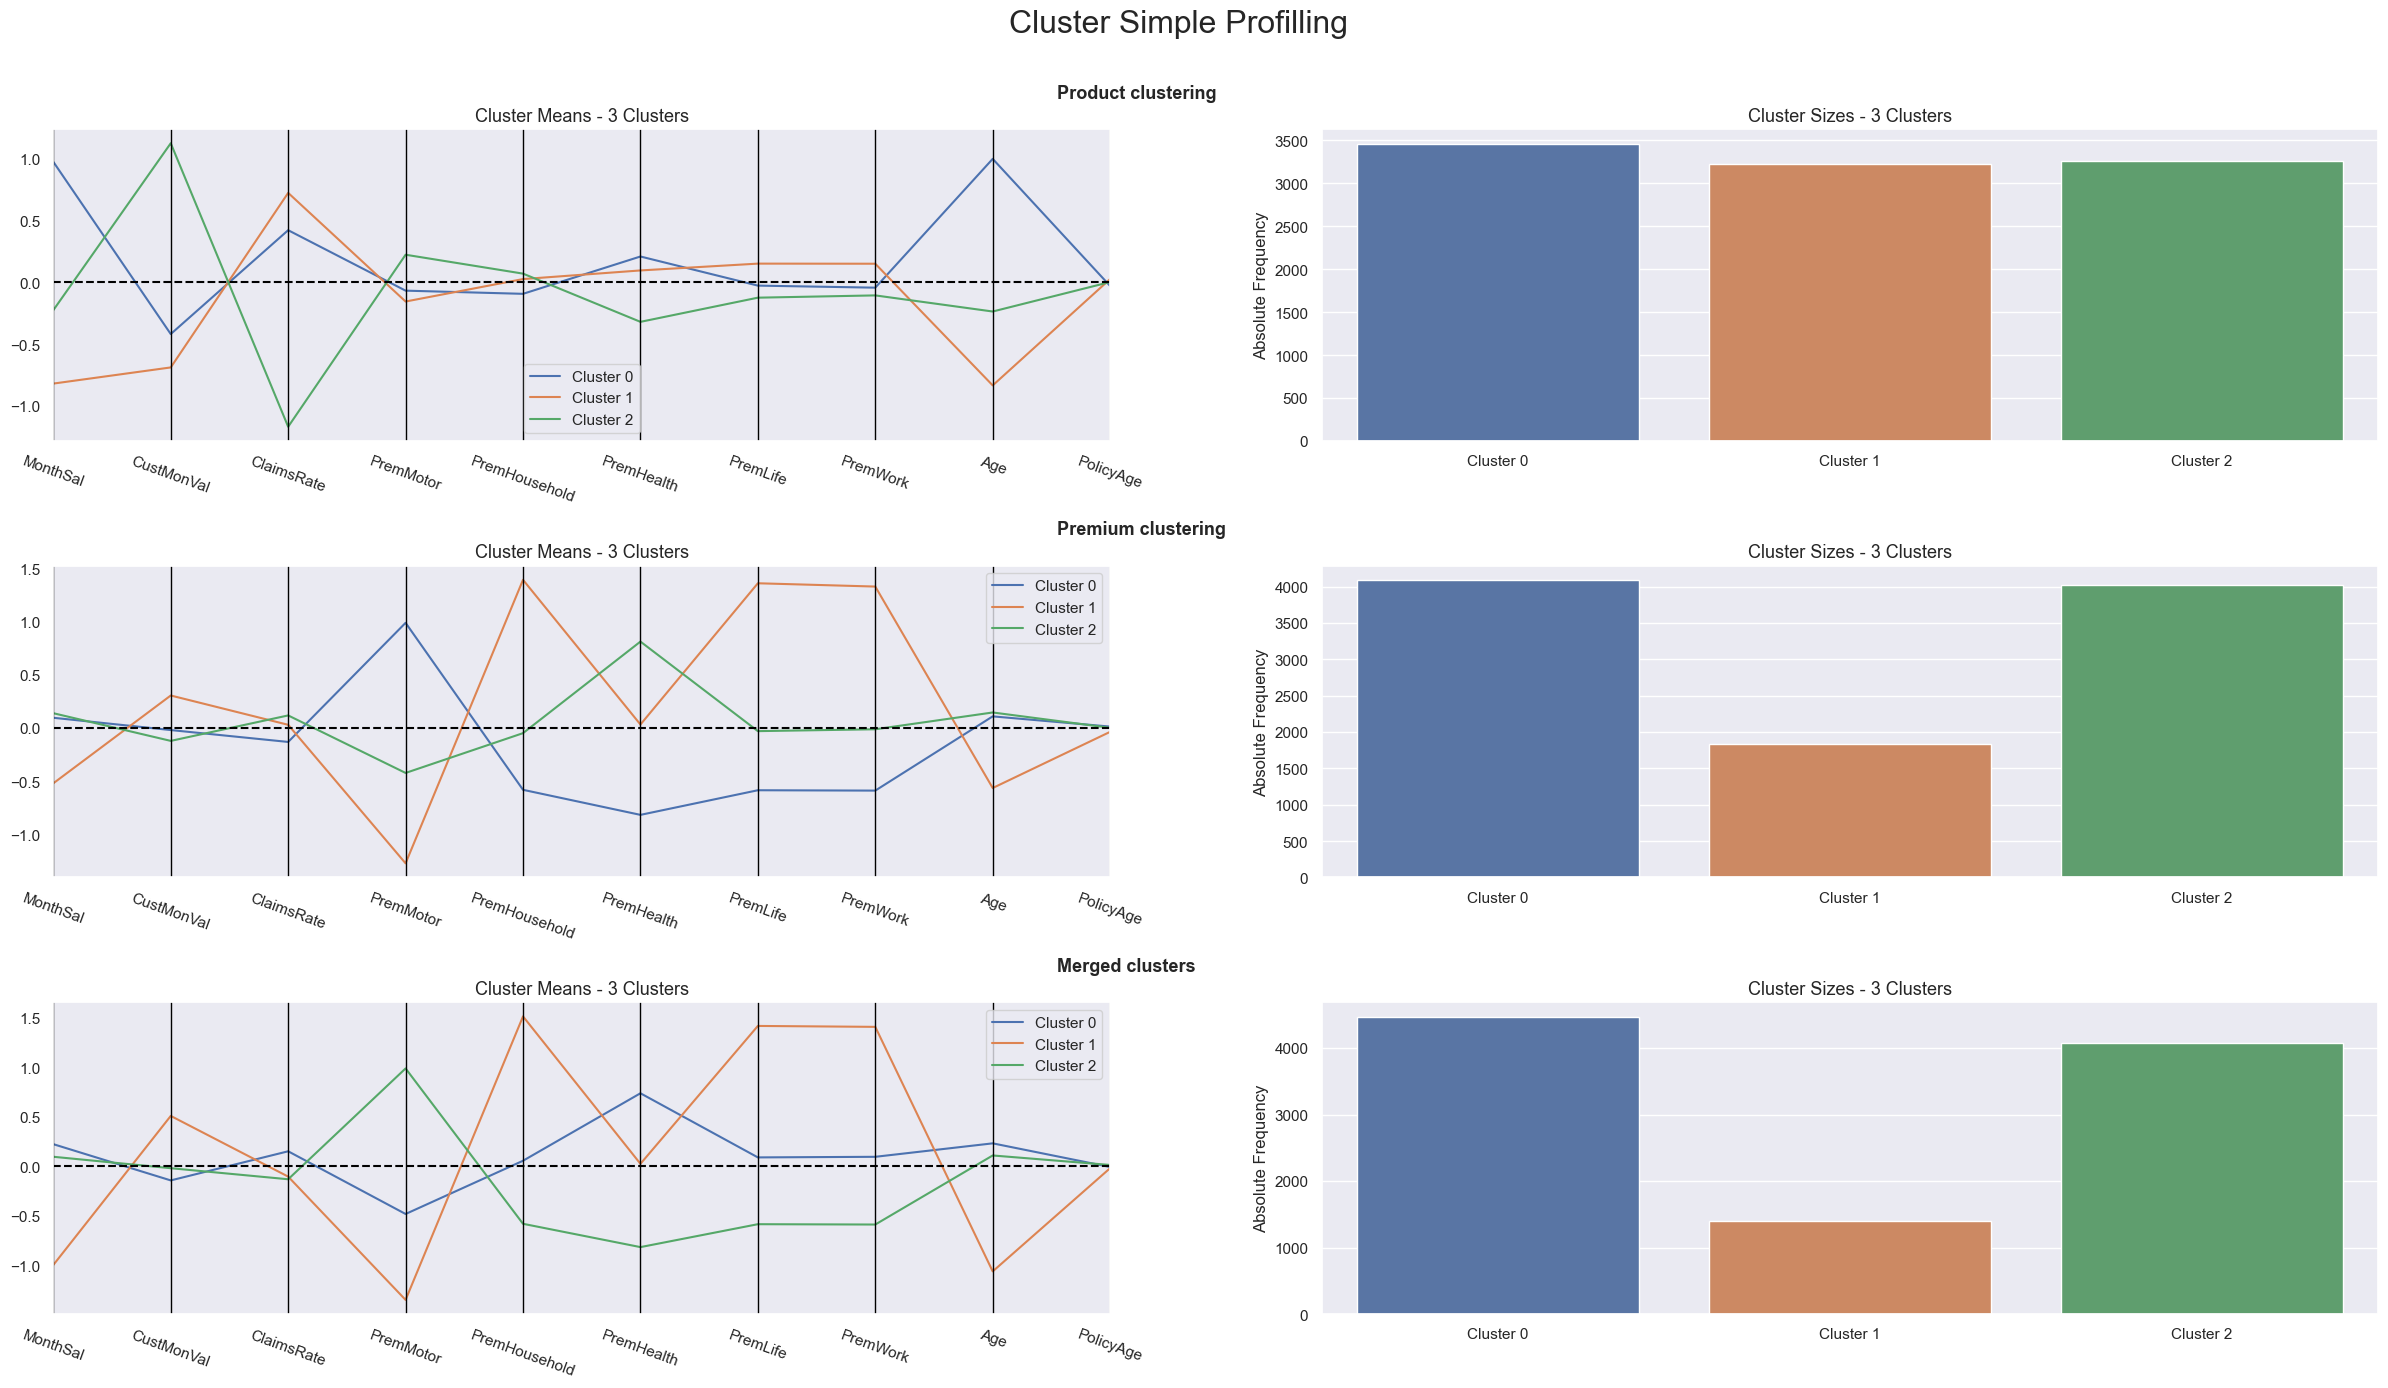

In [95]:
# Profile each cluster (value_demographic, premium, merged)
cluster_profiles(
    df = df[metric_features + ['value_dem_labels', 'premium_labels', 'merged_labels']], 
    label_columns = ['value_dem_labels', 'premium_labels', 'merged_labels'], 
    figsize = (30, 15), 
    compar_titles = ["Product clustering", "Premium clustering", "Merged clusters"]
)

- **8.6) Assessing Perspetive**
- 8.6.1) Assessing using R2

In [96]:
# First, we assess our clustering solution by using R²:

df_perspectives_r2 =  get_r2(df_, "merged_labels")
print("Different Perspectives Cluster solution with R^2 of %0.4f" % df_perspectives_r2);

# Second, we essentially decompose the R² into the R² for each variable:

get_r2_feature(df_[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels').\
                 sort_values(axis=0, ascending=False)

Different Perspectives Cluster solution with R^2 of 0.3393


PremMotor        0.758329
PremHealth       0.515814
PremHousehold    0.460385
PremLife         0.424983
PremWork         0.423417
Age              0.186775
MonthSal         0.165299
CustMonVal       0.045514
ClaimsRate       0.018809
PolicyAge        0.000144
dtype: float64

- **From the table above, we can conclude that:**: 
    - The final R2 value for our final cluster solution is 0.3393.
    - The three variables that mostly contribute to the this R2 value are: PremMotor, PremHealth and PremHousehold.

- **8.6) Assessing Perspetive**
- 8.6.2) Assessing using Decision Tree

In [97]:
# Preparing the data.
X = df_.drop(columns=['value_dem_labels','premium_labels','merged_labels'])
y = df_.merged_labels

# Splitting the data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fitting the decision tree.
dt = DecisionTreeClassifier(random_state=42, max_depth=10)

dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

# Neste caso, com max_depth = 10, estou a prever corretamente 92% dos clientes.

It is estimated that in average, we are able to predict 95.83% of the customers correctly


In [98]:
# Assess feature importance.
# We use sort as long as it provides an easier interpretability of the results.

pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(axis=0, ascending=False)

PremMotor                0.642771
Age                      0.130050
PremHealth               0.071053
PremHousehold            0.048494
PremWork                 0.031392
CustMonVal               0.025175
PremLife                 0.021484
MonthSal                 0.015835
ClaimsRate               0.007075
PolicyAge                0.003421
x0_b'3 - BSc/MSc'        0.001031
x2_2.0                   0.000481
x2_3.0                   0.000430
x0_b'2 - High School'    0.000314
x1_0.0                   0.000279
x2_1.0                   0.000279
x0_b'4 - PhD'            0.000224
x0_b'1 - Basic'          0.000210
x1_1.0                   0.000000
x2_4.0                   0.000000
dtype: float64

- **From the table above, we can conclude that:**: 
    - The three variables with higher importance are: PremMotor, Age and PremHealth.

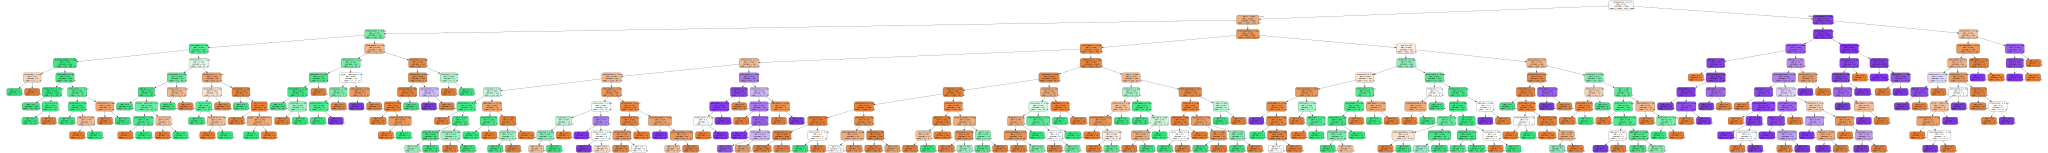

In [99]:
# Visualize the decision tree.
dot_data = export_graphviz(dt, out_file=None, 
                           feature_names=X.columns.to_list(),
                           filled=True,
                           rounded=True,
                           special_characters=True)  
graphviz.Source(dot_data)

- **8.7) Cluster Visualization using Tsne**

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


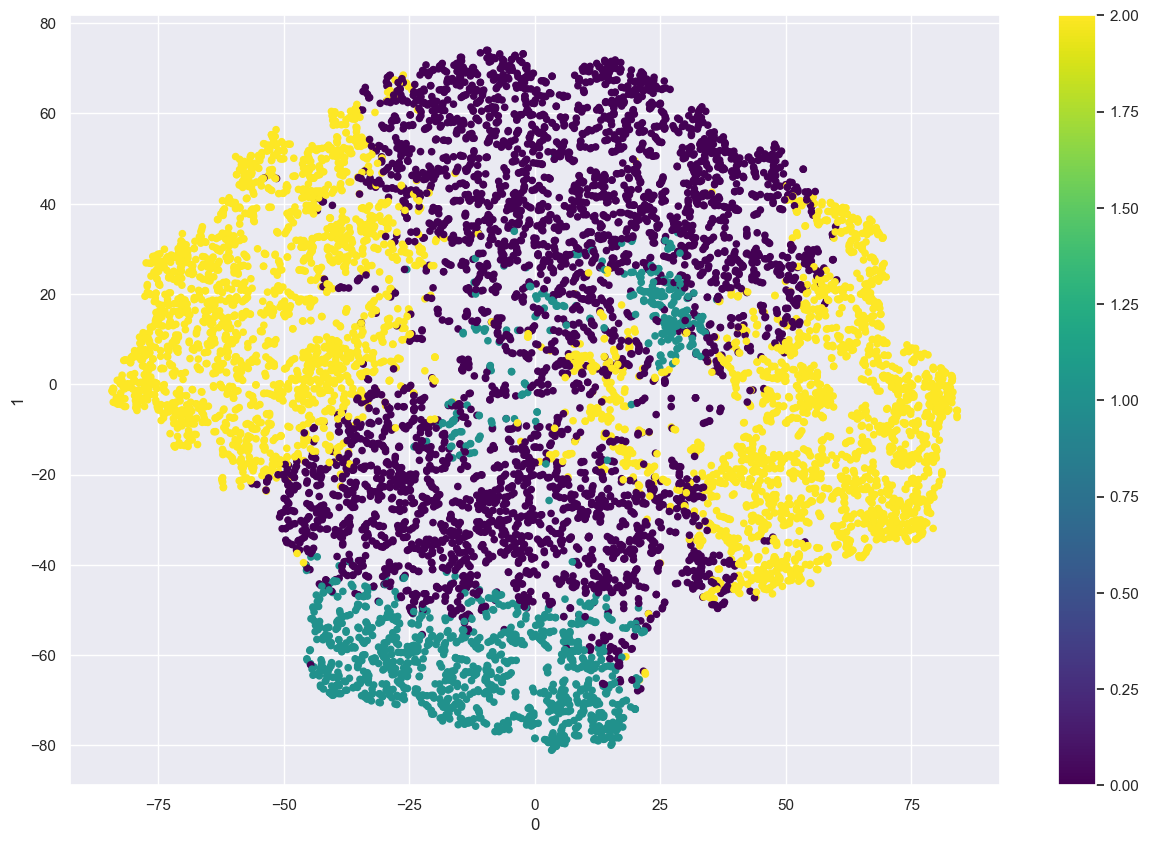

In [100]:
df_merged_tsne = TSNE(perplexity=30, random_state=42).fit_transform(df[metric_features])
pd.DataFrame(df_merged_tsne).plot.scatter(x=0, y=1, c = df['merged_labels'], colormap='viridis', figsize=(15,10))
plt.show()

- **Takeaway**
    - We were not able to get well defined clusters.

# **9. Density Based Clustering | Mean Shift Clustering**

- **9.1) Main Characteristics**
- **9.2) Defining the number of clusters**
- **9.3) Key Conclusions**
- **9.4) Assessing using R2**
- **9.5) Data Visualization**

- **9.1) Main Characteristics**
- No need to define number of clusters apriori
- Can detect clusters of any shape
- Robust to outliers
- Depends on the bandwidth hyperparameter (but there's a way to estimate it)
- Main drawback: Poor scalability (on both the algorithm and in estimating the bandwidth)

- **9.2) Defining the number of clusters**

In [101]:
bandwidth = estimate_bandwidth(df[metric_features], quantile=0.06, random_state=1, n_jobs=-1)
bandwidth

2.389726846574807

In [102]:
# Perform mean-shift clustering with bandwidth set using estimate_bandwidth.

df_MSC = MeanShift(bandwidth=bandwidth, bin_seeding=True, n_jobs=4)
df_MSC_labels = df_MSC.fit_predict(df[metric_features])
df_MSC_n_clusters = len(np.unique(df_MSC_labels))
print("Number of estimated MSC clusters : %d" % df_MSC_n_clusters)

Number of estimated MSC clusters : 2


- **9.3) Key Conclusions**

In [103]:
# Concatenate the labels to df (after scaling).

df_MSC_concat = pd.concat([df, pd.Series(df_MSC_labels, index=df.index, name="df_MSC_labels")], axis=1)
df_MSC_concat.head()

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0 -0.365735    0.683748   -0.915959   0.536907      -0.544527   -0.305702   
1 -1.917183   -1.418237    1.398226  -1.694840       1.054968   -0.710036   
2 -0.262305    1.191491   -1.264672  -0.732329       0.144432   -0.602513   
3 -1.480709   -0.949734    0.986111  -0.909364      -0.715995    1.940278   
4 -0.793935   -0.735389    0.700800   0.258453      -0.694858    0.188029   

   PremLife  PremWork       Age  PolicyAge  ...  x1_0.0  x1_1.0  x2_1.0  \
0  0.198950 -0.521633 -0.853551   0.156329  ...     0.0     1.0     1.0   
1  3.777013  1.668439 -1.617274   0.761939  ...     0.0     1.0     0.0   
2  1.153456  1.493950 -0.148576  -0.752086  ...     1.0     0.0     0.0   
3 -0.084199 -0.240634 -0.794803  -0.600683  ...     0.0     1.0     0.0   
4 -0.485994  0.081103 -0.324820   0.004927  ...     0.0     1.0     0.0   

   x2_2.0  x2_3.0  x2_4.0  value_dem_labels  premium_labels  merged_labels  \
0     0.0     0.0     0.0                 2               0              2   
1     0.0     0.0     1.0                 1               1              1   
2     0.0     1.0     0.0                 2               1              1   
3     0.0     0.0     1.0                 1               2              0   
4     0.0     0.0     1.0                 1               2              0   

   df_MSC_labels  
0              1  
1              0  
2              1  
3              0  
4              0  

[5 rows x 24 columns]

In [104]:
# Concatenate the labels to df (before scaling).

df_before_scaling_MSC_concat = pd.concat([df_before_scaling, pd.Series(df_MSC_labels, index=df_before_scaling.index, name="df_MSC_labels")], axis=1)
df_before_scaling_MSC_concat.mean().T

MonthSal                 2530.606472
CustMonVal                214.390677
ClaimsRate                  0.678935
PremMotor                 304.064199
PremHousehold             194.092069
PremHealth                168.792421
PremLife                   38.810254
PremWork                   38.145254
Age                        48.529045
PolicyAge                  29.967459
x0_b'1 - Basic'             0.107961
x0_b'2 - High School'       0.342782
x0_b'3 - BSc/MSc'           0.479493
x0_b'4 - PhD'               0.069763
x1_0.0                      0.290812
x1_1.0                      0.709188
x2_1.0                      0.295738
x2_2.0                      0.101528
x2_3.0                      0.200442
x2_4.0                      0.402292
df_MSC_labels               0.459087
dtype: float64

- **Takeaways**: 
    - As we can see in the following step, since we got a low very for R2 value, we did not perform a deep interpretation on this cluster.

- **9.4) Assessing using R2**

In [105]:
# First, we are assessing our clustering solution by using R²:

df_msc_r2 =  get_r2(df_MSC_concat, "df_MSC_labels")
print("Cluster final solution with R² of %0.4f" % df_msc_r2);

# Second, we are essentially decomposing the R² into the R² per variable:

get_r2_feature(df_MSC_concat[metric_features + ['df_MSC_labels']], 'df_MSC_labels').drop('df_MSC_labels').sort_values(axis=0, ascending=False)

Cluster final solution with R² of 0.1395


ClaimsRate       0.779308
CustMonVal       0.715624
PremHealth       0.008397
PremHousehold    0.003312
PremMotor        0.002804
PremLife         0.001608
PremWork         0.000575
Age              0.000192
PolicyAge        0.000158
MonthSal         0.000127
dtype: float64

- **From the table above, we can conclude that:**: 
    - The final R2 value for our final cluster solution is 0.1395.
    - The three variables that mostly contribute to the this R2 value are: Claims Rate and CustMonVal.

- **9.5) Data Visualization**

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


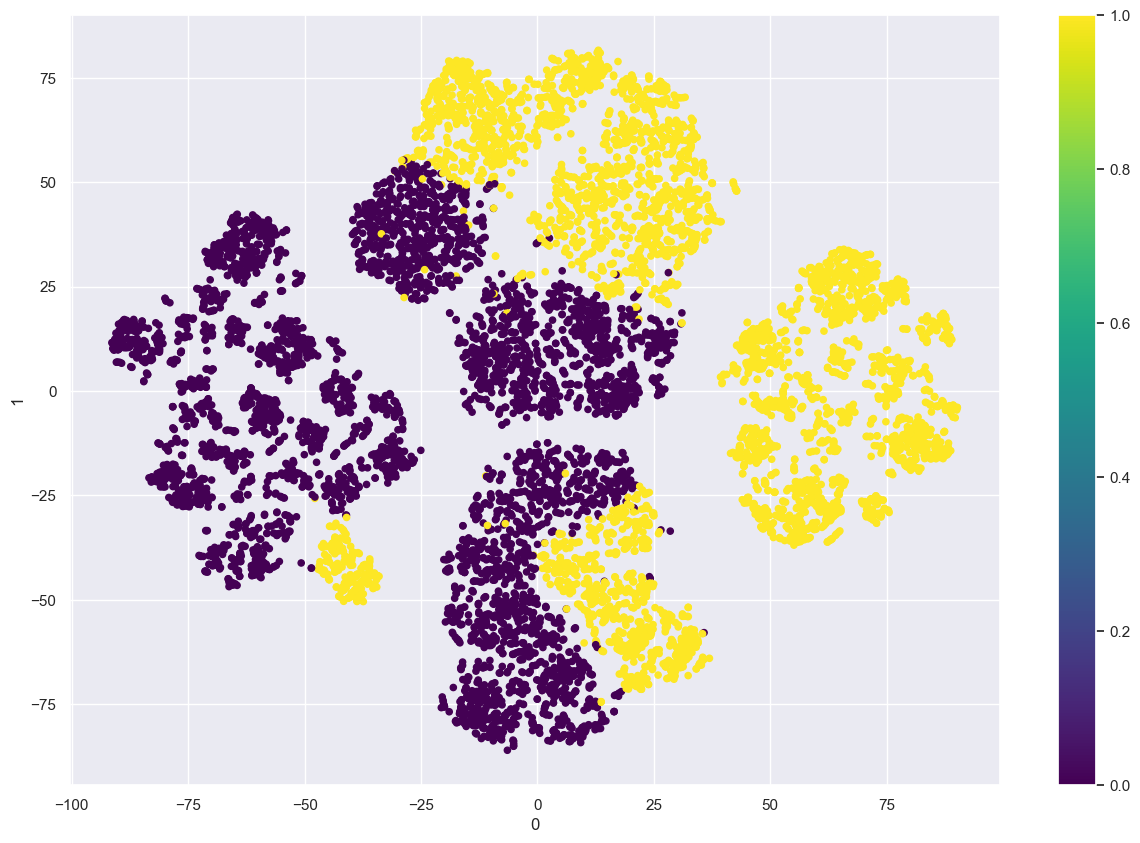

In [106]:
df_MSC_tsne = TSNE(perplexity=30, random_state=42).fit_transform(df_MSC_concat)

pd.DataFrame(df_MSC_tsne).plot.scatter(x=0, y=1, c = df_MSC_concat['df_MSC_labels'], colormap='viridis', figsize=(15,10))
plt.show()

- **Key Takeaways**
    - As we can see in the graph above, Mean Shift performs very poor when compared to previous algorithms.

# **10. Density Based Clustering | DBSCAN**

- **10.1) Main Characteristics**
- **10.2) Defining the number of clusters**
- **10.3) Defining eps and min_samples**
- **10.4) Key Conclusions**
- **10.5) Assessing using R2**
- **10.6) Data Visualization**

- **10.1) Main Characteristics**
- No need to define number of clusters apriori
- Resistant to noise and outliers
- Can identify outliers
- Can handle clusters of different shapes and sizes
- Depends highly on the epsilon hyperparameter and it can be hard to tune
- Does not work well with clusters of varying densities

- **10.2) Defining the number of clusters**

In [107]:
# Perform DBSCAN clustering.

df_dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
df_dbscan_labels = df_dbscan.fit_predict(df[metric_features])

df_dbscan_n_clusters = len(np.unique(df_dbscan_labels))
print("Number of estimated DBSCAN clusters : %d" % df_dbscan_n_clusters)

Number of estimated DBSCAN clusters : 2


- **10.3) Defining eps and min_samples**

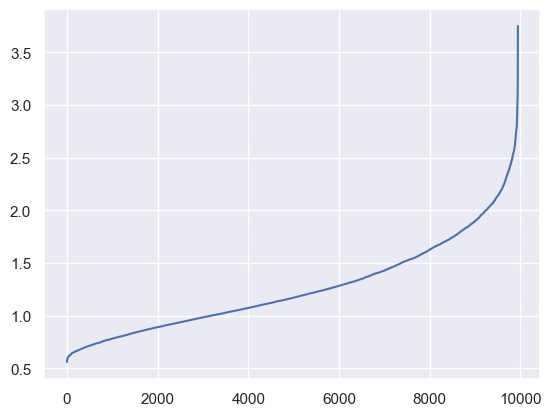

In [108]:
# K-distance graph to find out the right eps value.

neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df[metric_features])
distances, _ = neigh.kneighbors(df[metric_features])
distances = np.sort(distances[:, -1])
plt.plot(distances)
plt.show()

- **10.4) Key Conclusions**

In [109]:
# Concatenate the labels to df (after scaling).

df_dbscan_concat = pd.concat([df[metric_features], pd.Series(df_dbscan_labels, index=df.index, name="df_dbscan_labels")], axis=1)
df_dbscan_concat.head()

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0 -0.365735    0.683748   -0.915959   0.536907      -0.544527   -0.305702   
1 -1.917183   -1.418237    1.398226  -1.694840       1.054968   -0.710036   
2 -0.262305    1.191491   -1.264672  -0.732329       0.144432   -0.602513   
3 -1.480709   -0.949734    0.986111  -0.909364      -0.715995    1.940278   
4 -0.793935   -0.735389    0.700800   0.258453      -0.694858    0.188029   

   PremLife  PremWork       Age  PolicyAge  df_dbscan_labels  
0  0.198950 -0.521633 -0.853551   0.156329                 0  
1  3.777013  1.668439 -1.617274   0.761939                 0  
2  1.153456  1.493950 -0.148576  -0.752086                 0  
3 -0.084199 -0.240634 -0.794803  -0.600683                 0  
4 -0.485994  0.081103 -0.324820   0.004927                 0

In [110]:
# Detecting noise (potential outliers).

df_dbscan_concat.loc[df_dbscan_concat['df_dbscan_labels'] == -1]

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
186   -1.327633   -1.406374    1.239720  -2.025650       3.952821   -1.175013   
257   -2.224370    3.657351   -1.486580  -1.893491       3.886799    0.724143   
287   -0.349186    1.659953   -2.152304  -1.230226      -0.531227    1.058839   
328   -0.759803   -1.792744    1.810341  -1.554379       0.197154    0.574238   
341    1.180542   -0.453524    0.447191  -1.325812      -0.309649   -0.426852   
...         ...         ...         ...        ...            ...         ...   
10134 -1.907875   -0.088088    0.161881  -1.305019       0.339648    0.375819   
10188 -1.617237    2.935305   -1.074465  -2.128714       4.232584   -1.164383   
10228 -1.744455    3.394655   -1.359775  -1.892668       4.045204    1.069469   
10287  1.359476   -0.471708    0.700800  -1.620870       3.084557   -0.643397   
10290 -1.969933   -0.156513    0.542294  -2.222654       3.250800   -0.894827   

       PremLife  PremWork       Age  PolicyAge  df_dbscan_labels  
186    0.894570  4.270317 -1.852266  -1.054891                -1  
257   -0.680098  2.224793 -1.617274  -0.752086                -1  
287    0.819112  1.589416 -0.442316  -0.297878                -1  
328    3.847133 -0.093386 -1.382283  -1.357696                -1  
341    4.372912  1.663040  1.085130  -0.449281                -1  
...         ...       ...       ...        ...               ...  
10134 -0.725955  4.193993 -1.558526  -0.903488                -1  
10188  0.654609  3.885753 -1.499778   1.216147                -1  
10228  0.366122 -0.428867 -1.676022   1.216147                -1  
10287  2.889958 -0.115228  1.555114  -1.509098                -1  
10290  1.800550  4.003061 -1.852266  -1.206293                -1  

[202 rows x 11 columns]

In [111]:
# Concatenate the labels to df (before scaling).

df_before_scaling_dbscan_concat = pd.concat([df_before_scaling, pd.Series(df_dbscan_labels, index=df_before_scaling.index, name="df_dbscan_labels")], axis=1)
df_before_scaling_dbscan_concat.mean().T

MonthSal                 2530.606472
CustMonVal                214.390677
ClaimsRate                  0.678935
PremMotor                 304.064199
PremHousehold             194.092069
PremHealth                168.792421
PremLife                   38.810254
PremWork                   38.145254
Age                        48.529045
PolicyAge                  29.967459
x0_b'1 - Basic'             0.107961
x0_b'2 - High School'       0.342782
x0_b'3 - BSc/MSc'           0.479493
x0_b'4 - PhD'               0.069763
x1_0.0                      0.290812
x1_1.0                      0.709188
x2_1.0                      0.295738
x2_2.0                      0.101528
x2_3.0                      0.200442
x2_4.0                      0.402292
df_dbscan_labels           -0.020306
dtype: float64

- **Takeaways**: 
    - As we can see in the following step, since we got a low very for R2 value, we did not perform a deep interpretation on this cluster.

- **10.5) Assessing using R2**

In [112]:
# First, we are assessing our clustering solution by using R²:

df_dbscan_r2 =  get_r2(df_dbscan_concat, "df_dbscan_labels")
print("Cluster final solution with R² of %0.4f" % df_dbscan_r2);

# Second, we are essentially decomposing the R² into the R² per variable:

get_r2_feature(df_dbscan_concat[metric_features + ['df_dbscan_labels']], 'df_dbscan_labels').drop('df_dbscan_labels').sort_values(axis=0, ascending=False)

Cluster final solution with R² of 0.0258


PremWork         0.068593
PremHousehold    0.057515
PremLife         0.053666
PremMotor        0.043170
CustMonVal       0.006497
PremHealth       0.003619
MonthSal         0.002451
Age              0.002407
ClaimsRate       0.000981
PolicyAge        0.000020
dtype: float64

- **10.6) Data Visualization**

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


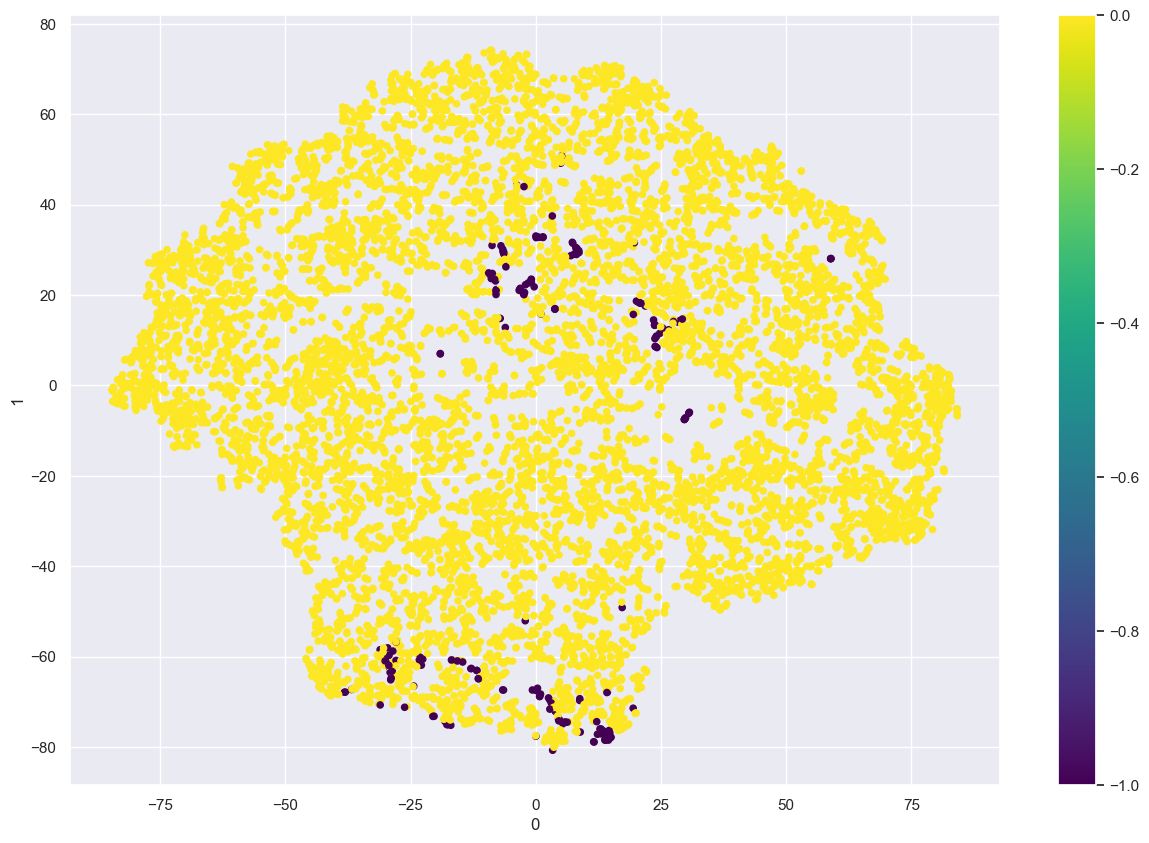

In [113]:
df_dbscan_tsne = TSNE(perplexity=30, random_state=42).fit_transform(df_dbscan_concat)

pd.DataFrame(df_dbscan_tsne).plot.scatter(x=0, y=1, c = df_dbscan_concat['df_dbscan_labels'], colormap='viridis', figsize=(15,10))
plt.show()

- **Key Takeaways**
    - Similarly to Mean Shift Algorithm, DBSCAN also performs very poor when compared to previous algorithms tested above.

# **11. Density Based Clustering | GMM**

- **11.1) Main Characteristics**
- **11.2) Defining the number of components**
- **11.3) Key Conclusions**
- **11.4) Assessing using R2**
- **11.5) Data Visualization**

- **11.1) Main Characteristics**
- Assumes the data is generated from a mixture of finite number of Gaussian distributions with unknown parameters
- Use the EM (Expectation Maximization algorithm) to estimate the parameters
- Provides a probability of each observation belonging to each cluster
- Advantages over K-Means:
    - Can deal with spherical and elipsoid cluster shapes
    - Number of components needs to be defined apriori

- **11.2) Defining the number of components**

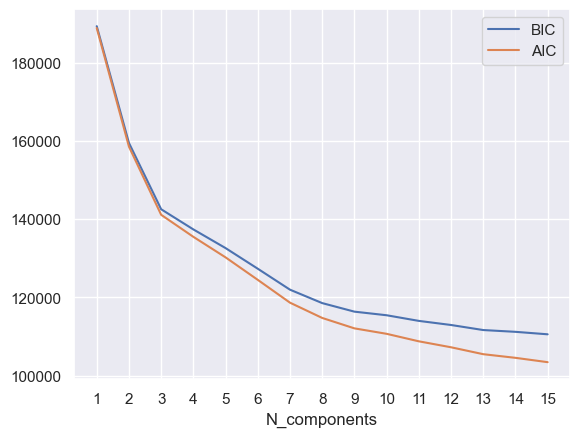

In [114]:
# Select number of components based on AIC and BIC.

n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df[metric_features])
          for n in n_components]

bic_values = [m.bic(df[metric_features]) for m in models]
aic_values = [m.aic(df[metric_features]) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('N_components')
plt.xticks(n_components)
plt.show()

- **11.3) Key Conclusions**

In [115]:
# Performing GMM clustering.

df_gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
df_gmm_labels = df_gmm.fit_predict(df[metric_features])

Number of estimated Gaussian clusters : 3


In [116]:
# Concatenat the labels to df.

df_gmm_concat = pd.concat([df, pd.Series(df_gmm_labels, index=df.index, name="df_gmm_labels")], axis=1)
df_gmm_concat.head()

MonthSal  CustMonVal  ClaimsRate  PremMotor  PremHousehold  PremHealth  \
0 -0.365735    0.683748   -0.915959   0.536907      -0.544527   -0.305702   
1 -1.917183   -1.418237    1.398226  -1.694840       1.054968   -0.710036   
2 -0.262305    1.191491   -1.264672  -0.732329       0.144432   -0.602513   
3 -1.480709   -0.949734    0.986111  -0.909364      -0.715995    1.940278   
4 -0.793935   -0.735389    0.700800   0.258453      -0.694858    0.188029   

   PremLife  PremWork       Age  PolicyAge  ...  x1_0.0  x1_1.0  x2_1.0  \
0  0.198950 -0.521633 -0.853551   0.156329  ...     0.0     1.0     1.0   
1  3.777013  1.668439 -1.617274   0.761939  ...     0.0     1.0     0.0   
2  1.153456  1.493950 -0.148576  -0.752086  ...     1.0     0.0     0.0   
3 -0.084199 -0.240634 -0.794803  -0.600683  ...     0.0     1.0     0.0   
4 -0.485994  0.081103 -0.324820   0.004927  ...     0.0     1.0     0.0   

   x2_2.0  x2_3.0  x2_4.0  value_dem_labels  premium_labels  merged_labels  \
0     0.0     0.0     0.0                 2               0              2   
1     0.0     0.0     1.0                 1               1              1   
2     0.0     1.0     0.0                 2               1              1   
3     0.0     0.0     1.0                 1               2              0   
4     0.0     0.0     1.0                 1               2              0   

   df_gmm_labels  
0              0  
1              2  
2              2  
3              1  
4              1  

[5 rows x 24 columns]

- **11.4) Assessing using R2**

In [117]:
# First, we are assessing our clustering solution by using R²:

df_gmm_r2 =  get_r2(df_gmm_concat, "df_gmm_labels")
print("Cluster final solution with R² of %0.4f" % df_gmm_r2);

# Second, we are essentially decomposing the R² into the R² per variable:

get_r2_feature(df_gmm_concat[metric_features + ['df_gmm_labels']], 'df_gmm_labels').drop('df_gmm_labels').sort_values(axis=0, ascending=False)

Cluster final solution with R² of 0.2601


ClaimsRate       0.597955
PremMotor        0.478267
CustMonVal       0.433822
PremHousehold    0.427951
PremLife         0.328033
PremWork         0.304211
PremHealth       0.068006
Age              0.022269
MonthSal         0.019584
PolicyAge        0.000121
dtype: float64

- **From the table above, we can conclude that:**: 
    - The final R2 value for our final cluster solution is 0.26.
    - The three variables that mostly contribute to the this R2 value are: Claims Rate and PremMotor.

- **11.5) Data Visualization**

C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Utilizador\anaconda3\envs\Programming_for_DS\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


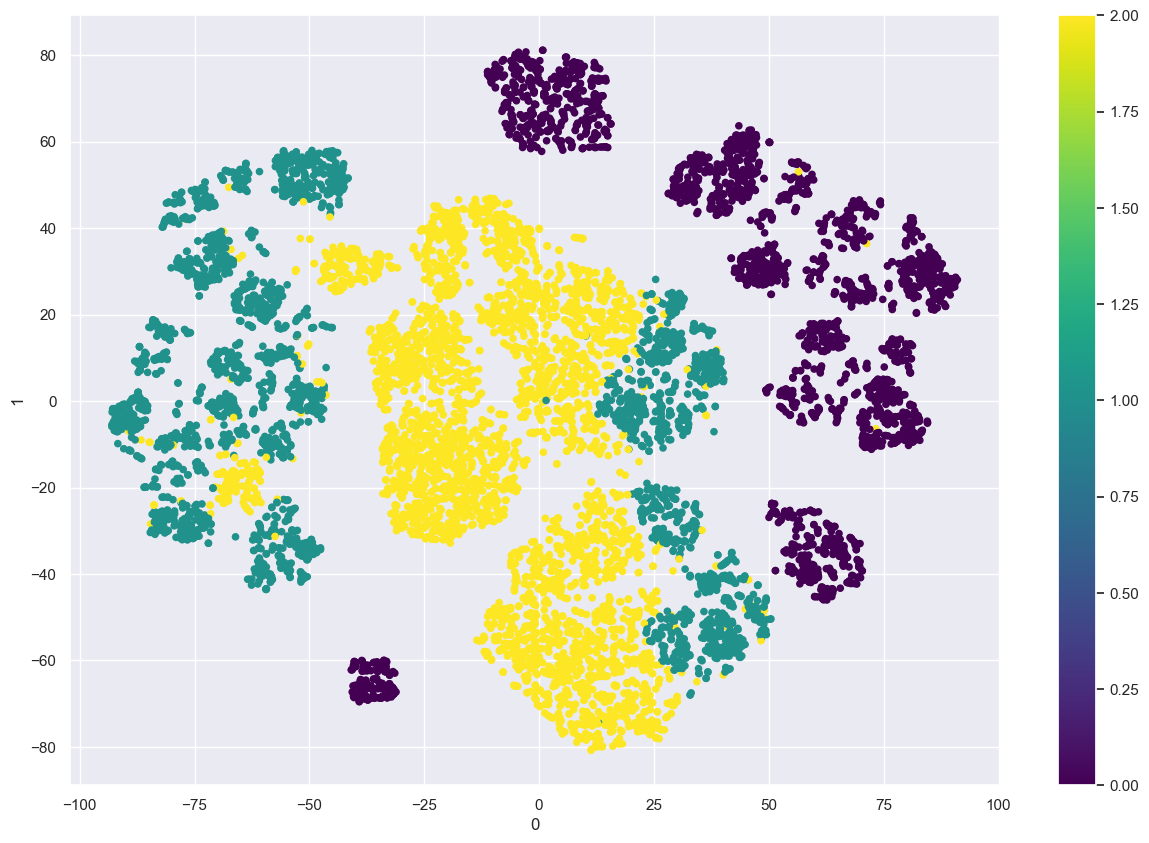

In [118]:
df_gmm_tsne = TSNE(perplexity=30, random_state=42).fit_transform(df_gmm_concat)

pd.DataFrame(df_gmm_tsne).plot.scatter(x=0, y=1, c = df_gmm_concat['df_gmm_labels'], colormap='viridis', figsize=(15,10))
plt.show()

- **Key Takeaways**
    - Similarly to the remaining density algorithms tested, Gaussian algorithm also performs very poor when compared to previous algorithms tested above.

# **12. Final Conclusion | Algorithms Aggregation**

- **12.1) R2 Comparisation**
- **12.1) Number of clusters Comparisation**

In [119]:
df_kmeans_r2 =  get_r2(df_kmeans, "df_km_labels")
print("Kmeans Cluster final solution with R² of %0.4f" % df_kmeans_r2);

df_bkm_r2 =  get_r2(df_bkm, "bkmlabels")
print("Batch K-Means Cluster solution with R^2 of %0.4f" % df_bkm_r2)

df_hc_r2 =  get_r2(df_hc, "df_hc_labels")
print("Hierarchical Clustering solution with R^2 of %0.4f" % df_hc_r2)

df_perspectives_r2 =  get_r2(df_, "merged_labels")
print("Different Perspectives Cluster solution with R^2 of %0.4f" % df_perspectives_r2);

df_msc_r2 =  get_r2(df_MSC_concat, "df_MSC_labels")
print("Mean Shift Cluster final solution with R² of %0.4f" % df_msc_r2);

df_dbscan_r2 =  get_r2(df_dbscan_concat, "df_dbscan_labels")
print("DBSCan Cluster final solution with R² of %0.4f" % df_dbscan_r2);

df_gmm_r2 =  get_r2(df_gmm_concat, "df_gmm_labels")
print("GMM Cluster final solution with R² of %0.4f" % df_gmm_r2);

Kmeans Cluster final solution with R² of 0.4373
Batch K-Means Cluster solution with R^2 of 0.5335
Hierarchical Clustering solution with R^2 of 0.3908
Different Perspectives Cluster solution with R^2 of 0.3393
Mean Shift Cluster final solution with R² of 0.1395
DBSCan Cluster final solution with R² of 0.0258
GMM Cluster final solution with R² of 0.2601


In [123]:
# print("Number of estimated kmeans clusters : %d" % df_km_n_clusters)
# print("Number of estimated batch kmeans clusters : %d" % df_bkm_n_clusters)
# print("Number of estimated hierarquical kmeans clusters : %d" % df_hc_n_clusters)
# print("Number of estimated perspectives clustering clusters : %d" % df_merged_n_clusters) 
# print("Number of estimated DBSCAN clusters : %d" % df_dbscan_n_clusters)
# print("Number of estimated MSC clusters : %d" % df_MSC_n_clusters)
# print("Number of estimated Gaussian clusters : %d" % df_gmm_n_clusters)